In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
from random import sample
import random
from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Activation, Add, Dropout,Reshape, Concatenate,PReLU,Embedding,multiply
from keras.layers.core import Dense,Activation,Flatten
from keras.layers import UpSampling2D, Lambda
from keras.datasets import mnist
from keras.models import Model,Sequential
from keras.layers.convolutional import Conv2D,UpSampling2D,Conv2DTranspose
from keras.layers.pooling import AvgPool2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam, RMSprop
from keras import backend as K
import tensorflow as tf
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from skimage.transform import resize
from keras import backend as K

Using TensorFlow backend.


In [12]:
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols,self.channels)
        self.num_classes = 12
        self.latent_dim = 100

        optimizer1 = Adam(0.0002, 0.5)
        optimizer2 = Adam(0.00003, 0.5)
        losses = ['binary_crossentropy']
              
        # Build and compile the discriminator
        img_input = Input(shape=(self.img_rows,self.img_cols,self.channels))
        self.discriminator,valid = self.get_discriminator(img_input)
        self.discriminator.compile(loss=losses,
            optimizer=optimizer2,
            metrics=['accuracy'])      


        # Build the generator
        noise = Input(shape=(100,))

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        self.generator = self.get_generator(noise)
        img = self.generator(noise)
        valid = self.discriminator(img)


        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
       
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise,valid)
        self.combined.compile(loss=losses,
            optimizer=optimizer1,
            metrics=['accuracy'])

    """    
    def SubpixelConv2D(self,name, scale=2):
        def subpixel_shape(input_shape):
            dims = [input_shape[0],
                    None if input_shape[1] is None else input_shape[1] * scale,
                    None if input_shape[2] is None else input_shape[2] * scale,
                    int(input_shape[3] / (scale ** 2))]
            output_shape = tuple(dims)
            return output_shape

        def subpixel(x):
            return tf.depth_to_space(x, scale)

        return Lambda(subpixel, output_shape=subpixel_shape, name=name)
    """
    def get_generator(self,input_layer):
        def residual_block(input):
            x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input)
            x = BatchNormalization(momentum=0.8)(x)
            x = LeakyReLU(0.2)(x)            
            x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
            x = BatchNormalization(momentum=0.8)(x)
            #x = Add()([x, input])
            return x

        def upsample(x, number):
            x = Conv2D(256, kernel_size=3, strides=1, padding='same', name='upSampleConv2d_'+str(number))(x)
            x = self.SubpixelConv2D('upSampleSubPixel_'+str(number), 2)(x)
            x = PReLU(shared_axes=[1,2], name='upSamplePReLU_'+str(number))(x)
            return x

        hid = Dense(512 * 8 * 8, activation='relu')(input_layer)    
        x_start = Reshape((8, 8, 512))(hid)
        
       
        gen = Conv2D(256, (3,3), padding='same')(x_start)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        # gen = Activation('ReLU')(gen)

        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(128, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        # gen = Activation('ReLU')(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)

        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        #gen = upsample(gen,1)
        #gen = upsample(gen,2)
        #gen = upsample(gen,3)
        gen = Conv2D(3, (3,3), padding='same')(gen)
        gen = Activation('tanh')(gen)
    
        """hid = Dense(512 * 12 * 12, activation='relu')(input_layer)    
        x_start = Reshape((12, 12, 512))(hid)
        
       
        gen = Conv2D(256, (3,3), padding='same')(x_start)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        # gen = Activation('ReLU')(gen)

        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(128, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        # gen = Activation('ReLU')(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)

        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        gen = Conv2D(64, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)
        #gen = upsample(gen,1)
        #gen = upsample(gen,2)
        #gen = upsample(gen,3)
        gen = Conv2D(3, (3,3), padding='same')(gen)
        gen = Activation('tanh')(gen)
        """

        """  
        x_start = Conv2D(64, kernel_size=9, strides=1, padding='same')(x_start)
        x_start = PReLU(shared_axes=[1,2])(x_start)
        r = residual_block(x_start)
        #for _ in range(3):
        #    r = residual_block(r)
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        x = BatchNormalization(momentum=0.8)(x)
        x = Add()([x, x_start])
        
        
        #gen = UpSampling2D(size=(2,2))(x)
        gen = Conv2D(256, (3,3), padding='same')(x)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen)   
        
        gen = residual_block(gen) 
        gen = upsample(gen, 1)
        #gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(256, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen) 
        
        gen = upsample(gen, 2)
        gen = residual_block(gen) 
        gen = residual_block(gen) 
        gen = upsample(gen, 3)
        
        #gen = UpSampling2D(size=(2,2))(gen)
        gen = Conv2D(256, (3,3), padding='same')(gen)
        gen = BatchNormalization(momentum = 0.5)(gen)
        gen = LeakyReLU(0.2)(gen) 
        
        gen = residual_block(gen) 
        gen = residual_block(gen) 
        """

        #x = upsample(x, 1)
        #x = upsample(x, 2)
        #x = upsample(x, 3)
        hr_output = Conv2D(
                3, 
                kernel_size=9, 
                strides=1, 
                padding='same', 
                activation='tanh'
            )(gen)
        model = Model(inputs=input_layer, outputs=hr_output)  
        model.summary()
        return model
    

    def get_discriminator(self,input_layer):
            def conv2d_block(input, filters, strides=1, bn=True):
                d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
                d = LeakyReLU(alpha=0.2)(d)
                if bn:
                    d = BatchNormalization(momentum=0.8)(d)
                return d
            def residual_block(input,filters=64):
                x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(input)
                x = BatchNormalization(momentum=0.8)(x)
                x = PReLU(shared_axes=[1,2])(x)            
                x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
                x = BatchNormalization(momentum=0.8)(x)
                x = Add()([x, input])
                return x

            filters = 32
            x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(input_layer)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x,filters)
            #x = residual_block(x,filters)
            x = Conv2D(filters*4, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x, filters*4)
            x = residual_block(x, filters*4)
            x = Conv2D(filters*8, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x, filters*8)
            x = residual_block(x, filters*8)
            x = Conv2D(filters*8, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x, filters*8)
            x = residual_block(x, filters*8)
            x = Conv2D(filters*8, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            """            
            x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(input_layer)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x,filters)
            #x = residual_block(x,filters)
            x = Conv2D(filters*2, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x, filters*2)
            x = residual_block(x, filters*2)
            x = Conv2D(filters*4, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = residual_block(x, filters*4)
            x = residual_block(x, filters*4)
            x = Conv2D(filters*8, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            #x = residual_block(x, filters*8)
            x = residual_block(x, filters*8)
            x = Conv2D(filters*16, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            #x = residual_block(x, filters*8)
            x = residual_block(x, filters*16)
            x = Conv2D(filters*32, kernel_size=3, strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            """
            x = Flatten()(x)
            x1 = Dense(1, activation='sigmoid')(x)
            
            model = Model(inputs=input_layer, outputs=x1)
            model.summary()
            return model,x1
    def train(self,X_train, epochs, batch_size=128, sample_interval=50,img_name=''):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()

        # Configure inputs
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)
        #y_train = y_train.reshape(-1, 1)
        #print('y_train',y_train)
        
        # Adversarial ground truths
        #self.generator.load_weights('./No_Res_Module/generator_weights.hdf5',by_name=True)
        #self.discriminator.load_weights('./No_Res_Module/discriminator_weights.hdf5',by_name=True)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        pre_g_loss = 0
        id_list = [_ for _ in range(X_train.shape[0])]
        random.shuffle(id_list)
        
        for epoch in range(epochs):
            for mini_batch in range(X_train.shape[0]//batch_size-2):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                #idx = np.random.randint(0, X_train.shape[0], batch_size)
                idx = np.array([id_list[_] for _ in range(batch_size*mini_batch,batch_size*(mini_batch+1))])
                imgs = X_train[idx]

                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, 100))
                #print('imgs',np.shape(imgs))
                # The labels of the digits that the generator tries to create an
                # image representation of
                #sampled_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)
                #print('G',np.shape(gen_imgs))
                # Image labels. 0-11 if image is valid or 12 if it is generated (fake)
                #img_labels = y_train[idx]
                #fake_labels = self.num_classes * np.ones(img_labels.shape)
                #print('D',(self.discriminator.predict(gen_imgs)))
                # Train the discriminator
                if mini_batch % 3 == 0 and pre_g_loss < 5:
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    #print('real_loss',d_loss_real)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator
                g_loss = self.combined.train_on_batch(noise, valid)
                pre_g_loss = g_loss[0]
                # Plot the progress
                #print('d_loss',d_loss)
                #print('g_loss',g_loss)
                print ("Epoch%d,MiniBatch:%d [D loss: %f, acc.: %.2f%%] [G loss: %f，G acc: %f]" % (epoch,mini_batch, d_loss[0], 100*d_loss[1], g_loss[0],g_loss[1]))

                # If at save interval => save generated image samples
                if mini_batch % sample_interval == 1 or mini_batch == (X_train.shape[0]//batch_size-1):
                    self.save_model()
                    self.sample_images(epoch,mini_batch,img_name)
            

    def sample_images(self, epoch,mini_batch,img_name):
        r, c = 2, 6
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([_ for _ in range(r*c)])
        gen_imgs = self.generator.predict(noise)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = self.combine_images(gen_imgs) 
        """        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gen_imgs/%d_%d.png" % (epoch,mini_batch))
        plt.close()
        """
          
        plt.imshow(gen_imgs)
        plt.axis('off')
        plt.savefig("gen_imgs/%s%d_%d.png" % (img_name,epoch,mini_batch))
        plt.close()
        
        
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = 6
        height = 2
        shape = generated_images.shape[1:3]
        image = np.zeros((height*shape[0], width*shape[1],3),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
        return image
    
    def save_model(self):
        def save(model, model_name):
            model_path = "No_Res_Module/%s.json" % model_name
            weights_path = "No_Res_Module/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator_extra")
        save(self.discriminator, "discriminator_extra")

In [3]:
tags = pd.read_csv('./extra_data/extra_data/convert_tags.csv')
X_train = np.array([(np.array(load_img("./extra_data/extra_data/images/{}.jpg".format(ids))) / 127.5 - 1) for ids in tqdm_notebook(tags.idx)])
np.shape(X_train)

A Jupyter Widget

(36740, 64, 64, 3)

In [5]:
X_train = np.array([np.fliplr(x) for x in X_train])

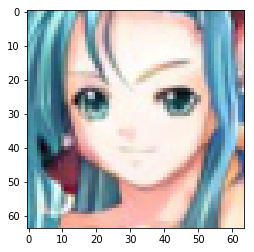

In [17]:
np.shape(X_train)

(60000, 28, 28, 1)

In [13]:
acgan = ACGAN()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 32)   896         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_37 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_85[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 32, 32, 32)   9248        leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
batch_norm

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 8, 8, 256)         1179904   
_________________________________________________________________
batch_normalization_78 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 256)       0         
__________

In [11]:
acgan.train(X_train,epochs=20, batch_size=32, sample_interval=200,img_name='extra_')


/home/wenjie/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch0,MiniBatch:0 [D loss: 2.104284, acc.: 4.69%] [G loss: 0.644879，G acc: 0.625000]
Epoch0,MiniBatch:1 [D loss: 2.104284, acc.: 4.69%] [G loss: 0.564197，G acc: 0.687500]
Epoch0,MiniBatch:2 [D loss: 2.104284, acc.: 4.69%] [G loss: 0.580633，G acc: 0.656250]
Epoch0,MiniBatch:3 [D loss: 0.482071, acc.: 76.56%] [G loss: 3.133419，G acc: 0.000000]
Epoch0,MiniBatch:4 [D loss: 0.482071, acc.: 76.56%] [G loss: 2.439780，G acc: 0.000000]
Epoch0,MiniBatch:5 [D loss: 0.482071, acc.: 76.56%] [G loss: 2.063423，G acc: 0.093750]
Epoch0,MiniBatch:6 [D loss: 0.286635, acc.: 89.06%] [G loss: 3.311021，G acc: 0.000000]
Epoch0,MiniBatch:7 [D loss: 0.286635, acc.: 89.06%] [G loss: 2.902826，G acc: 0.000000]
Epoch0,MiniBatch:8 [D loss: 0.286635, acc.: 89.06%] [G loss: 2.711054，G acc: 0.000000]
Epoch0,MiniBatch:9 [D loss: 0.246811, acc.: 95.31%] [G loss: 2.711386，G acc: 0.000000]
Epoch0,MiniBatch:10 [D loss: 0.246811, acc.: 95.31%] [G loss: 2.546146，G acc: 0.000000]
Epoch0,MiniBatch:11 [D loss: 0.246811, acc.: 

Epoch0,MiniBatch:96 [D loss: 1.173016, acc.: 54.69%] [G loss: 4.545009，G acc: 0.000000]
Epoch0,MiniBatch:97 [D loss: 1.173016, acc.: 54.69%] [G loss: 3.799045，G acc: 0.031250]
Epoch0,MiniBatch:98 [D loss: 1.173016, acc.: 54.69%] [G loss: 2.412282，G acc: 0.093750]
Epoch0,MiniBatch:99 [D loss: 1.017225, acc.: 53.12%] [G loss: 5.580833，G acc: 0.000000]
Epoch0,MiniBatch:100 [D loss: 1.017225, acc.: 53.12%] [G loss: 4.222219，G acc: 0.000000]
Epoch0,MiniBatch:101 [D loss: 1.017225, acc.: 53.12%] [G loss: 3.049581，G acc: 0.062500]
Epoch0,MiniBatch:102 [D loss: 1.164714, acc.: 45.31%] [G loss: 6.349754，G acc: 0.000000]
Epoch0,MiniBatch:103 [D loss: 1.164714, acc.: 45.31%] [G loss: 3.809630，G acc: 0.000000]
Epoch0,MiniBatch:104 [D loss: 1.164714, acc.: 45.31%] [G loss: 2.927325，G acc: 0.062500]
Epoch0,MiniBatch:105 [D loss: 0.331518, acc.: 87.50%] [G loss: 3.864393，G acc: 0.000000]
Epoch0,MiniBatch:106 [D loss: 0.331518, acc.: 87.50%] [G loss: 2.467128，G acc: 0.062500]
Epoch0,MiniBatch:107 [D l

Epoch0,MiniBatch:189 [D loss: 0.479827, acc.: 79.69%] [G loss: 3.920956，G acc: 0.000000]
Epoch0,MiniBatch:190 [D loss: 0.479827, acc.: 79.69%] [G loss: 2.675726，G acc: 0.062500]
Epoch0,MiniBatch:191 [D loss: 0.479827, acc.: 79.69%] [G loss: 1.717659，G acc: 0.187500]
Epoch0,MiniBatch:192 [D loss: 0.430895, acc.: 78.12%] [G loss: 4.640137，G acc: 0.000000]
Epoch0,MiniBatch:193 [D loss: 0.430895, acc.: 78.12%] [G loss: 2.885021，G acc: 0.062500]
Epoch0,MiniBatch:194 [D loss: 0.430895, acc.: 78.12%] [G loss: 2.599546，G acc: 0.218750]
Epoch0,MiniBatch:195 [D loss: 0.629210, acc.: 67.19%] [G loss: 3.418154，G acc: 0.000000]
Epoch0,MiniBatch:196 [D loss: 0.629210, acc.: 67.19%] [G loss: 2.008669，G acc: 0.156250]
Epoch0,MiniBatch:197 [D loss: 0.629210, acc.: 67.19%] [G loss: 1.442704，G acc: 0.312500]
Epoch0,MiniBatch:198 [D loss: 0.723993, acc.: 67.19%] [G loss: 5.350516，G acc: 0.000000]
Epoch0,MiniBatch:199 [D loss: 0.723993, acc.: 67.19%] [G loss: 4.435587，G acc: 0.000000]
Epoch0,MiniBatch:200 

Epoch0,MiniBatch:282 [D loss: 1.175457, acc.: 43.75%] [G loss: 5.862103，G acc: 0.000000]
Epoch0,MiniBatch:283 [D loss: 1.175457, acc.: 43.75%] [G loss: 3.717663，G acc: 0.000000]
Epoch0,MiniBatch:284 [D loss: 1.175457, acc.: 43.75%] [G loss: 2.978517，G acc: 0.031250]
Epoch0,MiniBatch:285 [D loss: 0.516984, acc.: 73.44%] [G loss: 3.870337，G acc: 0.000000]
Epoch0,MiniBatch:286 [D loss: 0.516984, acc.: 73.44%] [G loss: 2.632256，G acc: 0.062500]
Epoch0,MiniBatch:287 [D loss: 0.516984, acc.: 73.44%] [G loss: 2.182554，G acc: 0.000000]
Epoch0,MiniBatch:288 [D loss: 0.653865, acc.: 71.88%] [G loss: 4.735625，G acc: 0.000000]
Epoch0,MiniBatch:289 [D loss: 0.653865, acc.: 71.88%] [G loss: 3.296414，G acc: 0.062500]
Epoch0,MiniBatch:290 [D loss: 0.653865, acc.: 71.88%] [G loss: 2.459440，G acc: 0.031250]
Epoch0,MiniBatch:291 [D loss: 0.458961, acc.: 76.56%] [G loss: 4.576669，G acc: 0.000000]
Epoch0,MiniBatch:292 [D loss: 0.458961, acc.: 76.56%] [G loss: 3.825876，G acc: 0.000000]
Epoch0,MiniBatch:293 

Epoch0,MiniBatch:375 [D loss: 0.822642, acc.: 56.25%] [G loss: 4.588536，G acc: 0.000000]
Epoch0,MiniBatch:376 [D loss: 0.822642, acc.: 56.25%] [G loss: 3.214359，G acc: 0.000000]
Epoch0,MiniBatch:377 [D loss: 0.822642, acc.: 56.25%] [G loss: 2.334950，G acc: 0.062500]
Epoch0,MiniBatch:378 [D loss: 0.627422, acc.: 68.75%] [G loss: 3.256687，G acc: 0.000000]
Epoch0,MiniBatch:379 [D loss: 0.627422, acc.: 68.75%] [G loss: 1.970910，G acc: 0.093750]
Epoch0,MiniBatch:380 [D loss: 0.627422, acc.: 68.75%] [G loss: 2.059135，G acc: 0.062500]
Epoch0,MiniBatch:381 [D loss: 0.754786, acc.: 53.12%] [G loss: 3.873971，G acc: 0.000000]
Epoch0,MiniBatch:382 [D loss: 0.754786, acc.: 53.12%] [G loss: 2.171165，G acc: 0.000000]
Epoch0,MiniBatch:383 [D loss: 0.754786, acc.: 53.12%] [G loss: 2.220880，G acc: 0.156250]
Epoch0,MiniBatch:384 [D loss: 0.671987, acc.: 62.50%] [G loss: 4.359291，G acc: 0.000000]
Epoch0,MiniBatch:385 [D loss: 0.671987, acc.: 62.50%] [G loss: 3.285534，G acc: 0.031250]
Epoch0,MiniBatch:386 

Epoch0,MiniBatch:468 [D loss: 0.873121, acc.: 54.69%] [G loss: 3.567245，G acc: 0.000000]
Epoch0,MiniBatch:469 [D loss: 0.873121, acc.: 54.69%] [G loss: 2.285040，G acc: 0.093750]
Epoch0,MiniBatch:470 [D loss: 0.873121, acc.: 54.69%] [G loss: 1.599325，G acc: 0.187500]
Epoch0,MiniBatch:471 [D loss: 0.950908, acc.: 46.88%] [G loss: 4.818026，G acc: 0.000000]
Epoch0,MiniBatch:472 [D loss: 0.950908, acc.: 46.88%] [G loss: 3.653336，G acc: 0.000000]
Epoch0,MiniBatch:473 [D loss: 0.950908, acc.: 46.88%] [G loss: 3.127767，G acc: 0.031250]
Epoch0,MiniBatch:474 [D loss: 0.905284, acc.: 51.56%] [G loss: 4.117193，G acc: 0.000000]
Epoch0,MiniBatch:475 [D loss: 0.905284, acc.: 51.56%] [G loss: 2.726287，G acc: 0.062500]
Epoch0,MiniBatch:476 [D loss: 0.905284, acc.: 51.56%] [G loss: 2.585260，G acc: 0.000000]
Epoch0,MiniBatch:477 [D loss: 0.801009, acc.: 59.38%] [G loss: 4.717346，G acc: 0.000000]
Epoch0,MiniBatch:478 [D loss: 0.801009, acc.: 59.38%] [G loss: 2.498020，G acc: 0.031250]
Epoch0,MiniBatch:479 

Epoch0,MiniBatch:561 [D loss: 0.423598, acc.: 81.25%] [G loss: 3.845073，G acc: 0.000000]
Epoch0,MiniBatch:562 [D loss: 0.423598, acc.: 81.25%] [G loss: 2.705355，G acc: 0.062500]
Epoch0,MiniBatch:563 [D loss: 0.423598, acc.: 81.25%] [G loss: 1.901375，G acc: 0.156250]
Epoch0,MiniBatch:564 [D loss: 0.820459, acc.: 60.94%] [G loss: 3.651756，G acc: 0.000000]
Epoch0,MiniBatch:565 [D loss: 0.820459, acc.: 60.94%] [G loss: 1.943536，G acc: 0.031250]
Epoch0,MiniBatch:566 [D loss: 0.820459, acc.: 60.94%] [G loss: 1.873738，G acc: 0.062500]
Epoch0,MiniBatch:567 [D loss: 0.610635, acc.: 65.62%] [G loss: 3.888202，G acc: 0.000000]
Epoch0,MiniBatch:568 [D loss: 0.610635, acc.: 65.62%] [G loss: 3.133961，G acc: 0.000000]
Epoch0,MiniBatch:569 [D loss: 0.610635, acc.: 65.62%] [G loss: 2.690142，G acc: 0.000000]
Epoch0,MiniBatch:570 [D loss: 0.678950, acc.: 64.06%] [G loss: 3.557999，G acc: 0.000000]
Epoch0,MiniBatch:571 [D loss: 0.678950, acc.: 64.06%] [G loss: 2.174942，G acc: 0.000000]
Epoch0,MiniBatch:572 

Epoch0,MiniBatch:654 [D loss: 0.583449, acc.: 67.19%] [G loss: 3.983291，G acc: 0.000000]
Epoch0,MiniBatch:655 [D loss: 0.583449, acc.: 67.19%] [G loss: 2.938603，G acc: 0.031250]
Epoch0,MiniBatch:656 [D loss: 0.583449, acc.: 67.19%] [G loss: 2.123890，G acc: 0.062500]
Epoch0,MiniBatch:657 [D loss: 0.672322, acc.: 68.75%] [G loss: 2.735368，G acc: 0.000000]
Epoch0,MiniBatch:658 [D loss: 0.672322, acc.: 68.75%] [G loss: 1.688805，G acc: 0.218750]
Epoch0,MiniBatch:659 [D loss: 0.672322, acc.: 68.75%] [G loss: 1.406847，G acc: 0.218750]
Epoch0,MiniBatch:660 [D loss: 1.547399, acc.: 23.44%] [G loss: 3.617548，G acc: 0.000000]
Epoch0,MiniBatch:661 [D loss: 1.547399, acc.: 23.44%] [G loss: 1.921048，G acc: 0.156250]
Epoch0,MiniBatch:662 [D loss: 1.547399, acc.: 23.44%] [G loss: 1.468909，G acc: 0.187500]
Epoch0,MiniBatch:663 [D loss: 0.728764, acc.: 68.75%] [G loss: 3.578670，G acc: 0.000000]
Epoch0,MiniBatch:664 [D loss: 0.728764, acc.: 68.75%] [G loss: 2.549772，G acc: 0.031250]
Epoch0,MiniBatch:665 

Epoch0,MiniBatch:747 [D loss: 0.923323, acc.: 46.88%] [G loss: 3.017738，G acc: 0.000000]
Epoch0,MiniBatch:748 [D loss: 0.923323, acc.: 46.88%] [G loss: 2.467761，G acc: 0.031250]
Epoch0,MiniBatch:749 [D loss: 0.923323, acc.: 46.88%] [G loss: 2.042010，G acc: 0.156250]
Epoch0,MiniBatch:750 [D loss: 1.159899, acc.: 32.81%] [G loss: 3.052128，G acc: 0.000000]
Epoch0,MiniBatch:751 [D loss: 1.159899, acc.: 32.81%] [G loss: 1.799891，G acc: 0.125000]
Epoch0,MiniBatch:752 [D loss: 1.159899, acc.: 32.81%] [G loss: 1.717227，G acc: 0.093750]
Epoch0,MiniBatch:753 [D loss: 1.178924, acc.: 35.94%] [G loss: 3.322678，G acc: 0.000000]
Epoch0,MiniBatch:754 [D loss: 1.178924, acc.: 35.94%] [G loss: 1.613995，G acc: 0.062500]
Epoch0,MiniBatch:755 [D loss: 1.178924, acc.: 35.94%] [G loss: 1.503357，G acc: 0.281250]
Epoch0,MiniBatch:756 [D loss: 0.490043, acc.: 81.25%] [G loss: 3.254646，G acc: 0.000000]
Epoch0,MiniBatch:757 [D loss: 0.490043, acc.: 81.25%] [G loss: 2.371443，G acc: 0.062500]
Epoch0,MiniBatch:758 

Epoch0,MiniBatch:840 [D loss: 0.644204, acc.: 59.38%] [G loss: 2.330639，G acc: 0.000000]
Epoch0,MiniBatch:841 [D loss: 0.644204, acc.: 59.38%] [G loss: 1.854183，G acc: 0.031250]
Epoch0,MiniBatch:842 [D loss: 0.644204, acc.: 59.38%] [G loss: 1.397466，G acc: 0.156250]
Epoch0,MiniBatch:843 [D loss: 0.689545, acc.: 67.19%] [G loss: 2.413160，G acc: 0.031250]
Epoch0,MiniBatch:844 [D loss: 0.689545, acc.: 67.19%] [G loss: 1.645146，G acc: 0.156250]
Epoch0,MiniBatch:845 [D loss: 0.689545, acc.: 67.19%] [G loss: 1.578204，G acc: 0.093750]
Epoch0,MiniBatch:846 [D loss: 0.675368, acc.: 56.25%] [G loss: 2.582572，G acc: 0.000000]
Epoch0,MiniBatch:847 [D loss: 0.675368, acc.: 56.25%] [G loss: 1.808202，G acc: 0.156250]
Epoch0,MiniBatch:848 [D loss: 0.675368, acc.: 56.25%] [G loss: 1.412150，G acc: 0.218750]
Epoch0,MiniBatch:849 [D loss: 0.707879, acc.: 51.56%] [G loss: 2.507553，G acc: 0.000000]
Epoch0,MiniBatch:850 [D loss: 0.707879, acc.: 51.56%] [G loss: 1.535040，G acc: 0.156250]
Epoch0,MiniBatch:851 

Epoch0,MiniBatch:933 [D loss: 0.638435, acc.: 62.50%] [G loss: 2.731421，G acc: 0.000000]
Epoch0,MiniBatch:934 [D loss: 0.638435, acc.: 62.50%] [G loss: 1.531065，G acc: 0.250000]
Epoch0,MiniBatch:935 [D loss: 0.638435, acc.: 62.50%] [G loss: 1.256284，G acc: 0.250000]
Epoch0,MiniBatch:936 [D loss: 0.548378, acc.: 73.44%] [G loss: 2.680182，G acc: 0.000000]
Epoch0,MiniBatch:937 [D loss: 0.548378, acc.: 73.44%] [G loss: 1.988456，G acc: 0.062500]
Epoch0,MiniBatch:938 [D loss: 0.548378, acc.: 73.44%] [G loss: 1.603228，G acc: 0.125000]
Epoch0,MiniBatch:939 [D loss: 0.769687, acc.: 59.38%] [G loss: 2.793483，G acc: 0.000000]
Epoch0,MiniBatch:940 [D loss: 0.769687, acc.: 59.38%] [G loss: 1.963516，G acc: 0.062500]
Epoch0,MiniBatch:941 [D loss: 0.769687, acc.: 59.38%] [G loss: 1.753710，G acc: 0.031250]
Epoch0,MiniBatch:942 [D loss: 0.880981, acc.: 53.12%] [G loss: 2.759376，G acc: 0.000000]
Epoch0,MiniBatch:943 [D loss: 0.880981, acc.: 53.12%] [G loss: 1.723966，G acc: 0.062500]
Epoch0,MiniBatch:944 

Epoch0,MiniBatch:1026 [D loss: 0.549521, acc.: 71.88%] [G loss: 2.837485，G acc: 0.000000]
Epoch0,MiniBatch:1027 [D loss: 0.549521, acc.: 71.88%] [G loss: 2.150138，G acc: 0.062500]
Epoch0,MiniBatch:1028 [D loss: 0.549521, acc.: 71.88%] [G loss: 1.648687，G acc: 0.093750]
Epoch0,MiniBatch:1029 [D loss: 0.862373, acc.: 45.31%] [G loss: 2.468265，G acc: 0.000000]
Epoch0,MiniBatch:1030 [D loss: 0.862373, acc.: 45.31%] [G loss: 1.762065，G acc: 0.125000]
Epoch0,MiniBatch:1031 [D loss: 0.862373, acc.: 45.31%] [G loss: 1.384128，G acc: 0.125000]
Epoch0,MiniBatch:1032 [D loss: 0.728646, acc.: 59.38%] [G loss: 2.372964，G acc: 0.000000]
Epoch0,MiniBatch:1033 [D loss: 0.728646, acc.: 59.38%] [G loss: 1.934410，G acc: 0.031250]
Epoch0,MiniBatch:1034 [D loss: 0.728646, acc.: 59.38%] [G loss: 1.231416，G acc: 0.187500]
Epoch0,MiniBatch:1035 [D loss: 0.667712, acc.: 53.12%] [G loss: 2.465851，G acc: 0.000000]
Epoch0,MiniBatch:1036 [D loss: 0.667712, acc.: 53.12%] [G loss: 1.453460，G acc: 0.093750]
Epoch0,Min

Epoch0,MiniBatch:1119 [D loss: 0.547311, acc.: 71.88%] [G loss: 2.283973，G acc: 0.000000]
Epoch0,MiniBatch:1120 [D loss: 0.547311, acc.: 71.88%] [G loss: 1.705217，G acc: 0.156250]
Epoch0,MiniBatch:1121 [D loss: 0.547311, acc.: 71.88%] [G loss: 1.735595，G acc: 0.093750]
Epoch0,MiniBatch:1122 [D loss: 0.947836, acc.: 39.06%] [G loss: 2.380454，G acc: 0.000000]
Epoch0,MiniBatch:1123 [D loss: 0.947836, acc.: 39.06%] [G loss: 1.408302，G acc: 0.218750]
Epoch0,MiniBatch:1124 [D loss: 0.947836, acc.: 39.06%] [G loss: 1.150038，G acc: 0.343750]
Epoch0,MiniBatch:1125 [D loss: 0.731219, acc.: 56.25%] [G loss: 2.699688，G acc: 0.000000]
Epoch0,MiniBatch:1126 [D loss: 0.731219, acc.: 56.25%] [G loss: 1.878413，G acc: 0.062500]
Epoch0,MiniBatch:1127 [D loss: 0.731219, acc.: 56.25%] [G loss: 1.570541，G acc: 0.250000]
Epoch0,MiniBatch:1128 [D loss: 0.600590, acc.: 71.88%] [G loss: 2.174610，G acc: 0.000000]
Epoch0,MiniBatch:1129 [D loss: 0.600590, acc.: 71.88%] [G loss: 1.707748，G acc: 0.187500]
Epoch0,Min

Epoch1,MiniBatch:66 [D loss: 0.490768, acc.: 76.56%] [G loss: 2.731704，G acc: 0.000000]
Epoch1,MiniBatch:67 [D loss: 0.490768, acc.: 76.56%] [G loss: 2.429912，G acc: 0.062500]
Epoch1,MiniBatch:68 [D loss: 0.490768, acc.: 76.56%] [G loss: 1.832961，G acc: 0.031250]
Epoch1,MiniBatch:69 [D loss: 0.843982, acc.: 46.88%] [G loss: 2.623049，G acc: 0.000000]
Epoch1,MiniBatch:70 [D loss: 0.843982, acc.: 46.88%] [G loss: 1.664488，G acc: 0.062500]
Epoch1,MiniBatch:71 [D loss: 0.843982, acc.: 46.88%] [G loss: 0.907556，G acc: 0.312500]
Epoch1,MiniBatch:72 [D loss: 0.835447, acc.: 48.44%] [G loss: 2.841012，G acc: 0.000000]
Epoch1,MiniBatch:73 [D loss: 0.835447, acc.: 48.44%] [G loss: 2.373097，G acc: 0.031250]
Epoch1,MiniBatch:74 [D loss: 0.835447, acc.: 48.44%] [G loss: 1.725428，G acc: 0.093750]
Epoch1,MiniBatch:75 [D loss: 0.449576, acc.: 81.25%] [G loss: 2.765088，G acc: 0.000000]
Epoch1,MiniBatch:76 [D loss: 0.449576, acc.: 81.25%] [G loss: 1.632019，G acc: 0.093750]
Epoch1,MiniBatch:77 [D loss: 0.4

Epoch1,MiniBatch:159 [D loss: 0.685693, acc.: 60.94%] [G loss: 2.455345，G acc: 0.000000]
Epoch1,MiniBatch:160 [D loss: 0.685693, acc.: 60.94%] [G loss: 1.612521，G acc: 0.187500]
Epoch1,MiniBatch:161 [D loss: 0.685693, acc.: 60.94%] [G loss: 1.405502，G acc: 0.062500]
Epoch1,MiniBatch:162 [D loss: 0.824766, acc.: 59.38%] [G loss: 2.643920，G acc: 0.000000]
Epoch1,MiniBatch:163 [D loss: 0.824766, acc.: 59.38%] [G loss: 1.606931，G acc: 0.093750]
Epoch1,MiniBatch:164 [D loss: 0.824766, acc.: 59.38%] [G loss: 1.251032，G acc: 0.125000]
Epoch1,MiniBatch:165 [D loss: 0.767005, acc.: 57.81%] [G loss: 2.524395，G acc: 0.000000]
Epoch1,MiniBatch:166 [D loss: 0.767005, acc.: 57.81%] [G loss: 1.584415，G acc: 0.125000]
Epoch1,MiniBatch:167 [D loss: 0.767005, acc.: 57.81%] [G loss: 1.389997，G acc: 0.187500]
Epoch1,MiniBatch:168 [D loss: 0.660046, acc.: 67.19%] [G loss: 1.943373，G acc: 0.031250]
Epoch1,MiniBatch:169 [D loss: 0.660046, acc.: 67.19%] [G loss: 1.087841，G acc: 0.312500]
Epoch1,MiniBatch:170 

Epoch1,MiniBatch:252 [D loss: 0.624202, acc.: 65.62%] [G loss: 2.504346，G acc: 0.000000]
Epoch1,MiniBatch:253 [D loss: 0.624202, acc.: 65.62%] [G loss: 1.741851，G acc: 0.062500]
Epoch1,MiniBatch:254 [D loss: 0.624202, acc.: 65.62%] [G loss: 1.205987，G acc: 0.218750]
Epoch1,MiniBatch:255 [D loss: 0.819795, acc.: 50.00%] [G loss: 2.468383，G acc: 0.000000]
Epoch1,MiniBatch:256 [D loss: 0.819795, acc.: 50.00%] [G loss: 1.656239，G acc: 0.062500]
Epoch1,MiniBatch:257 [D loss: 0.819795, acc.: 50.00%] [G loss: 1.678940，G acc: 0.062500]
Epoch1,MiniBatch:258 [D loss: 0.701497, acc.: 54.69%] [G loss: 2.705455，G acc: 0.000000]
Epoch1,MiniBatch:259 [D loss: 0.701497, acc.: 54.69%] [G loss: 1.934422，G acc: 0.093750]
Epoch1,MiniBatch:260 [D loss: 0.701497, acc.: 54.69%] [G loss: 1.753140，G acc: 0.062500]
Epoch1,MiniBatch:261 [D loss: 0.748196, acc.: 59.38%] [G loss: 2.157048，G acc: 0.031250]
Epoch1,MiniBatch:262 [D loss: 0.748196, acc.: 59.38%] [G loss: 1.539680，G acc: 0.156250]
Epoch1,MiniBatch:263 

Epoch1,MiniBatch:345 [D loss: 0.852646, acc.: 50.00%] [G loss: 2.724754，G acc: 0.000000]
Epoch1,MiniBatch:346 [D loss: 0.852646, acc.: 50.00%] [G loss: 1.882977，G acc: 0.062500]
Epoch1,MiniBatch:347 [D loss: 0.852646, acc.: 50.00%] [G loss: 1.614652，G acc: 0.093750]
Epoch1,MiniBatch:348 [D loss: 1.005146, acc.: 40.62%] [G loss: 2.161408，G acc: 0.000000]
Epoch1,MiniBatch:349 [D loss: 1.005146, acc.: 40.62%] [G loss: 1.524391，G acc: 0.187500]
Epoch1,MiniBatch:350 [D loss: 1.005146, acc.: 40.62%] [G loss: 1.552943，G acc: 0.093750]
Epoch1,MiniBatch:351 [D loss: 0.771239, acc.: 51.56%] [G loss: 2.514790，G acc: 0.000000]
Epoch1,MiniBatch:352 [D loss: 0.771239, acc.: 51.56%] [G loss: 1.710504，G acc: 0.093750]
Epoch1,MiniBatch:353 [D loss: 0.771239, acc.: 51.56%] [G loss: 1.580288，G acc: 0.093750]
Epoch1,MiniBatch:354 [D loss: 0.875583, acc.: 45.31%] [G loss: 2.026557，G acc: 0.000000]
Epoch1,MiniBatch:355 [D loss: 0.875583, acc.: 45.31%] [G loss: 1.467819，G acc: 0.250000]
Epoch1,MiniBatch:356 

Epoch1,MiniBatch:438 [D loss: 0.525831, acc.: 70.31%] [G loss: 2.158271，G acc: 0.000000]
Epoch1,MiniBatch:439 [D loss: 0.525831, acc.: 70.31%] [G loss: 1.477261，G acc: 0.125000]
Epoch1,MiniBatch:440 [D loss: 0.525831, acc.: 70.31%] [G loss: 1.567619，G acc: 0.187500]
Epoch1,MiniBatch:441 [D loss: 0.572122, acc.: 64.06%] [G loss: 1.978654，G acc: 0.062500]
Epoch1,MiniBatch:442 [D loss: 0.572122, acc.: 64.06%] [G loss: 1.136693，G acc: 0.281250]
Epoch1,MiniBatch:443 [D loss: 0.572122, acc.: 64.06%] [G loss: 0.793054，G acc: 0.468750]
Epoch1,MiniBatch:444 [D loss: 0.676268, acc.: 59.38%] [G loss: 2.325644，G acc: 0.000000]
Epoch1,MiniBatch:445 [D loss: 0.676268, acc.: 59.38%] [G loss: 1.606311，G acc: 0.125000]
Epoch1,MiniBatch:446 [D loss: 0.676268, acc.: 59.38%] [G loss: 1.103803，G acc: 0.218750]
Epoch1,MiniBatch:447 [D loss: 0.709626, acc.: 60.94%] [G loss: 2.441926，G acc: 0.000000]
Epoch1,MiniBatch:448 [D loss: 0.709626, acc.: 60.94%] [G loss: 1.623414，G acc: 0.187500]
Epoch1,MiniBatch:449 

Epoch1,MiniBatch:531 [D loss: 0.693683, acc.: 57.81%] [G loss: 2.374476，G acc: 0.000000]
Epoch1,MiniBatch:532 [D loss: 0.693683, acc.: 57.81%] [G loss: 1.495034，G acc: 0.031250]
Epoch1,MiniBatch:533 [D loss: 0.693683, acc.: 57.81%] [G loss: 1.338382，G acc: 0.187500]
Epoch1,MiniBatch:534 [D loss: 0.549684, acc.: 73.44%] [G loss: 2.448421，G acc: 0.000000]
Epoch1,MiniBatch:535 [D loss: 0.549684, acc.: 73.44%] [G loss: 1.353444，G acc: 0.156250]
Epoch1,MiniBatch:536 [D loss: 0.549684, acc.: 73.44%] [G loss: 1.204443，G acc: 0.156250]
Epoch1,MiniBatch:537 [D loss: 0.716629, acc.: 62.50%] [G loss: 2.478728，G acc: 0.000000]
Epoch1,MiniBatch:538 [D loss: 0.716629, acc.: 62.50%] [G loss: 1.724869，G acc: 0.062500]
Epoch1,MiniBatch:539 [D loss: 0.716629, acc.: 62.50%] [G loss: 1.592203，G acc: 0.125000]
Epoch1,MiniBatch:540 [D loss: 0.625346, acc.: 68.75%] [G loss: 2.349217，G acc: 0.000000]
Epoch1,MiniBatch:541 [D loss: 0.625346, acc.: 68.75%] [G loss: 1.873724，G acc: 0.062500]
Epoch1,MiniBatch:542 

Epoch1,MiniBatch:624 [D loss: 0.522684, acc.: 75.00%] [G loss: 2.343803，G acc: 0.000000]
Epoch1,MiniBatch:625 [D loss: 0.522684, acc.: 75.00%] [G loss: 1.877619，G acc: 0.093750]
Epoch1,MiniBatch:626 [D loss: 0.522684, acc.: 75.00%] [G loss: 1.295618，G acc: 0.218750]
Epoch1,MiniBatch:627 [D loss: 0.692036, acc.: 53.12%] [G loss: 2.306363，G acc: 0.000000]
Epoch1,MiniBatch:628 [D loss: 0.692036, acc.: 53.12%] [G loss: 1.570087，G acc: 0.093750]
Epoch1,MiniBatch:629 [D loss: 0.692036, acc.: 53.12%] [G loss: 1.272885，G acc: 0.218750]
Epoch1,MiniBatch:630 [D loss: 0.676278, acc.: 71.88%] [G loss: 2.491479，G acc: 0.000000]
Epoch1,MiniBatch:631 [D loss: 0.676278, acc.: 71.88%] [G loss: 1.424309，G acc: 0.187500]
Epoch1,MiniBatch:632 [D loss: 0.676278, acc.: 71.88%] [G loss: 1.296885，G acc: 0.156250]
Epoch1,MiniBatch:633 [D loss: 0.702715, acc.: 57.81%] [G loss: 2.117915，G acc: 0.000000]
Epoch1,MiniBatch:634 [D loss: 0.702715, acc.: 57.81%] [G loss: 1.783483，G acc: 0.093750]
Epoch1,MiniBatch:635 

Epoch1,MiniBatch:717 [D loss: 0.665371, acc.: 62.50%] [G loss: 2.170636，G acc: 0.000000]
Epoch1,MiniBatch:718 [D loss: 0.665371, acc.: 62.50%] [G loss: 1.532841，G acc: 0.031250]
Epoch1,MiniBatch:719 [D loss: 0.665371, acc.: 62.50%] [G loss: 1.289930，G acc: 0.125000]
Epoch1,MiniBatch:720 [D loss: 0.677041, acc.: 59.38%] [G loss: 2.310785，G acc: 0.000000]
Epoch1,MiniBatch:721 [D loss: 0.677041, acc.: 59.38%] [G loss: 1.337968，G acc: 0.187500]
Epoch1,MiniBatch:722 [D loss: 0.677041, acc.: 59.38%] [G loss: 1.177842，G acc: 0.281250]
Epoch1,MiniBatch:723 [D loss: 0.654401, acc.: 65.62%] [G loss: 2.219358，G acc: 0.000000]
Epoch1,MiniBatch:724 [D loss: 0.654401, acc.: 65.62%] [G loss: 1.562865，G acc: 0.093750]
Epoch1,MiniBatch:725 [D loss: 0.654401, acc.: 65.62%] [G loss: 1.244096，G acc: 0.125000]
Epoch1,MiniBatch:726 [D loss: 0.769113, acc.: 56.25%] [G loss: 2.066615，G acc: 0.000000]
Epoch1,MiniBatch:727 [D loss: 0.769113, acc.: 56.25%] [G loss: 1.223062，G acc: 0.218750]
Epoch1,MiniBatch:728 

Epoch1,MiniBatch:810 [D loss: 0.613426, acc.: 67.19%] [G loss: 2.808845，G acc: 0.000000]
Epoch1,MiniBatch:811 [D loss: 0.613426, acc.: 67.19%] [G loss: 1.813275，G acc: 0.062500]
Epoch1,MiniBatch:812 [D loss: 0.613426, acc.: 67.19%] [G loss: 1.914273，G acc: 0.000000]
Epoch1,MiniBatch:813 [D loss: 0.697510, acc.: 62.50%] [G loss: 2.417672，G acc: 0.000000]
Epoch1,MiniBatch:814 [D loss: 0.697510, acc.: 62.50%] [G loss: 1.711217，G acc: 0.093750]
Epoch1,MiniBatch:815 [D loss: 0.697510, acc.: 62.50%] [G loss: 1.532574，G acc: 0.062500]
Epoch1,MiniBatch:816 [D loss: 0.503731, acc.: 75.00%] [G loss: 2.633791，G acc: 0.000000]
Epoch1,MiniBatch:817 [D loss: 0.503731, acc.: 75.00%] [G loss: 1.622388，G acc: 0.125000]
Epoch1,MiniBatch:818 [D loss: 0.503731, acc.: 75.00%] [G loss: 1.695113，G acc: 0.156250]
Epoch1,MiniBatch:819 [D loss: 0.734795, acc.: 48.44%] [G loss: 2.357368，G acc: 0.000000]
Epoch1,MiniBatch:820 [D loss: 0.734795, acc.: 48.44%] [G loss: 1.733965，G acc: 0.062500]
Epoch1,MiniBatch:821 

Epoch1,MiniBatch:903 [D loss: 0.603158, acc.: 67.19%] [G loss: 2.233179，G acc: 0.000000]
Epoch1,MiniBatch:904 [D loss: 0.603158, acc.: 67.19%] [G loss: 1.693500，G acc: 0.000000]
Epoch1,MiniBatch:905 [D loss: 0.603158, acc.: 67.19%] [G loss: 1.501447，G acc: 0.062500]
Epoch1,MiniBatch:906 [D loss: 0.505648, acc.: 70.31%] [G loss: 2.382886，G acc: 0.000000]
Epoch1,MiniBatch:907 [D loss: 0.505648, acc.: 70.31%] [G loss: 1.976882，G acc: 0.062500]
Epoch1,MiniBatch:908 [D loss: 0.505648, acc.: 70.31%] [G loss: 1.487088，G acc: 0.156250]
Epoch1,MiniBatch:909 [D loss: 0.470778, acc.: 82.81%] [G loss: 2.314979，G acc: 0.000000]
Epoch1,MiniBatch:910 [D loss: 0.470778, acc.: 82.81%] [G loss: 1.344931，G acc: 0.218750]
Epoch1,MiniBatch:911 [D loss: 0.470778, acc.: 82.81%] [G loss: 1.120321，G acc: 0.187500]
Epoch1,MiniBatch:912 [D loss: 0.532392, acc.: 70.31%] [G loss: 2.132003，G acc: 0.000000]
Epoch1,MiniBatch:913 [D loss: 0.532392, acc.: 70.31%] [G loss: 1.271962，G acc: 0.281250]
Epoch1,MiniBatch:914 

Epoch1,MiniBatch:996 [D loss: 0.537109, acc.: 70.31%] [G loss: 2.110781，G acc: 0.000000]
Epoch1,MiniBatch:997 [D loss: 0.537109, acc.: 70.31%] [G loss: 1.897006，G acc: 0.093750]
Epoch1,MiniBatch:998 [D loss: 0.537109, acc.: 70.31%] [G loss: 1.371474，G acc: 0.093750]
Epoch1,MiniBatch:999 [D loss: 0.561240, acc.: 76.56%] [G loss: 2.152880，G acc: 0.000000]
Epoch1,MiniBatch:1000 [D loss: 0.561240, acc.: 76.56%] [G loss: 1.696174，G acc: 0.125000]
Epoch1,MiniBatch:1001 [D loss: 0.561240, acc.: 76.56%] [G loss: 1.098670，G acc: 0.281250]
Epoch1,MiniBatch:1002 [D loss: 0.723883, acc.: 56.25%] [G loss: 1.846191，G acc: 0.031250]
Epoch1,MiniBatch:1003 [D loss: 0.723883, acc.: 56.25%] [G loss: 1.464509，G acc: 0.125000]
Epoch1,MiniBatch:1004 [D loss: 0.723883, acc.: 56.25%] [G loss: 1.247707，G acc: 0.218750]
Epoch1,MiniBatch:1005 [D loss: 0.753917, acc.: 50.00%] [G loss: 2.299168，G acc: 0.000000]
Epoch1,MiniBatch:1006 [D loss: 0.753917, acc.: 50.00%] [G loss: 1.554024，G acc: 0.093750]
Epoch1,MiniBat

Epoch1,MiniBatch:1089 [D loss: 0.611373, acc.: 59.38%] [G loss: 2.185543，G acc: 0.000000]
Epoch1,MiniBatch:1090 [D loss: 0.611373, acc.: 59.38%] [G loss: 1.259199，G acc: 0.093750]
Epoch1,MiniBatch:1091 [D loss: 0.611373, acc.: 59.38%] [G loss: 1.392713，G acc: 0.125000]
Epoch1,MiniBatch:1092 [D loss: 0.712095, acc.: 57.81%] [G loss: 2.386828，G acc: 0.000000]
Epoch1,MiniBatch:1093 [D loss: 0.712095, acc.: 57.81%] [G loss: 1.608700，G acc: 0.062500]
Epoch1,MiniBatch:1094 [D loss: 0.712095, acc.: 57.81%] [G loss: 1.237001，G acc: 0.187500]
Epoch1,MiniBatch:1095 [D loss: 0.787851, acc.: 54.69%] [G loss: 2.389487，G acc: 0.000000]
Epoch1,MiniBatch:1096 [D loss: 0.787851, acc.: 54.69%] [G loss: 1.827456，G acc: 0.125000]
Epoch1,MiniBatch:1097 [D loss: 0.787851, acc.: 54.69%] [G loss: 1.814665，G acc: 0.031250]
Epoch1,MiniBatch:1098 [D loss: 0.646212, acc.: 68.75%] [G loss: 2.345295，G acc: 0.000000]
Epoch1,MiniBatch:1099 [D loss: 0.646212, acc.: 68.75%] [G loss: 1.724327，G acc: 0.031250]
Epoch1,Min

Epoch2,MiniBatch:36 [D loss: 0.574259, acc.: 68.75%] [G loss: 2.266495，G acc: 0.000000]
Epoch2,MiniBatch:37 [D loss: 0.574259, acc.: 68.75%] [G loss: 1.404741，G acc: 0.125000]
Epoch2,MiniBatch:38 [D loss: 0.574259, acc.: 68.75%] [G loss: 1.320637，G acc: 0.218750]
Epoch2,MiniBatch:39 [D loss: 0.616589, acc.: 65.62%] [G loss: 2.380577，G acc: 0.000000]
Epoch2,MiniBatch:40 [D loss: 0.616589, acc.: 65.62%] [G loss: 1.667167，G acc: 0.062500]
Epoch2,MiniBatch:41 [D loss: 0.616589, acc.: 65.62%] [G loss: 1.599499，G acc: 0.093750]
Epoch2,MiniBatch:42 [D loss: 0.595773, acc.: 67.19%] [G loss: 2.681149，G acc: 0.000000]
Epoch2,MiniBatch:43 [D loss: 0.595773, acc.: 67.19%] [G loss: 1.557063，G acc: 0.156250]
Epoch2,MiniBatch:44 [D loss: 0.595773, acc.: 67.19%] [G loss: 1.329762，G acc: 0.218750]
Epoch2,MiniBatch:45 [D loss: 0.768515, acc.: 53.12%] [G loss: 2.692320，G acc: 0.000000]
Epoch2,MiniBatch:46 [D loss: 0.768515, acc.: 53.12%] [G loss: 1.490637，G acc: 0.093750]
Epoch2,MiniBatch:47 [D loss: 0.7

Epoch2,MiniBatch:129 [D loss: 0.637225, acc.: 59.38%] [G loss: 2.487011，G acc: 0.000000]
Epoch2,MiniBatch:130 [D loss: 0.637225, acc.: 59.38%] [G loss: 1.702817，G acc: 0.062500]
Epoch2,MiniBatch:131 [D loss: 0.637225, acc.: 59.38%] [G loss: 1.584795，G acc: 0.125000]
Epoch2,MiniBatch:132 [D loss: 0.645087, acc.: 70.31%] [G loss: 2.798043，G acc: 0.000000]
Epoch2,MiniBatch:133 [D loss: 0.645087, acc.: 70.31%] [G loss: 1.690151，G acc: 0.093750]
Epoch2,MiniBatch:134 [D loss: 0.645087, acc.: 70.31%] [G loss: 1.833441，G acc: 0.093750]
Epoch2,MiniBatch:135 [D loss: 0.580169, acc.: 67.19%] [G loss: 2.318412，G acc: 0.000000]
Epoch2,MiniBatch:136 [D loss: 0.580169, acc.: 67.19%] [G loss: 1.350679，G acc: 0.093750]
Epoch2,MiniBatch:137 [D loss: 0.580169, acc.: 67.19%] [G loss: 1.387520，G acc: 0.187500]
Epoch2,MiniBatch:138 [D loss: 0.652971, acc.: 62.50%] [G loss: 2.347505，G acc: 0.000000]
Epoch2,MiniBatch:139 [D loss: 0.652971, acc.: 62.50%] [G loss: 1.302572，G acc: 0.218750]
Epoch2,MiniBatch:140 

Epoch2,MiniBatch:222 [D loss: 0.662361, acc.: 64.06%] [G loss: 2.513665，G acc: 0.000000]
Epoch2,MiniBatch:223 [D loss: 0.662361, acc.: 64.06%] [G loss: 1.627000，G acc: 0.031250]
Epoch2,MiniBatch:224 [D loss: 0.662361, acc.: 64.06%] [G loss: 1.583929，G acc: 0.093750]
Epoch2,MiniBatch:225 [D loss: 0.632295, acc.: 65.62%] [G loss: 2.170224，G acc: 0.031250]
Epoch2,MiniBatch:226 [D loss: 0.632295, acc.: 65.62%] [G loss: 1.419275，G acc: 0.125000]
Epoch2,MiniBatch:227 [D loss: 0.632295, acc.: 65.62%] [G loss: 1.153428，G acc: 0.187500]
Epoch2,MiniBatch:228 [D loss: 0.757652, acc.: 57.81%] [G loss: 2.496042，G acc: 0.000000]
Epoch2,MiniBatch:229 [D loss: 0.757652, acc.: 57.81%] [G loss: 1.573247，G acc: 0.093750]
Epoch2,MiniBatch:230 [D loss: 0.757652, acc.: 57.81%] [G loss: 1.470658，G acc: 0.125000]
Epoch2,MiniBatch:231 [D loss: 0.564079, acc.: 64.06%] [G loss: 2.638499，G acc: 0.000000]
Epoch2,MiniBatch:232 [D loss: 0.564079, acc.: 64.06%] [G loss: 1.591228，G acc: 0.125000]
Epoch2,MiniBatch:233 

Epoch2,MiniBatch:315 [D loss: 0.557477, acc.: 70.31%] [G loss: 2.390939，G acc: 0.000000]
Epoch2,MiniBatch:316 [D loss: 0.557477, acc.: 70.31%] [G loss: 1.559503，G acc: 0.093750]
Epoch2,MiniBatch:317 [D loss: 0.557477, acc.: 70.31%] [G loss: 1.391364，G acc: 0.125000]
Epoch2,MiniBatch:318 [D loss: 0.633702, acc.: 70.31%] [G loss: 2.572089，G acc: 0.000000]
Epoch2,MiniBatch:319 [D loss: 0.633702, acc.: 70.31%] [G loss: 1.974332，G acc: 0.000000]
Epoch2,MiniBatch:320 [D loss: 0.633702, acc.: 70.31%] [G loss: 1.705081，G acc: 0.125000]
Epoch2,MiniBatch:321 [D loss: 0.533021, acc.: 73.44%] [G loss: 2.500954，G acc: 0.000000]
Epoch2,MiniBatch:322 [D loss: 0.533021, acc.: 73.44%] [G loss: 1.569485，G acc: 0.062500]
Epoch2,MiniBatch:323 [D loss: 0.533021, acc.: 73.44%] [G loss: 1.762247，G acc: 0.062500]
Epoch2,MiniBatch:324 [D loss: 0.566559, acc.: 68.75%] [G loss: 2.177494，G acc: 0.000000]
Epoch2,MiniBatch:325 [D loss: 0.566559, acc.: 68.75%] [G loss: 1.355513，G acc: 0.218750]
Epoch2,MiniBatch:326 

Epoch2,MiniBatch:408 [D loss: 0.469629, acc.: 76.56%] [G loss: 2.303458，G acc: 0.000000]
Epoch2,MiniBatch:409 [D loss: 0.469629, acc.: 76.56%] [G loss: 1.412568，G acc: 0.218750]
Epoch2,MiniBatch:410 [D loss: 0.469629, acc.: 76.56%] [G loss: 1.525428，G acc: 0.250000]
Epoch2,MiniBatch:411 [D loss: 0.639884, acc.: 65.62%] [G loss: 2.155882，G acc: 0.031250]
Epoch2,MiniBatch:412 [D loss: 0.639884, acc.: 65.62%] [G loss: 1.194782，G acc: 0.312500]
Epoch2,MiniBatch:413 [D loss: 0.639884, acc.: 65.62%] [G loss: 0.932776，G acc: 0.406250]
Epoch2,MiniBatch:414 [D loss: 0.537670, acc.: 73.44%] [G loss: 2.637333，G acc: 0.000000]
Epoch2,MiniBatch:415 [D loss: 0.537670, acc.: 73.44%] [G loss: 1.683844，G acc: 0.093750]
Epoch2,MiniBatch:416 [D loss: 0.537670, acc.: 73.44%] [G loss: 1.202939，G acc: 0.218750]
Epoch2,MiniBatch:417 [D loss: 0.516402, acc.: 68.75%] [G loss: 2.329298，G acc: 0.000000]
Epoch2,MiniBatch:418 [D loss: 0.516402, acc.: 68.75%] [G loss: 1.334263，G acc: 0.187500]
Epoch2,MiniBatch:419 

Epoch2,MiniBatch:501 [D loss: 0.702498, acc.: 54.69%] [G loss: 2.439891，G acc: 0.000000]
Epoch2,MiniBatch:502 [D loss: 0.702498, acc.: 54.69%] [G loss: 1.992132，G acc: 0.062500]
Epoch2,MiniBatch:503 [D loss: 0.702498, acc.: 54.69%] [G loss: 1.485972，G acc: 0.187500]
Epoch2,MiniBatch:504 [D loss: 0.495410, acc.: 76.56%] [G loss: 2.428899，G acc: 0.000000]
Epoch2,MiniBatch:505 [D loss: 0.495410, acc.: 76.56%] [G loss: 1.617925，G acc: 0.062500]
Epoch2,MiniBatch:506 [D loss: 0.495410, acc.: 76.56%] [G loss: 1.340593，G acc: 0.156250]
Epoch2,MiniBatch:507 [D loss: 0.509789, acc.: 76.56%] [G loss: 1.986467，G acc: 0.000000]
Epoch2,MiniBatch:508 [D loss: 0.509789, acc.: 76.56%] [G loss: 1.587557，G acc: 0.062500]
Epoch2,MiniBatch:509 [D loss: 0.509789, acc.: 76.56%] [G loss: 1.462967，G acc: 0.062500]
Epoch2,MiniBatch:510 [D loss: 0.517337, acc.: 75.00%] [G loss: 2.681715，G acc: 0.000000]
Epoch2,MiniBatch:511 [D loss: 0.517337, acc.: 75.00%] [G loss: 1.309469，G acc: 0.093750]
Epoch2,MiniBatch:512 

Epoch2,MiniBatch:594 [D loss: 0.483481, acc.: 78.12%] [G loss: 3.027441，G acc: 0.000000]
Epoch2,MiniBatch:595 [D loss: 0.483481, acc.: 78.12%] [G loss: 1.777659，G acc: 0.125000]
Epoch2,MiniBatch:596 [D loss: 0.483481, acc.: 78.12%] [G loss: 1.973495，G acc: 0.000000]
Epoch2,MiniBatch:597 [D loss: 0.512565, acc.: 78.12%] [G loss: 2.527072，G acc: 0.000000]
Epoch2,MiniBatch:598 [D loss: 0.512565, acc.: 78.12%] [G loss: 1.505587，G acc: 0.125000]
Epoch2,MiniBatch:599 [D loss: 0.512565, acc.: 78.12%] [G loss: 1.544717，G acc: 0.125000]
Epoch2,MiniBatch:600 [D loss: 0.449523, acc.: 76.56%] [G loss: 2.515033，G acc: 0.000000]
Epoch2,MiniBatch:601 [D loss: 0.449523, acc.: 76.56%] [G loss: 1.680992，G acc: 0.062500]
Epoch2,MiniBatch:602 [D loss: 0.449523, acc.: 76.56%] [G loss: 1.415069，G acc: 0.125000]
Epoch2,MiniBatch:603 [D loss: 0.577657, acc.: 75.00%] [G loss: 2.568622，G acc: 0.000000]
Epoch2,MiniBatch:604 [D loss: 0.577657, acc.: 75.00%] [G loss: 1.510653，G acc: 0.125000]
Epoch2,MiniBatch:605 

Epoch2,MiniBatch:687 [D loss: 0.396636, acc.: 85.94%] [G loss: 2.784449，G acc: 0.000000]
Epoch2,MiniBatch:688 [D loss: 0.396636, acc.: 85.94%] [G loss: 1.548511，G acc: 0.125000]
Epoch2,MiniBatch:689 [D loss: 0.396636, acc.: 85.94%] [G loss: 1.606600，G acc: 0.125000]
Epoch2,MiniBatch:690 [D loss: 0.527082, acc.: 75.00%] [G loss: 2.664801，G acc: 0.000000]
Epoch2,MiniBatch:691 [D loss: 0.527082, acc.: 75.00%] [G loss: 1.594206，G acc: 0.062500]
Epoch2,MiniBatch:692 [D loss: 0.527082, acc.: 75.00%] [G loss: 1.693355，G acc: 0.062500]
Epoch2,MiniBatch:693 [D loss: 0.537816, acc.: 70.31%] [G loss: 2.972704，G acc: 0.000000]
Epoch2,MiniBatch:694 [D loss: 0.537816, acc.: 70.31%] [G loss: 1.729885，G acc: 0.156250]
Epoch2,MiniBatch:695 [D loss: 0.537816, acc.: 70.31%] [G loss: 1.792233，G acc: 0.093750]
Epoch2,MiniBatch:696 [D loss: 0.496769, acc.: 79.69%] [G loss: 2.493186，G acc: 0.000000]
Epoch2,MiniBatch:697 [D loss: 0.496769, acc.: 79.69%] [G loss: 1.487120，G acc: 0.187500]
Epoch2,MiniBatch:698 

Epoch2,MiniBatch:780 [D loss: 0.465341, acc.: 79.69%] [G loss: 2.269808，G acc: 0.000000]
Epoch2,MiniBatch:781 [D loss: 0.465341, acc.: 79.69%] [G loss: 1.534849，G acc: 0.062500]
Epoch2,MiniBatch:782 [D loss: 0.465341, acc.: 79.69%] [G loss: 1.303272，G acc: 0.281250]
Epoch2,MiniBatch:783 [D loss: 0.611006, acc.: 67.19%] [G loss: 2.734523，G acc: 0.000000]
Epoch2,MiniBatch:784 [D loss: 0.611006, acc.: 67.19%] [G loss: 1.591403，G acc: 0.156250]
Epoch2,MiniBatch:785 [D loss: 0.611006, acc.: 67.19%] [G loss: 1.837865，G acc: 0.000000]
Epoch2,MiniBatch:786 [D loss: 0.582180, acc.: 65.62%] [G loss: 2.265068，G acc: 0.000000]
Epoch2,MiniBatch:787 [D loss: 0.582180, acc.: 65.62%] [G loss: 1.373330，G acc: 0.250000]
Epoch2,MiniBatch:788 [D loss: 0.582180, acc.: 65.62%] [G loss: 1.212086，G acc: 0.125000]
Epoch2,MiniBatch:789 [D loss: 0.603520, acc.: 64.06%] [G loss: 2.607756，G acc: 0.000000]
Epoch2,MiniBatch:790 [D loss: 0.603520, acc.: 64.06%] [G loss: 1.786078，G acc: 0.062500]
Epoch2,MiniBatch:791 

Epoch2,MiniBatch:873 [D loss: 0.497290, acc.: 75.00%] [G loss: 2.652447，G acc: 0.000000]
Epoch2,MiniBatch:874 [D loss: 0.497290, acc.: 75.00%] [G loss: 1.756909，G acc: 0.000000]
Epoch2,MiniBatch:875 [D loss: 0.497290, acc.: 75.00%] [G loss: 1.594414，G acc: 0.125000]
Epoch2,MiniBatch:876 [D loss: 0.519023, acc.: 71.88%] [G loss: 2.593591，G acc: 0.000000]
Epoch2,MiniBatch:877 [D loss: 0.519023, acc.: 71.88%] [G loss: 2.144536，G acc: 0.031250]
Epoch2,MiniBatch:878 [D loss: 0.519023, acc.: 71.88%] [G loss: 1.583771，G acc: 0.093750]
Epoch2,MiniBatch:879 [D loss: 0.493029, acc.: 70.31%] [G loss: 2.723447，G acc: 0.000000]
Epoch2,MiniBatch:880 [D loss: 0.493029, acc.: 70.31%] [G loss: 1.902606，G acc: 0.093750]
Epoch2,MiniBatch:881 [D loss: 0.493029, acc.: 70.31%] [G loss: 1.644785，G acc: 0.093750]
Epoch2,MiniBatch:882 [D loss: 0.635305, acc.: 64.06%] [G loss: 2.441628，G acc: 0.000000]
Epoch2,MiniBatch:883 [D loss: 0.635305, acc.: 64.06%] [G loss: 1.736202，G acc: 0.062500]
Epoch2,MiniBatch:884 

Epoch2,MiniBatch:966 [D loss: 0.507131, acc.: 73.44%] [G loss: 2.466500，G acc: 0.000000]
Epoch2,MiniBatch:967 [D loss: 0.507131, acc.: 73.44%] [G loss: 1.408570，G acc: 0.187500]
Epoch2,MiniBatch:968 [D loss: 0.507131, acc.: 73.44%] [G loss: 1.318035，G acc: 0.218750]
Epoch2,MiniBatch:969 [D loss: 0.614335, acc.: 65.62%] [G loss: 2.629690，G acc: 0.000000]
Epoch2,MiniBatch:970 [D loss: 0.614335, acc.: 65.62%] [G loss: 1.530839，G acc: 0.156250]
Epoch2,MiniBatch:971 [D loss: 0.614335, acc.: 65.62%] [G loss: 1.332572，G acc: 0.250000]
Epoch2,MiniBatch:972 [D loss: 0.507654, acc.: 70.31%] [G loss: 2.546703，G acc: 0.000000]
Epoch2,MiniBatch:973 [D loss: 0.507654, acc.: 70.31%] [G loss: 1.670210，G acc: 0.156250]
Epoch2,MiniBatch:974 [D loss: 0.507654, acc.: 70.31%] [G loss: 1.413388，G acc: 0.125000]
Epoch2,MiniBatch:975 [D loss: 0.509427, acc.: 73.44%] [G loss: 2.684908，G acc: 0.000000]
Epoch2,MiniBatch:976 [D loss: 0.509427, acc.: 73.44%] [G loss: 1.892520，G acc: 0.031250]
Epoch2,MiniBatch:977 

Epoch2,MiniBatch:1059 [D loss: 0.375848, acc.: 84.38%] [G loss: 2.672794，G acc: 0.000000]
Epoch2,MiniBatch:1060 [D loss: 0.375848, acc.: 84.38%] [G loss: 1.641341，G acc: 0.031250]
Epoch2,MiniBatch:1061 [D loss: 0.375848, acc.: 84.38%] [G loss: 1.429428，G acc: 0.156250]
Epoch2,MiniBatch:1062 [D loss: 0.494117, acc.: 75.00%] [G loss: 2.532932，G acc: 0.000000]
Epoch2,MiniBatch:1063 [D loss: 0.494117, acc.: 75.00%] [G loss: 1.512545，G acc: 0.187500]
Epoch2,MiniBatch:1064 [D loss: 0.494117, acc.: 75.00%] [G loss: 1.092764，G acc: 0.343750]
Epoch2,MiniBatch:1065 [D loss: 0.576320, acc.: 71.88%] [G loss: 3.211188，G acc: 0.000000]
Epoch2,MiniBatch:1066 [D loss: 0.576320, acc.: 71.88%] [G loss: 2.366597，G acc: 0.062500]
Epoch2,MiniBatch:1067 [D loss: 0.576320, acc.: 71.88%] [G loss: 1.723815，G acc: 0.156250]
Epoch2,MiniBatch:1068 [D loss: 0.605742, acc.: 68.75%] [G loss: 3.120615，G acc: 0.000000]
Epoch2,MiniBatch:1069 [D loss: 0.605742, acc.: 68.75%] [G loss: 2.686367，G acc: 0.000000]
Epoch2,Min

Epoch3,MiniBatch:6 [D loss: 0.718013, acc.: 54.69%] [G loss: 2.517455，G acc: 0.000000]
Epoch3,MiniBatch:7 [D loss: 0.718013, acc.: 54.69%] [G loss: 1.844096，G acc: 0.093750]
Epoch3,MiniBatch:8 [D loss: 0.718013, acc.: 54.69%] [G loss: 1.223218，G acc: 0.281250]
Epoch3,MiniBatch:9 [D loss: 0.497252, acc.: 78.12%] [G loss: 3.165401，G acc: 0.000000]
Epoch3,MiniBatch:10 [D loss: 0.497252, acc.: 78.12%] [G loss: 1.921518，G acc: 0.031250]
Epoch3,MiniBatch:11 [D loss: 0.497252, acc.: 78.12%] [G loss: 2.225528，G acc: 0.062500]
Epoch3,MiniBatch:12 [D loss: 0.561712, acc.: 68.75%] [G loss: 2.666767，G acc: 0.000000]
Epoch3,MiniBatch:13 [D loss: 0.561712, acc.: 68.75%] [G loss: 1.754075，G acc: 0.156250]
Epoch3,MiniBatch:14 [D loss: 0.561712, acc.: 68.75%] [G loss: 1.662746，G acc: 0.125000]
Epoch3,MiniBatch:15 [D loss: 0.556286, acc.: 68.75%] [G loss: 3.051734，G acc: 0.000000]
Epoch3,MiniBatch:16 [D loss: 0.556286, acc.: 68.75%] [G loss: 2.213291，G acc: 0.062500]
Epoch3,MiniBatch:17 [D loss: 0.55628

Epoch3,MiniBatch:102 [D loss: 0.438528, acc.: 78.12%] [G loss: 3.158862，G acc: 0.000000]
Epoch3,MiniBatch:103 [D loss: 0.438528, acc.: 78.12%] [G loss: 2.228810，G acc: 0.062500]
Epoch3,MiniBatch:104 [D loss: 0.438528, acc.: 78.12%] [G loss: 2.396089，G acc: 0.062500]
Epoch3,MiniBatch:105 [D loss: 0.427172, acc.: 79.69%] [G loss: 2.801948，G acc: 0.000000]
Epoch3,MiniBatch:106 [D loss: 0.427172, acc.: 79.69%] [G loss: 1.964504，G acc: 0.062500]
Epoch3,MiniBatch:107 [D loss: 0.427172, acc.: 79.69%] [G loss: 1.758550，G acc: 0.156250]
Epoch3,MiniBatch:108 [D loss: 0.689054, acc.: 60.94%] [G loss: 3.024254，G acc: 0.000000]
Epoch3,MiniBatch:109 [D loss: 0.689054, acc.: 60.94%] [G loss: 1.806713，G acc: 0.031250]
Epoch3,MiniBatch:110 [D loss: 0.689054, acc.: 60.94%] [G loss: 1.422722，G acc: 0.093750]
Epoch3,MiniBatch:111 [D loss: 0.494583, acc.: 73.44%] [G loss: 2.593332，G acc: 0.000000]
Epoch3,MiniBatch:112 [D loss: 0.494583, acc.: 73.44%] [G loss: 1.867713，G acc: 0.031250]
Epoch3,MiniBatch:113 

Epoch3,MiniBatch:195 [D loss: 0.568619, acc.: 75.00%] [G loss: 3.118336，G acc: 0.000000]
Epoch3,MiniBatch:196 [D loss: 0.568619, acc.: 75.00%] [G loss: 1.798828，G acc: 0.093750]
Epoch3,MiniBatch:197 [D loss: 0.568619, acc.: 75.00%] [G loss: 1.654634，G acc: 0.125000]
Epoch3,MiniBatch:198 [D loss: 0.437674, acc.: 84.38%] [G loss: 2.987887，G acc: 0.000000]
Epoch3,MiniBatch:199 [D loss: 0.437674, acc.: 84.38%] [G loss: 2.190335，G acc: 0.031250]
Epoch3,MiniBatch:200 [D loss: 0.437674, acc.: 84.38%] [G loss: 1.660532，G acc: 0.125000]
Epoch3,MiniBatch:201 [D loss: 0.530189, acc.: 71.88%] [G loss: 3.062802，G acc: 0.000000]
Epoch3,MiniBatch:202 [D loss: 0.530189, acc.: 71.88%] [G loss: 2.234908，G acc: 0.062500]
Epoch3,MiniBatch:203 [D loss: 0.530189, acc.: 71.88%] [G loss: 2.163343，G acc: 0.062500]
Epoch3,MiniBatch:204 [D loss: 0.468193, acc.: 78.12%] [G loss: 2.883811，G acc: 0.000000]
Epoch3,MiniBatch:205 [D loss: 0.468193, acc.: 78.12%] [G loss: 1.708279，G acc: 0.125000]
Epoch3,MiniBatch:206 

Epoch3,MiniBatch:288 [D loss: 0.525809, acc.: 73.44%] [G loss: 3.155995，G acc: 0.000000]
Epoch3,MiniBatch:289 [D loss: 0.525809, acc.: 73.44%] [G loss: 2.275186，G acc: 0.062500]
Epoch3,MiniBatch:290 [D loss: 0.525809, acc.: 73.44%] [G loss: 1.623081，G acc: 0.093750]
Epoch3,MiniBatch:291 [D loss: 0.351362, acc.: 81.25%] [G loss: 3.165817，G acc: 0.000000]
Epoch3,MiniBatch:292 [D loss: 0.351362, acc.: 81.25%] [G loss: 1.940907，G acc: 0.062500]
Epoch3,MiniBatch:293 [D loss: 0.351362, acc.: 81.25%] [G loss: 1.993241，G acc: 0.125000]
Epoch3,MiniBatch:294 [D loss: 0.386047, acc.: 84.38%] [G loss: 2.951848，G acc: 0.000000]
Epoch3,MiniBatch:295 [D loss: 0.386047, acc.: 84.38%] [G loss: 1.893146，G acc: 0.125000]
Epoch3,MiniBatch:296 [D loss: 0.386047, acc.: 84.38%] [G loss: 1.838750，G acc: 0.093750]
Epoch3,MiniBatch:297 [D loss: 0.335681, acc.: 87.50%] [G loss: 2.970503，G acc: 0.000000]
Epoch3,MiniBatch:298 [D loss: 0.335681, acc.: 87.50%] [G loss: 2.089514，G acc: 0.062500]
Epoch3,MiniBatch:299 

Epoch3,MiniBatch:381 [D loss: 0.620090, acc.: 71.88%] [G loss: 2.675241，G acc: 0.000000]
Epoch3,MiniBatch:382 [D loss: 0.620090, acc.: 71.88%] [G loss: 1.181219，G acc: 0.375000]
Epoch3,MiniBatch:383 [D loss: 0.620090, acc.: 71.88%] [G loss: 1.442950，G acc: 0.187500]
Epoch3,MiniBatch:384 [D loss: 0.609695, acc.: 64.06%] [G loss: 3.172508，G acc: 0.000000]
Epoch3,MiniBatch:385 [D loss: 0.609695, acc.: 64.06%] [G loss: 2.032588，G acc: 0.062500]
Epoch3,MiniBatch:386 [D loss: 0.609695, acc.: 64.06%] [G loss: 1.632514，G acc: 0.156250]
Epoch3,MiniBatch:387 [D loss: 0.378073, acc.: 85.94%] [G loss: 3.055445，G acc: 0.000000]
Epoch3,MiniBatch:388 [D loss: 0.378073, acc.: 85.94%] [G loss: 2.029694，G acc: 0.031250]
Epoch3,MiniBatch:389 [D loss: 0.378073, acc.: 85.94%] [G loss: 1.805790，G acc: 0.093750]
Epoch3,MiniBatch:390 [D loss: 0.492509, acc.: 75.00%] [G loss: 2.804793，G acc: 0.000000]
Epoch3,MiniBatch:391 [D loss: 0.492509, acc.: 75.00%] [G loss: 2.230794，G acc: 0.062500]
Epoch3,MiniBatch:392 

Epoch3,MiniBatch:474 [D loss: 0.469867, acc.: 76.56%] [G loss: 3.146040，G acc: 0.000000]
Epoch3,MiniBatch:475 [D loss: 0.469867, acc.: 76.56%] [G loss: 1.892877，G acc: 0.031250]
Epoch3,MiniBatch:476 [D loss: 0.469867, acc.: 76.56%] [G loss: 1.560917，G acc: 0.187500]
Epoch3,MiniBatch:477 [D loss: 0.431041, acc.: 84.38%] [G loss: 2.497328，G acc: 0.000000]
Epoch3,MiniBatch:478 [D loss: 0.431041, acc.: 84.38%] [G loss: 1.881856，G acc: 0.093750]
Epoch3,MiniBatch:479 [D loss: 0.431041, acc.: 84.38%] [G loss: 1.690579，G acc: 0.218750]
Epoch3,MiniBatch:480 [D loss: 0.462678, acc.: 79.69%] [G loss: 2.862214，G acc: 0.000000]
Epoch3,MiniBatch:481 [D loss: 0.462678, acc.: 79.69%] [G loss: 1.396771，G acc: 0.125000]
Epoch3,MiniBatch:482 [D loss: 0.462678, acc.: 79.69%] [G loss: 1.605140，G acc: 0.156250]
Epoch3,MiniBatch:483 [D loss: 0.547066, acc.: 75.00%] [G loss: 2.605434，G acc: 0.000000]
Epoch3,MiniBatch:484 [D loss: 0.547066, acc.: 75.00%] [G loss: 1.945474，G acc: 0.156250]
Epoch3,MiniBatch:485 

Epoch3,MiniBatch:567 [D loss: 0.422051, acc.: 82.81%] [G loss: 2.653311，G acc: 0.000000]
Epoch3,MiniBatch:568 [D loss: 0.422051, acc.: 82.81%] [G loss: 2.036724，G acc: 0.125000]
Epoch3,MiniBatch:569 [D loss: 0.422051, acc.: 82.81%] [G loss: 1.878470，G acc: 0.093750]
Epoch3,MiniBatch:570 [D loss: 0.348658, acc.: 89.06%] [G loss: 3.417016，G acc: 0.000000]
Epoch3,MiniBatch:571 [D loss: 0.348658, acc.: 89.06%] [G loss: 2.197458，G acc: 0.000000]
Epoch3,MiniBatch:572 [D loss: 0.348658, acc.: 89.06%] [G loss: 1.864585，G acc: 0.125000]
Epoch3,MiniBatch:573 [D loss: 0.356393, acc.: 85.94%] [G loss: 2.588974，G acc: 0.031250]
Epoch3,MiniBatch:574 [D loss: 0.356393, acc.: 85.94%] [G loss: 1.307904，G acc: 0.250000]
Epoch3,MiniBatch:575 [D loss: 0.356393, acc.: 85.94%] [G loss: 1.551504，G acc: 0.156250]
Epoch3,MiniBatch:576 [D loss: 0.556769, acc.: 71.88%] [G loss: 3.020754，G acc: 0.000000]
Epoch3,MiniBatch:577 [D loss: 0.556769, acc.: 71.88%] [G loss: 2.351399，G acc: 0.000000]
Epoch3,MiniBatch:578 

Epoch3,MiniBatch:660 [D loss: 0.495975, acc.: 76.56%] [G loss: 2.933968，G acc: 0.000000]
Epoch3,MiniBatch:661 [D loss: 0.495975, acc.: 76.56%] [G loss: 2.279530，G acc: 0.062500]
Epoch3,MiniBatch:662 [D loss: 0.495975, acc.: 76.56%] [G loss: 2.149654，G acc: 0.093750]
Epoch3,MiniBatch:663 [D loss: 0.371759, acc.: 81.25%] [G loss: 3.001636，G acc: 0.000000]
Epoch3,MiniBatch:664 [D loss: 0.371759, acc.: 81.25%] [G loss: 2.000645，G acc: 0.093750]
Epoch3,MiniBatch:665 [D loss: 0.371759, acc.: 81.25%] [G loss: 1.420551，G acc: 0.281250]
Epoch3,MiniBatch:666 [D loss: 0.606498, acc.: 67.19%] [G loss: 3.893194，G acc: 0.000000]
Epoch3,MiniBatch:667 [D loss: 0.606498, acc.: 67.19%] [G loss: 2.479249，G acc: 0.031250]
Epoch3,MiniBatch:668 [D loss: 0.606498, acc.: 67.19%] [G loss: 2.217309，G acc: 0.093750]
Epoch3,MiniBatch:669 [D loss: 0.436419, acc.: 81.25%] [G loss: 3.028698，G acc: 0.000000]
Epoch3,MiniBatch:670 [D loss: 0.436419, acc.: 81.25%] [G loss: 1.937332，G acc: 0.093750]
Epoch3,MiniBatch:671 

Epoch3,MiniBatch:753 [D loss: 0.413777, acc.: 78.12%] [G loss: 3.521652，G acc: 0.000000]
Epoch3,MiniBatch:754 [D loss: 0.413777, acc.: 78.12%] [G loss: 2.283170，G acc: 0.156250]
Epoch3,MiniBatch:755 [D loss: 0.413777, acc.: 78.12%] [G loss: 1.687250，G acc: 0.125000]
Epoch3,MiniBatch:756 [D loss: 0.349645, acc.: 87.50%] [G loss: 3.494125，G acc: 0.000000]
Epoch3,MiniBatch:757 [D loss: 0.349645, acc.: 87.50%] [G loss: 2.581248，G acc: 0.000000]
Epoch3,MiniBatch:758 [D loss: 0.349645, acc.: 87.50%] [G loss: 2.209496，G acc: 0.093750]
Epoch3,MiniBatch:759 [D loss: 0.286820, acc.: 89.06%] [G loss: 3.323225，G acc: 0.031250]
Epoch3,MiniBatch:760 [D loss: 0.286820, acc.: 89.06%] [G loss: 2.528043，G acc: 0.031250]
Epoch3,MiniBatch:761 [D loss: 0.286820, acc.: 89.06%] [G loss: 2.577604，G acc: 0.031250]
Epoch3,MiniBatch:762 [D loss: 0.367315, acc.: 81.25%] [G loss: 3.456723，G acc: 0.000000]
Epoch3,MiniBatch:763 [D loss: 0.367315, acc.: 81.25%] [G loss: 2.713914，G acc: 0.000000]
Epoch3,MiniBatch:764 

Epoch3,MiniBatch:846 [D loss: 0.453587, acc.: 78.12%] [G loss: 3.572754，G acc: 0.000000]
Epoch3,MiniBatch:847 [D loss: 0.453587, acc.: 78.12%] [G loss: 2.026033，G acc: 0.093750]
Epoch3,MiniBatch:848 [D loss: 0.453587, acc.: 78.12%] [G loss: 2.062259，G acc: 0.093750]
Epoch3,MiniBatch:849 [D loss: 0.399651, acc.: 82.81%] [G loss: 3.015739，G acc: 0.000000]
Epoch3,MiniBatch:850 [D loss: 0.399651, acc.: 82.81%] [G loss: 2.144296，G acc: 0.093750]
Epoch3,MiniBatch:851 [D loss: 0.399651, acc.: 82.81%] [G loss: 1.912084，G acc: 0.000000]
Epoch3,MiniBatch:852 [D loss: 0.367321, acc.: 81.25%] [G loss: 4.039111，G acc: 0.000000]
Epoch3,MiniBatch:853 [D loss: 0.367321, acc.: 81.25%] [G loss: 2.499012，G acc: 0.031250]
Epoch3,MiniBatch:854 [D loss: 0.367321, acc.: 81.25%] [G loss: 2.401888，G acc: 0.000000]
Epoch3,MiniBatch:855 [D loss: 0.554953, acc.: 67.19%] [G loss: 3.566409，G acc: 0.000000]
Epoch3,MiniBatch:856 [D loss: 0.554953, acc.: 67.19%] [G loss: 2.732580，G acc: 0.062500]
Epoch3,MiniBatch:857 

Epoch3,MiniBatch:939 [D loss: 0.448887, acc.: 82.81%] [G loss: 4.084810，G acc: 0.000000]
Epoch3,MiniBatch:940 [D loss: 0.448887, acc.: 82.81%] [G loss: 2.463246，G acc: 0.062500]
Epoch3,MiniBatch:941 [D loss: 0.448887, acc.: 82.81%] [G loss: 2.185692，G acc: 0.093750]
Epoch3,MiniBatch:942 [D loss: 0.457318, acc.: 79.69%] [G loss: 2.749675，G acc: 0.000000]
Epoch3,MiniBatch:943 [D loss: 0.457318, acc.: 79.69%] [G loss: 1.913015，G acc: 0.125000]
Epoch3,MiniBatch:944 [D loss: 0.457318, acc.: 79.69%] [G loss: 1.272172，G acc: 0.375000]
Epoch3,MiniBatch:945 [D loss: 0.397976, acc.: 87.50%] [G loss: 3.743378，G acc: 0.000000]
Epoch3,MiniBatch:946 [D loss: 0.397976, acc.: 87.50%] [G loss: 2.441863，G acc: 0.000000]
Epoch3,MiniBatch:947 [D loss: 0.397976, acc.: 87.50%] [G loss: 1.854968，G acc: 0.062500]
Epoch3,MiniBatch:948 [D loss: 0.317666, acc.: 87.50%] [G loss: 3.587045，G acc: 0.000000]
Epoch3,MiniBatch:949 [D loss: 0.317666, acc.: 87.50%] [G loss: 2.256562，G acc: 0.031250]
Epoch3,MiniBatch:950 

Epoch3,MiniBatch:1032 [D loss: 0.400945, acc.: 84.38%] [G loss: 2.980651，G acc: 0.000000]
Epoch3,MiniBatch:1033 [D loss: 0.400945, acc.: 84.38%] [G loss: 2.224185，G acc: 0.031250]
Epoch3,MiniBatch:1034 [D loss: 0.400945, acc.: 84.38%] [G loss: 2.243204，G acc: 0.093750]
Epoch3,MiniBatch:1035 [D loss: 0.427297, acc.: 78.12%] [G loss: 4.055379，G acc: 0.000000]
Epoch3,MiniBatch:1036 [D loss: 0.427297, acc.: 78.12%] [G loss: 2.764712，G acc: 0.031250]
Epoch3,MiniBatch:1037 [D loss: 0.427297, acc.: 78.12%] [G loss: 2.199644，G acc: 0.062500]
Epoch3,MiniBatch:1038 [D loss: 0.469585, acc.: 78.12%] [G loss: 3.499155，G acc: 0.000000]
Epoch3,MiniBatch:1039 [D loss: 0.469585, acc.: 78.12%] [G loss: 2.299679，G acc: 0.125000]
Epoch3,MiniBatch:1040 [D loss: 0.469585, acc.: 78.12%] [G loss: 2.331630，G acc: 0.062500]
Epoch3,MiniBatch:1041 [D loss: 0.519660, acc.: 73.44%] [G loss: 3.160412，G acc: 0.000000]
Epoch3,MiniBatch:1042 [D loss: 0.519660, acc.: 73.44%] [G loss: 2.178526，G acc: 0.093750]
Epoch3,Min

Epoch3,MiniBatch:1125 [D loss: 0.421699, acc.: 84.38%] [G loss: 3.487948，G acc: 0.000000]
Epoch3,MiniBatch:1126 [D loss: 0.421699, acc.: 84.38%] [G loss: 2.333593，G acc: 0.062500]
Epoch3,MiniBatch:1127 [D loss: 0.421699, acc.: 84.38%] [G loss: 1.991557，G acc: 0.093750]
Epoch3,MiniBatch:1128 [D loss: 0.345314, acc.: 82.81%] [G loss: 4.019250，G acc: 0.000000]
Epoch3,MiniBatch:1129 [D loss: 0.345314, acc.: 82.81%] [G loss: 2.378887，G acc: 0.031250]
Epoch3,MiniBatch:1130 [D loss: 0.345314, acc.: 82.81%] [G loss: 2.076508，G acc: 0.062500]
Epoch3,MiniBatch:1131 [D loss: 0.555366, acc.: 75.00%] [G loss: 3.332423，G acc: 0.000000]
Epoch3,MiniBatch:1132 [D loss: 0.555366, acc.: 75.00%] [G loss: 2.087202，G acc: 0.031250]
Epoch3,MiniBatch:1133 [D loss: 0.555366, acc.: 75.00%] [G loss: 2.143764，G acc: 0.062500]
Epoch3,MiniBatch:1134 [D loss: 0.556381, acc.: 67.19%] [G loss: 4.129271，G acc: 0.000000]
Epoch3,MiniBatch:1135 [D loss: 0.556381, acc.: 67.19%] [G loss: 2.313870，G acc: 0.125000]
Epoch3,Min

Epoch4,MiniBatch:72 [D loss: 0.355359, acc.: 85.94%] [G loss: 3.571731，G acc: 0.000000]
Epoch4,MiniBatch:73 [D loss: 0.355359, acc.: 85.94%] [G loss: 2.810464，G acc: 0.093750]
Epoch4,MiniBatch:74 [D loss: 0.355359, acc.: 85.94%] [G loss: 2.276184，G acc: 0.093750]
Epoch4,MiniBatch:75 [D loss: 0.598547, acc.: 65.62%] [G loss: 3.846094，G acc: 0.000000]
Epoch4,MiniBatch:76 [D loss: 0.598547, acc.: 65.62%] [G loss: 2.562432，G acc: 0.000000]
Epoch4,MiniBatch:77 [D loss: 0.598547, acc.: 65.62%] [G loss: 2.542592，G acc: 0.062500]
Epoch4,MiniBatch:78 [D loss: 0.418041, acc.: 82.81%] [G loss: 3.394436，G acc: 0.000000]
Epoch4,MiniBatch:79 [D loss: 0.418041, acc.: 82.81%] [G loss: 2.103103，G acc: 0.062500]
Epoch4,MiniBatch:80 [D loss: 0.418041, acc.: 82.81%] [G loss: 2.413243，G acc: 0.062500]
Epoch4,MiniBatch:81 [D loss: 0.427538, acc.: 76.56%] [G loss: 3.425694，G acc: 0.000000]
Epoch4,MiniBatch:82 [D loss: 0.427538, acc.: 76.56%] [G loss: 2.158675，G acc: 0.093750]
Epoch4,MiniBatch:83 [D loss: 0.4

Epoch4,MiniBatch:165 [D loss: 0.359515, acc.: 84.38%] [G loss: 4.110100，G acc: 0.000000]
Epoch4,MiniBatch:166 [D loss: 0.359515, acc.: 84.38%] [G loss: 2.168825，G acc: 0.156250]
Epoch4,MiniBatch:167 [D loss: 0.359515, acc.: 84.38%] [G loss: 2.012196，G acc: 0.281250]
Epoch4,MiniBatch:168 [D loss: 0.359603, acc.: 85.94%] [G loss: 4.121643，G acc: 0.000000]
Epoch4,MiniBatch:169 [D loss: 0.359603, acc.: 85.94%] [G loss: 2.911856，G acc: 0.093750]
Epoch4,MiniBatch:170 [D loss: 0.359603, acc.: 85.94%] [G loss: 2.652342，G acc: 0.031250]
Epoch4,MiniBatch:171 [D loss: 0.557470, acc.: 71.88%] [G loss: 4.261549，G acc: 0.000000]
Epoch4,MiniBatch:172 [D loss: 0.557470, acc.: 71.88%] [G loss: 2.412729，G acc: 0.031250]
Epoch4,MiniBatch:173 [D loss: 0.557470, acc.: 71.88%] [G loss: 2.292487，G acc: 0.093750]
Epoch4,MiniBatch:174 [D loss: 0.296223, acc.: 87.50%] [G loss: 3.584014，G acc: 0.000000]
Epoch4,MiniBatch:175 [D loss: 0.296223, acc.: 87.50%] [G loss: 2.361744，G acc: 0.031250]
Epoch4,MiniBatch:176 

Epoch4,MiniBatch:258 [D loss: 0.314176, acc.: 87.50%] [G loss: 4.039638，G acc: 0.000000]
Epoch4,MiniBatch:259 [D loss: 0.314176, acc.: 87.50%] [G loss: 2.354117，G acc: 0.031250]
Epoch4,MiniBatch:260 [D loss: 0.314176, acc.: 87.50%] [G loss: 2.646002，G acc: 0.000000]
Epoch4,MiniBatch:261 [D loss: 0.485792, acc.: 76.56%] [G loss: 3.686289，G acc: 0.000000]
Epoch4,MiniBatch:262 [D loss: 0.485792, acc.: 76.56%] [G loss: 2.314626，G acc: 0.062500]
Epoch4,MiniBatch:263 [D loss: 0.485792, acc.: 76.56%] [G loss: 2.311391，G acc: 0.093750]
Epoch4,MiniBatch:264 [D loss: 0.431708, acc.: 78.12%] [G loss: 3.406708，G acc: 0.000000]
Epoch4,MiniBatch:265 [D loss: 0.431708, acc.: 78.12%] [G loss: 2.668010，G acc: 0.000000]
Epoch4,MiniBatch:266 [D loss: 0.431708, acc.: 78.12%] [G loss: 2.011908，G acc: 0.125000]
Epoch4,MiniBatch:267 [D loss: 0.316489, acc.: 92.19%] [G loss: 3.885211，G acc: 0.000000]
Epoch4,MiniBatch:268 [D loss: 0.316489, acc.: 92.19%] [G loss: 2.629316，G acc: 0.031250]
Epoch4,MiniBatch:269 

Epoch4,MiniBatch:351 [D loss: 0.288013, acc.: 90.62%] [G loss: 3.842091，G acc: 0.000000]
Epoch4,MiniBatch:352 [D loss: 0.288013, acc.: 90.62%] [G loss: 1.969790，G acc: 0.187500]
Epoch4,MiniBatch:353 [D loss: 0.288013, acc.: 90.62%] [G loss: 2.127513，G acc: 0.062500]
Epoch4,MiniBatch:354 [D loss: 0.404560, acc.: 76.56%] [G loss: 4.238807，G acc: 0.000000]
Epoch4,MiniBatch:355 [D loss: 0.404560, acc.: 76.56%] [G loss: 2.555441，G acc: 0.062500]
Epoch4,MiniBatch:356 [D loss: 0.404560, acc.: 76.56%] [G loss: 2.583721，G acc: 0.000000]
Epoch4,MiniBatch:357 [D loss: 0.382151, acc.: 78.12%] [G loss: 4.084412，G acc: 0.000000]
Epoch4,MiniBatch:358 [D loss: 0.382151, acc.: 78.12%] [G loss: 2.504979，G acc: 0.031250]
Epoch4,MiniBatch:359 [D loss: 0.382151, acc.: 78.12%] [G loss: 2.266891，G acc: 0.156250]
Epoch4,MiniBatch:360 [D loss: 0.346350, acc.: 87.50%] [G loss: 4.082320，G acc: 0.000000]
Epoch4,MiniBatch:361 [D loss: 0.346350, acc.: 87.50%] [G loss: 2.847804，G acc: 0.031250]
Epoch4,MiniBatch:362 

Epoch4,MiniBatch:444 [D loss: 0.296248, acc.: 90.62%] [G loss: 3.568386，G acc: 0.000000]
Epoch4,MiniBatch:445 [D loss: 0.296248, acc.: 90.62%] [G loss: 2.576105，G acc: 0.062500]
Epoch4,MiniBatch:446 [D loss: 0.296248, acc.: 90.62%] [G loss: 2.015622，G acc: 0.156250]
Epoch4,MiniBatch:447 [D loss: 0.394976, acc.: 82.81%] [G loss: 3.763227，G acc: 0.000000]
Epoch4,MiniBatch:448 [D loss: 0.394976, acc.: 82.81%] [G loss: 2.844274，G acc: 0.031250]
Epoch4,MiniBatch:449 [D loss: 0.394976, acc.: 82.81%] [G loss: 2.412480，G acc: 0.031250]
Epoch4,MiniBatch:450 [D loss: 0.375449, acc.: 89.06%] [G loss: 3.044821，G acc: 0.000000]
Epoch4,MiniBatch:451 [D loss: 0.375449, acc.: 89.06%] [G loss: 1.631120，G acc: 0.125000]
Epoch4,MiniBatch:452 [D loss: 0.375449, acc.: 89.06%] [G loss: 1.843655，G acc: 0.156250]
Epoch4,MiniBatch:453 [D loss: 0.204312, acc.: 96.88%] [G loss: 2.953392，G acc: 0.000000]
Epoch4,MiniBatch:454 [D loss: 0.204312, acc.: 96.88%] [G loss: 1.954530，G acc: 0.125000]
Epoch4,MiniBatch:455 

Epoch4,MiniBatch:537 [D loss: 0.397658, acc.: 78.12%] [G loss: 3.228566，G acc: 0.031250]
Epoch4,MiniBatch:538 [D loss: 0.397658, acc.: 78.12%] [G loss: 1.822615，G acc: 0.218750]
Epoch4,MiniBatch:539 [D loss: 0.397658, acc.: 78.12%] [G loss: 2.199187，G acc: 0.093750]
Epoch4,MiniBatch:540 [D loss: 0.523840, acc.: 68.75%] [G loss: 4.715771，G acc: 0.000000]
Epoch4,MiniBatch:541 [D loss: 0.523840, acc.: 68.75%] [G loss: 1.905259，G acc: 0.062500]
Epoch4,MiniBatch:542 [D loss: 0.523840, acc.: 68.75%] [G loss: 2.248508，G acc: 0.031250]
Epoch4,MiniBatch:543 [D loss: 0.384382, acc.: 82.81%] [G loss: 4.952247，G acc: 0.000000]
Epoch4,MiniBatch:544 [D loss: 0.384382, acc.: 82.81%] [G loss: 3.214398，G acc: 0.031250]
Epoch4,MiniBatch:545 [D loss: 0.384382, acc.: 82.81%] [G loss: 2.601052，G acc: 0.062500]
Epoch4,MiniBatch:546 [D loss: 0.457051, acc.: 81.25%] [G loss: 2.994113，G acc: 0.000000]
Epoch4,MiniBatch:547 [D loss: 0.457051, acc.: 81.25%] [G loss: 2.121707，G acc: 0.250000]
Epoch4,MiniBatch:548 

Epoch4,MiniBatch:630 [D loss: 0.422789, acc.: 79.69%] [G loss: 5.006006，G acc: 0.000000]
Epoch4,MiniBatch:631 [D loss: 0.422789, acc.: 79.69%] [G loss: 3.201328，G acc: 0.000000]
Epoch4,MiniBatch:632 [D loss: 0.422789, acc.: 79.69%] [G loss: 3.009627，G acc: 0.000000]
Epoch4,MiniBatch:633 [D loss: 0.503972, acc.: 76.56%] [G loss: 3.381067，G acc: 0.000000]
Epoch4,MiniBatch:634 [D loss: 0.503972, acc.: 76.56%] [G loss: 1.547417，G acc: 0.218750]
Epoch4,MiniBatch:635 [D loss: 0.503972, acc.: 76.56%] [G loss: 1.579035，G acc: 0.281250]
Epoch4,MiniBatch:636 [D loss: 0.330212, acc.: 87.50%] [G loss: 4.528802，G acc: 0.000000]
Epoch4,MiniBatch:637 [D loss: 0.330212, acc.: 87.50%] [G loss: 3.060431，G acc: 0.031250]
Epoch4,MiniBatch:638 [D loss: 0.330212, acc.: 87.50%] [G loss: 2.835032，G acc: 0.093750]
Epoch4,MiniBatch:639 [D loss: 0.354163, acc.: 84.38%] [G loss: 3.702874，G acc: 0.000000]
Epoch4,MiniBatch:640 [D loss: 0.354163, acc.: 84.38%] [G loss: 2.635033，G acc: 0.093750]
Epoch4,MiniBatch:641 

Epoch4,MiniBatch:723 [D loss: 0.302637, acc.: 89.06%] [G loss: 4.713066，G acc: 0.000000]
Epoch4,MiniBatch:724 [D loss: 0.302637, acc.: 89.06%] [G loss: 3.396458，G acc: 0.000000]
Epoch4,MiniBatch:725 [D loss: 0.302637, acc.: 89.06%] [G loss: 2.722893，G acc: 0.093750]
Epoch4,MiniBatch:726 [D loss: 0.260556, acc.: 85.94%] [G loss: 4.503591，G acc: 0.000000]
Epoch4,MiniBatch:727 [D loss: 0.260556, acc.: 85.94%] [G loss: 3.303940，G acc: 0.000000]
Epoch4,MiniBatch:728 [D loss: 0.260556, acc.: 85.94%] [G loss: 3.818954，G acc: 0.031250]
Epoch4,MiniBatch:729 [D loss: 0.179290, acc.: 98.44%] [G loss: 3.577743，G acc: 0.031250]
Epoch4,MiniBatch:730 [D loss: 0.179290, acc.: 98.44%] [G loss: 3.011045，G acc: 0.031250]
Epoch4,MiniBatch:731 [D loss: 0.179290, acc.: 98.44%] [G loss: 2.199296，G acc: 0.156250]
Epoch4,MiniBatch:732 [D loss: 0.372116, acc.: 81.25%] [G loss: 4.435318，G acc: 0.000000]
Epoch4,MiniBatch:733 [D loss: 0.372116, acc.: 81.25%] [G loss: 3.058070，G acc: 0.125000]
Epoch4,MiniBatch:734 

Epoch4,MiniBatch:816 [D loss: 0.179207, acc.: 95.31%] [G loss: 4.398987，G acc: 0.000000]
Epoch4,MiniBatch:817 [D loss: 0.179207, acc.: 95.31%] [G loss: 3.328833，G acc: 0.000000]
Epoch4,MiniBatch:818 [D loss: 0.179207, acc.: 95.31%] [G loss: 2.740942，G acc: 0.000000]
Epoch4,MiniBatch:819 [D loss: 0.762703, acc.: 59.38%] [G loss: 5.387023，G acc: 0.000000]
Epoch4,MiniBatch:820 [D loss: 0.762703, acc.: 59.38%] [G loss: 2.869779，G acc: 0.125000]
Epoch4,MiniBatch:821 [D loss: 0.762703, acc.: 59.38%] [G loss: 2.924332，G acc: 0.031250]
Epoch4,MiniBatch:822 [D loss: 0.289925, acc.: 89.06%] [G loss: 4.149529，G acc: 0.000000]
Epoch4,MiniBatch:823 [D loss: 0.289925, acc.: 89.06%] [G loss: 2.927295，G acc: 0.062500]
Epoch4,MiniBatch:824 [D loss: 0.289925, acc.: 89.06%] [G loss: 2.477023，G acc: 0.062500]
Epoch4,MiniBatch:825 [D loss: 0.495220, acc.: 71.88%] [G loss: 4.268707，G acc: 0.031250]
Epoch4,MiniBatch:826 [D loss: 0.495220, acc.: 71.88%] [G loss: 2.684936，G acc: 0.031250]
Epoch4,MiniBatch:827 

Epoch4,MiniBatch:909 [D loss: 0.346246, acc.: 84.38%] [G loss: 4.304457，G acc: 0.000000]
Epoch4,MiniBatch:910 [D loss: 0.346246, acc.: 84.38%] [G loss: 2.668841，G acc: 0.093750]
Epoch4,MiniBatch:911 [D loss: 0.346246, acc.: 84.38%] [G loss: 2.831872，G acc: 0.031250]
Epoch4,MiniBatch:912 [D loss: 0.259743, acc.: 95.31%] [G loss: 3.681643，G acc: 0.000000]
Epoch4,MiniBatch:913 [D loss: 0.259743, acc.: 95.31%] [G loss: 2.793207，G acc: 0.000000]
Epoch4,MiniBatch:914 [D loss: 0.259743, acc.: 95.31%] [G loss: 2.182247，G acc: 0.031250]
Epoch4,MiniBatch:915 [D loss: 0.334311, acc.: 87.50%] [G loss: 5.305443，G acc: 0.000000]
Epoch4,MiniBatch:916 [D loss: 0.334311, acc.: 87.50%] [G loss: 3.847231，G acc: 0.000000]
Epoch4,MiniBatch:917 [D loss: 0.334311, acc.: 87.50%] [G loss: 3.202648，G acc: 0.031250]
Epoch4,MiniBatch:918 [D loss: 0.426758, acc.: 84.38%] [G loss: 4.421287，G acc: 0.000000]
Epoch4,MiniBatch:919 [D loss: 0.426758, acc.: 84.38%] [G loss: 3.379549，G acc: 0.000000]
Epoch4,MiniBatch:920 

Epoch4,MiniBatch:1002 [D loss: 0.273504, acc.: 90.62%] [G loss: 4.541121，G acc: 0.000000]
Epoch4,MiniBatch:1003 [D loss: 0.273504, acc.: 90.62%] [G loss: 3.707415，G acc: 0.000000]
Epoch4,MiniBatch:1004 [D loss: 0.273504, acc.: 90.62%] [G loss: 2.734050，G acc: 0.031250]
Epoch4,MiniBatch:1005 [D loss: 0.361876, acc.: 82.81%] [G loss: 4.025181，G acc: 0.000000]
Epoch4,MiniBatch:1006 [D loss: 0.361876, acc.: 82.81%] [G loss: 2.870559，G acc: 0.093750]
Epoch4,MiniBatch:1007 [D loss: 0.361876, acc.: 82.81%] [G loss: 2.229303，G acc: 0.218750]
Epoch4,MiniBatch:1008 [D loss: 0.350351, acc.: 84.38%] [G loss: 5.174663，G acc: 0.000000]
Epoch4,MiniBatch:1009 [D loss: 0.350351, acc.: 84.38%] [G loss: 2.923770，G acc: 0.062500]
Epoch4,MiniBatch:1010 [D loss: 0.350351, acc.: 84.38%] [G loss: 2.657107，G acc: 0.093750]
Epoch4,MiniBatch:1011 [D loss: 0.203448, acc.: 92.19%] [G loss: 4.495985，G acc: 0.000000]
Epoch4,MiniBatch:1012 [D loss: 0.203448, acc.: 92.19%] [G loss: 3.622879，G acc: 0.000000]
Epoch4,Min

Epoch4,MiniBatch:1095 [D loss: 0.444682, acc.: 81.25%] [G loss: 3.848546，G acc: 0.000000]
Epoch4,MiniBatch:1096 [D loss: 0.444682, acc.: 81.25%] [G loss: 2.393580，G acc: 0.093750]
Epoch4,MiniBatch:1097 [D loss: 0.444682, acc.: 81.25%] [G loss: 1.878632，G acc: 0.156250]
Epoch4,MiniBatch:1098 [D loss: 0.382965, acc.: 84.38%] [G loss: 4.705912，G acc: 0.000000]
Epoch4,MiniBatch:1099 [D loss: 0.382965, acc.: 84.38%] [G loss: 2.247253，G acc: 0.093750]
Epoch4,MiniBatch:1100 [D loss: 0.382965, acc.: 84.38%] [G loss: 2.246823，G acc: 0.125000]
Epoch4,MiniBatch:1101 [D loss: 0.452625, acc.: 76.56%] [G loss: 4.977083，G acc: 0.000000]
Epoch4,MiniBatch:1102 [D loss: 0.452625, acc.: 76.56%] [G loss: 3.359352，G acc: 0.031250]
Epoch4,MiniBatch:1103 [D loss: 0.452625, acc.: 76.56%] [G loss: 3.147995，G acc: 0.000000]
Epoch4,MiniBatch:1104 [D loss: 0.217743, acc.: 90.62%] [G loss: 3.980460，G acc: 0.000000]
Epoch4,MiniBatch:1105 [D loss: 0.217743, acc.: 90.62%] [G loss: 3.424066，G acc: 0.000000]
Epoch4,Min

Epoch5,MiniBatch:42 [D loss: 0.308816, acc.: 87.50%] [G loss: 4.769046，G acc: 0.000000]
Epoch5,MiniBatch:43 [D loss: 0.308816, acc.: 87.50%] [G loss: 3.281246，G acc: 0.000000]
Epoch5,MiniBatch:44 [D loss: 0.308816, acc.: 87.50%] [G loss: 3.102420，G acc: 0.062500]
Epoch5,MiniBatch:45 [D loss: 0.329305, acc.: 89.06%] [G loss: 4.641403，G acc: 0.000000]
Epoch5,MiniBatch:46 [D loss: 0.329305, acc.: 89.06%] [G loss: 2.642823，G acc: 0.031250]
Epoch5,MiniBatch:47 [D loss: 0.329305, acc.: 89.06%] [G loss: 1.916203，G acc: 0.156250]
Epoch5,MiniBatch:48 [D loss: 0.435004, acc.: 73.44%] [G loss: 4.668203，G acc: 0.000000]
Epoch5,MiniBatch:49 [D loss: 0.435004, acc.: 73.44%] [G loss: 2.946966，G acc: 0.062500]
Epoch5,MiniBatch:50 [D loss: 0.435004, acc.: 73.44%] [G loss: 2.835279，G acc: 0.031250]
Epoch5,MiniBatch:51 [D loss: 0.263045, acc.: 92.19%] [G loss: 4.561929，G acc: 0.000000]
Epoch5,MiniBatch:52 [D loss: 0.263045, acc.: 92.19%] [G loss: 2.744547，G acc: 0.062500]
Epoch5,MiniBatch:53 [D loss: 0.2

Epoch5,MiniBatch:135 [D loss: 0.142577, acc.: 96.88%] [G loss: 3.969651，G acc: 0.000000]
Epoch5,MiniBatch:136 [D loss: 0.142577, acc.: 96.88%] [G loss: 2.730243，G acc: 0.000000]
Epoch5,MiniBatch:137 [D loss: 0.142577, acc.: 96.88%] [G loss: 2.594293，G acc: 0.093750]
Epoch5,MiniBatch:138 [D loss: 0.308308, acc.: 87.50%] [G loss: 3.902046，G acc: 0.000000]
Epoch5,MiniBatch:139 [D loss: 0.308308, acc.: 87.50%] [G loss: 2.144178，G acc: 0.156250]
Epoch5,MiniBatch:140 [D loss: 0.308308, acc.: 87.50%] [G loss: 2.216680，G acc: 0.187500]
Epoch5,MiniBatch:141 [D loss: 0.251205, acc.: 92.19%] [G loss: 5.732265，G acc: 0.000000]
Epoch5,MiniBatch:142 [D loss: 0.251205, acc.: 92.19%] [G loss: 3.270245，G acc: 0.000000]
Epoch5,MiniBatch:143 [D loss: 0.251205, acc.: 92.19%] [G loss: 2.398089，G acc: 0.125000]
Epoch5,MiniBatch:144 [D loss: 0.379278, acc.: 81.25%] [G loss: 5.879052，G acc: 0.000000]
Epoch5,MiniBatch:145 [D loss: 0.379278, acc.: 81.25%] [G loss: 4.258131，G acc: 0.000000]
Epoch5,MiniBatch:146 

Epoch5,MiniBatch:228 [D loss: 0.175188, acc.: 95.31%] [G loss: 5.236902，G acc: 0.000000]
Epoch5,MiniBatch:229 [D loss: 0.175188, acc.: 95.31%] [G loss: 3.212400，G acc: 0.093750]
Epoch5,MiniBatch:230 [D loss: 0.175188, acc.: 95.31%] [G loss: 2.780044，G acc: 0.156250]
Epoch5,MiniBatch:231 [D loss: 0.233235, acc.: 92.19%] [G loss: 4.437312，G acc: 0.000000]
Epoch5,MiniBatch:232 [D loss: 0.233235, acc.: 92.19%] [G loss: 3.072967，G acc: 0.062500]
Epoch5,MiniBatch:233 [D loss: 0.233235, acc.: 92.19%] [G loss: 2.523367，G acc: 0.062500]
Epoch5,MiniBatch:234 [D loss: 0.641570, acc.: 67.19%] [G loss: 5.653101，G acc: 0.000000]
Epoch5,MiniBatch:235 [D loss: 0.641570, acc.: 67.19%] [G loss: 3.093425，G acc: 0.031250]
Epoch5,MiniBatch:236 [D loss: 0.641570, acc.: 67.19%] [G loss: 4.012219，G acc: 0.031250]
Epoch5,MiniBatch:237 [D loss: 0.185336, acc.: 93.75%] [G loss: 4.544859，G acc: 0.000000]
Epoch5,MiniBatch:238 [D loss: 0.185336, acc.: 93.75%] [G loss: 2.891533，G acc: 0.000000]
Epoch5,MiniBatch:239 

Epoch5,MiniBatch:321 [D loss: 0.275924, acc.: 85.94%] [G loss: 4.778998，G acc: 0.000000]
Epoch5,MiniBatch:322 [D loss: 0.275924, acc.: 85.94%] [G loss: 3.524921，G acc: 0.031250]
Epoch5,MiniBatch:323 [D loss: 0.275924, acc.: 85.94%] [G loss: 2.606237，G acc: 0.093750]
Epoch5,MiniBatch:324 [D loss: 0.572977, acc.: 73.44%] [G loss: 5.532452，G acc: 0.000000]
Epoch5,MiniBatch:325 [D loss: 0.572977, acc.: 73.44%] [G loss: 2.968559，G acc: 0.031250]
Epoch5,MiniBatch:326 [D loss: 0.572977, acc.: 73.44%] [G loss: 2.798874，G acc: 0.031250]
Epoch5,MiniBatch:327 [D loss: 0.177286, acc.: 96.88%] [G loss: 3.756863，G acc: 0.000000]
Epoch5,MiniBatch:328 [D loss: 0.177286, acc.: 96.88%] [G loss: 3.265631，G acc: 0.000000]
Epoch5,MiniBatch:329 [D loss: 0.177286, acc.: 96.88%] [G loss: 3.050169，G acc: 0.062500]
Epoch5,MiniBatch:330 [D loss: 0.409470, acc.: 79.69%] [G loss: 4.663089，G acc: 0.000000]
Epoch5,MiniBatch:331 [D loss: 0.409470, acc.: 79.69%] [G loss: 3.114119，G acc: 0.031250]
Epoch5,MiniBatch:332 

Epoch5,MiniBatch:414 [D loss: 0.309028, acc.: 87.50%] [G loss: 5.167059，G acc: 0.000000]
Epoch5,MiniBatch:415 [D loss: 0.309028, acc.: 87.50%] [G loss: 3.468343，G acc: 0.000000]
Epoch5,MiniBatch:416 [D loss: 0.309028, acc.: 87.50%] [G loss: 3.426912，G acc: 0.031250]
Epoch5,MiniBatch:417 [D loss: 0.340885, acc.: 82.81%] [G loss: 4.336125，G acc: 0.000000]
Epoch5,MiniBatch:418 [D loss: 0.340885, acc.: 82.81%] [G loss: 3.961190，G acc: 0.031250]
Epoch5,MiniBatch:419 [D loss: 0.340885, acc.: 82.81%] [G loss: 2.899683，G acc: 0.156250]
Epoch5,MiniBatch:420 [D loss: 0.256721, acc.: 90.62%] [G loss: 4.253257，G acc: 0.000000]
Epoch5,MiniBatch:421 [D loss: 0.256721, acc.: 90.62%] [G loss: 2.330371，G acc: 0.093750]
Epoch5,MiniBatch:422 [D loss: 0.256721, acc.: 90.62%] [G loss: 2.837593，G acc: 0.125000]
Epoch5,MiniBatch:423 [D loss: 0.273152, acc.: 92.19%] [G loss: 4.451637，G acc: 0.000000]
Epoch5,MiniBatch:424 [D loss: 0.273152, acc.: 92.19%] [G loss: 2.678175，G acc: 0.125000]
Epoch5,MiniBatch:425 

Epoch5,MiniBatch:507 [D loss: 0.396152, acc.: 79.69%] [G loss: 5.024494，G acc: 0.000000]
Epoch5,MiniBatch:508 [D loss: 0.396152, acc.: 79.69%] [G loss: 3.743782，G acc: 0.000000]
Epoch5,MiniBatch:509 [D loss: 0.396152, acc.: 79.69%] [G loss: 3.360820，G acc: 0.031250]
Epoch5,MiniBatch:510 [D loss: 0.266400, acc.: 87.50%] [G loss: 4.659355，G acc: 0.000000]
Epoch5,MiniBatch:511 [D loss: 0.266400, acc.: 87.50%] [G loss: 3.876950，G acc: 0.000000]
Epoch5,MiniBatch:512 [D loss: 0.266400, acc.: 87.50%] [G loss: 3.004333，G acc: 0.062500]
Epoch5,MiniBatch:513 [D loss: 0.156546, acc.: 98.44%] [G loss: 4.452773，G acc: 0.000000]
Epoch5,MiniBatch:514 [D loss: 0.156546, acc.: 98.44%] [G loss: 3.458356，G acc: 0.000000]
Epoch5,MiniBatch:515 [D loss: 0.156546, acc.: 98.44%] [G loss: 2.705153，G acc: 0.062500]
Epoch5,MiniBatch:516 [D loss: 0.566601, acc.: 73.44%] [G loss: 5.364468，G acc: 0.000000]
Epoch5,MiniBatch:517 [D loss: 0.566601, acc.: 73.44%] [G loss: 2.695287，G acc: 0.062500]
Epoch5,MiniBatch:518 

Epoch5,MiniBatch:600 [D loss: 0.168662, acc.: 90.62%] [G loss: 4.576310，G acc: 0.000000]
Epoch5,MiniBatch:601 [D loss: 0.168662, acc.: 90.62%] [G loss: 3.242339，G acc: 0.031250]
Epoch5,MiniBatch:602 [D loss: 0.168662, acc.: 90.62%] [G loss: 3.047587，G acc: 0.062500]
Epoch5,MiniBatch:603 [D loss: 0.146986, acc.: 98.44%] [G loss: 4.478022，G acc: 0.000000]
Epoch5,MiniBatch:604 [D loss: 0.146986, acc.: 98.44%] [G loss: 2.936862，G acc: 0.093750]
Epoch5,MiniBatch:605 [D loss: 0.146986, acc.: 98.44%] [G loss: 3.107675，G acc: 0.031250]
Epoch5,MiniBatch:606 [D loss: 0.193105, acc.: 93.75%] [G loss: 3.774391，G acc: 0.000000]
Epoch5,MiniBatch:607 [D loss: 0.193105, acc.: 93.75%] [G loss: 2.463205，G acc: 0.187500]
Epoch5,MiniBatch:608 [D loss: 0.193105, acc.: 93.75%] [G loss: 2.389970，G acc: 0.093750]
Epoch5,MiniBatch:609 [D loss: 0.257976, acc.: 87.50%] [G loss: 5.257730，G acc: 0.000000]
Epoch5,MiniBatch:610 [D loss: 0.257976, acc.: 87.50%] [G loss: 3.548988，G acc: 0.031250]
Epoch5,MiniBatch:611 

Epoch5,MiniBatch:693 [D loss: 0.251369, acc.: 92.19%] [G loss: 4.033894，G acc: 0.000000]
Epoch5,MiniBatch:694 [D loss: 0.251369, acc.: 92.19%] [G loss: 2.725781，G acc: 0.156250]
Epoch5,MiniBatch:695 [D loss: 0.251369, acc.: 92.19%] [G loss: 2.597318，G acc: 0.093750]
Epoch5,MiniBatch:696 [D loss: 0.149180, acc.: 93.75%] [G loss: 3.889968，G acc: 0.000000]
Epoch5,MiniBatch:697 [D loss: 0.149180, acc.: 93.75%] [G loss: 2.636055，G acc: 0.062500]
Epoch5,MiniBatch:698 [D loss: 0.149180, acc.: 93.75%] [G loss: 2.283627，G acc: 0.218750]
Epoch5,MiniBatch:699 [D loss: 0.254724, acc.: 92.19%] [G loss: 5.007353，G acc: 0.000000]
Epoch5,MiniBatch:700 [D loss: 0.254724, acc.: 92.19%] [G loss: 3.242325，G acc: 0.062500]
Epoch5,MiniBatch:701 [D loss: 0.254724, acc.: 92.19%] [G loss: 2.639637，G acc: 0.062500]
Epoch5,MiniBatch:702 [D loss: 0.408014, acc.: 79.69%] [G loss: 5.508216，G acc: 0.000000]
Epoch5,MiniBatch:703 [D loss: 0.408014, acc.: 79.69%] [G loss: 3.722537，G acc: 0.000000]
Epoch5,MiniBatch:704 

Epoch5,MiniBatch:786 [D loss: 0.246191, acc.: 90.62%] [G loss: 5.932181，G acc: 0.000000]
Epoch5,MiniBatch:787 [D loss: 0.246191, acc.: 90.62%] [G loss: 4.124150，G acc: 0.000000]
Epoch5,MiniBatch:788 [D loss: 0.246191, acc.: 90.62%] [G loss: 3.942661，G acc: 0.031250]
Epoch5,MiniBatch:789 [D loss: 0.395361, acc.: 82.81%] [G loss: 5.662864，G acc: 0.000000]
Epoch5,MiniBatch:790 [D loss: 0.395361, acc.: 82.81%] [G loss: 4.321189，G acc: 0.000000]
Epoch5,MiniBatch:791 [D loss: 0.395361, acc.: 82.81%] [G loss: 3.629442，G acc: 0.000000]
Epoch5,MiniBatch:792 [D loss: 0.417567, acc.: 78.12%] [G loss: 6.011856，G acc: 0.000000]
Epoch5,MiniBatch:793 [D loss: 0.417567, acc.: 78.12%] [G loss: 3.702017，G acc: 0.031250]
Epoch5,MiniBatch:794 [D loss: 0.417567, acc.: 78.12%] [G loss: 3.359208，G acc: 0.093750]
Epoch5,MiniBatch:795 [D loss: 0.134945, acc.: 96.88%] [G loss: 4.864539，G acc: 0.000000]
Epoch5,MiniBatch:796 [D loss: 0.134945, acc.: 96.88%] [G loss: 3.508309，G acc: 0.031250]
Epoch5,MiniBatch:797 

Epoch5,MiniBatch:879 [D loss: 0.106480, acc.: 100.00%] [G loss: 5.600168，G acc: 0.000000]
Epoch5,MiniBatch:880 [D loss: 0.106480, acc.: 100.00%] [G loss: 4.772310，G acc: 0.000000]
Epoch5,MiniBatch:881 [D loss: 0.106480, acc.: 100.00%] [G loss: 4.248141，G acc: 0.000000]
Epoch5,MiniBatch:882 [D loss: 0.434106, acc.: 79.69%] [G loss: 5.433781，G acc: 0.000000]
Epoch5,MiniBatch:883 [D loss: 0.434106, acc.: 79.69%] [G loss: 3.425993，G acc: 0.062500]
Epoch5,MiniBatch:884 [D loss: 0.434106, acc.: 79.69%] [G loss: 2.516847，G acc: 0.156250]
Epoch5,MiniBatch:885 [D loss: 0.144676, acc.: 96.88%] [G loss: 4.947221，G acc: 0.000000]
Epoch5,MiniBatch:886 [D loss: 0.144676, acc.: 96.88%] [G loss: 4.082697，G acc: 0.031250]
Epoch5,MiniBatch:887 [D loss: 0.144676, acc.: 96.88%] [G loss: 2.969983，G acc: 0.062500]
Epoch5,MiniBatch:888 [D loss: 0.248072, acc.: 92.19%] [G loss: 5.238284，G acc: 0.000000]
Epoch5,MiniBatch:889 [D loss: 0.248072, acc.: 92.19%] [G loss: 4.532448，G acc: 0.031250]
Epoch5,MiniBatch:8

Epoch5,MiniBatch:972 [D loss: 0.353546, acc.: 82.81%] [G loss: 6.501859，G acc: 0.000000]
Epoch5,MiniBatch:973 [D loss: 0.353546, acc.: 82.81%] [G loss: 3.317264，G acc: 0.062500]
Epoch5,MiniBatch:974 [D loss: 0.353546, acc.: 82.81%] [G loss: 3.410413，G acc: 0.000000]
Epoch5,MiniBatch:975 [D loss: 0.153048, acc.: 95.31%] [G loss: 4.552163，G acc: 0.000000]
Epoch5,MiniBatch:976 [D loss: 0.153048, acc.: 95.31%] [G loss: 3.241148，G acc: 0.031250]
Epoch5,MiniBatch:977 [D loss: 0.153048, acc.: 95.31%] [G loss: 2.508089，G acc: 0.000000]
Epoch5,MiniBatch:978 [D loss: 0.442874, acc.: 79.69%] [G loss: 5.505353，G acc: 0.000000]
Epoch5,MiniBatch:979 [D loss: 0.442874, acc.: 79.69%] [G loss: 2.880584，G acc: 0.062500]
Epoch5,MiniBatch:980 [D loss: 0.442874, acc.: 79.69%] [G loss: 3.097264，G acc: 0.062500]
Epoch5,MiniBatch:981 [D loss: 0.120237, acc.: 96.88%] [G loss: 5.094357，G acc: 0.000000]
Epoch5,MiniBatch:982 [D loss: 0.120237, acc.: 96.88%] [G loss: 3.546340，G acc: 0.031250]
Epoch5,MiniBatch:983 

Epoch5,MiniBatch:1065 [D loss: 0.301462, acc.: 89.06%] [G loss: 4.843181，G acc: 0.000000]
Epoch5,MiniBatch:1066 [D loss: 0.301462, acc.: 89.06%] [G loss: 3.104973，G acc: 0.031250]
Epoch5,MiniBatch:1067 [D loss: 0.301462, acc.: 89.06%] [G loss: 3.042342，G acc: 0.062500]
Epoch5,MiniBatch:1068 [D loss: 0.328940, acc.: 79.69%] [G loss: 4.603317，G acc: 0.000000]
Epoch5,MiniBatch:1069 [D loss: 0.328940, acc.: 79.69%] [G loss: 3.031318，G acc: 0.031250]
Epoch5,MiniBatch:1070 [D loss: 0.328940, acc.: 79.69%] [G loss: 2.486302，G acc: 0.156250]
Epoch5,MiniBatch:1071 [D loss: 0.128190, acc.: 100.00%] [G loss: 4.755259，G acc: 0.000000]
Epoch5,MiniBatch:1072 [D loss: 0.128190, acc.: 100.00%] [G loss: 2.692946，G acc: 0.125000]
Epoch5,MiniBatch:1073 [D loss: 0.128190, acc.: 100.00%] [G loss: 2.784767，G acc: 0.156250]
Epoch5,MiniBatch:1074 [D loss: 0.250785, acc.: 89.06%] [G loss: 5.891943，G acc: 0.000000]
Epoch5,MiniBatch:1075 [D loss: 0.250785, acc.: 89.06%] [G loss: 3.610143，G acc: 0.062500]
Epoch5,

Epoch6,MiniBatch:12 [D loss: 0.300023, acc.: 87.50%] [G loss: 5.141704，G acc: 0.000000]
Epoch6,MiniBatch:13 [D loss: 0.300023, acc.: 87.50%] [G loss: 2.538321，G acc: 0.062500]
Epoch6,MiniBatch:14 [D loss: 0.300023, acc.: 87.50%] [G loss: 2.473899，G acc: 0.062500]
Epoch6,MiniBatch:15 [D loss: 0.269895, acc.: 92.19%] [G loss: 4.858686，G acc: 0.000000]
Epoch6,MiniBatch:16 [D loss: 0.269895, acc.: 92.19%] [G loss: 2.768921，G acc: 0.000000]
Epoch6,MiniBatch:17 [D loss: 0.269895, acc.: 92.19%] [G loss: 2.985546，G acc: 0.125000]
Epoch6,MiniBatch:18 [D loss: 0.176724, acc.: 93.75%] [G loss: 5.413618，G acc: 0.000000]
Epoch6,MiniBatch:19 [D loss: 0.176724, acc.: 93.75%] [G loss: 3.745405，G acc: 0.031250]
Epoch6,MiniBatch:20 [D loss: 0.176724, acc.: 93.75%] [G loss: 3.967841，G acc: 0.000000]
Epoch6,MiniBatch:21 [D loss: 0.224817, acc.: 92.19%] [G loss: 5.821011，G acc: 0.000000]
Epoch6,MiniBatch:22 [D loss: 0.224817, acc.: 92.19%] [G loss: 4.002882，G acc: 0.000000]
Epoch6,MiniBatch:23 [D loss: 0.2

Epoch6,MiniBatch:108 [D loss: 0.142320, acc.: 92.19%] [G loss: 6.092553，G acc: 0.000000]
Epoch6,MiniBatch:109 [D loss: 0.142320, acc.: 92.19%] [G loss: 4.537491，G acc: 0.000000]
Epoch6,MiniBatch:110 [D loss: 0.142320, acc.: 92.19%] [G loss: 4.665730，G acc: 0.000000]
Epoch6,MiniBatch:111 [D loss: 0.717300, acc.: 59.38%] [G loss: 6.562147，G acc: 0.000000]
Epoch6,MiniBatch:112 [D loss: 0.717300, acc.: 59.38%] [G loss: 3.451587，G acc: 0.062500]
Epoch6,MiniBatch:113 [D loss: 0.717300, acc.: 59.38%] [G loss: 2.696551，G acc: 0.093750]
Epoch6,MiniBatch:114 [D loss: 0.132418, acc.: 95.31%] [G loss: 5.698700，G acc: 0.000000]
Epoch6,MiniBatch:115 [D loss: 0.132418, acc.: 95.31%] [G loss: 4.849397，G acc: 0.000000]
Epoch6,MiniBatch:116 [D loss: 0.132418, acc.: 95.31%] [G loss: 3.526965，G acc: 0.000000]
Epoch6,MiniBatch:117 [D loss: 0.452545, acc.: 79.69%] [G loss: 6.694466，G acc: 0.000000]
Epoch6,MiniBatch:118 [D loss: 0.452545, acc.: 79.69%] [G loss: 3.767507，G acc: 0.125000]
Epoch6,MiniBatch:119 

Epoch6,MiniBatch:201 [D loss: 0.094263, acc.: 100.00%] [G loss: 5.088368，G acc: 0.000000]
Epoch6,MiniBatch:202 [D loss: 0.094263, acc.: 100.00%] [G loss: 4.897032，G acc: 0.000000]
Epoch6,MiniBatch:203 [D loss: 0.094263, acc.: 100.00%] [G loss: 4.620153，G acc: 0.000000]
Epoch6,MiniBatch:204 [D loss: 0.296502, acc.: 87.50%] [G loss: 7.129138，G acc: 0.000000]
Epoch6,MiniBatch:205 [D loss: 0.296502, acc.: 87.50%] [G loss: 5.052201，G acc: 0.031250]
Epoch6,MiniBatch:206 [D loss: 0.296502, acc.: 87.50%] [G loss: 5.746053，G acc: 0.000000]
Epoch6,MiniBatch:207 [D loss: 0.296502, acc.: 87.50%] [G loss: 4.128201，G acc: 0.062500]
Epoch6,MiniBatch:208 [D loss: 0.296502, acc.: 87.50%] [G loss: 4.348263，G acc: 0.000000]
Epoch6,MiniBatch:209 [D loss: 0.296502, acc.: 87.50%] [G loss: 4.083301，G acc: 0.000000]
Epoch6,MiniBatch:210 [D loss: 0.372070, acc.: 87.50%] [G loss: 5.323302，G acc: 0.000000]
Epoch6,MiniBatch:211 [D loss: 0.372070, acc.: 87.50%] [G loss: 3.604021，G acc: 0.000000]
Epoch6,MiniBatch:2

Epoch6,MiniBatch:294 [D loss: 0.201380, acc.: 89.06%] [G loss: 5.032147，G acc: 0.000000]
Epoch6,MiniBatch:295 [D loss: 0.201380, acc.: 89.06%] [G loss: 3.643273，G acc: 0.031250]
Epoch6,MiniBatch:296 [D loss: 0.201380, acc.: 89.06%] [G loss: 3.137955，G acc: 0.062500]
Epoch6,MiniBatch:297 [D loss: 0.206840, acc.: 93.75%] [G loss: 5.839365，G acc: 0.000000]
Epoch6,MiniBatch:298 [D loss: 0.206840, acc.: 93.75%] [G loss: 4.151142，G acc: 0.000000]
Epoch6,MiniBatch:299 [D loss: 0.206840, acc.: 93.75%] [G loss: 3.980328，G acc: 0.031250]
Epoch6,MiniBatch:300 [D loss: 0.176840, acc.: 92.19%] [G loss: 4.539207，G acc: 0.000000]
Epoch6,MiniBatch:301 [D loss: 0.176840, acc.: 92.19%] [G loss: 4.053267，G acc: 0.031250]
Epoch6,MiniBatch:302 [D loss: 0.176840, acc.: 92.19%] [G loss: 3.034154，G acc: 0.125000]
Epoch6,MiniBatch:303 [D loss: 0.373805, acc.: 79.69%] [G loss: 7.032670，G acc: 0.000000]
Epoch6,MiniBatch:304 [D loss: 0.373805, acc.: 79.69%] [G loss: 4.361349，G acc: 0.000000]
Epoch6,MiniBatch:305 

Epoch6,MiniBatch:387 [D loss: 0.158041, acc.: 96.88%] [G loss: 5.529329，G acc: 0.000000]
Epoch6,MiniBatch:388 [D loss: 0.158041, acc.: 96.88%] [G loss: 4.599356，G acc: 0.000000]
Epoch6,MiniBatch:389 [D loss: 0.158041, acc.: 96.88%] [G loss: 3.379286，G acc: 0.031250]
Epoch6,MiniBatch:390 [D loss: 0.167322, acc.: 92.19%] [G loss: 5.024178，G acc: 0.000000]
Epoch6,MiniBatch:391 [D loss: 0.167322, acc.: 92.19%] [G loss: 3.564607，G acc: 0.031250]
Epoch6,MiniBatch:392 [D loss: 0.167322, acc.: 92.19%] [G loss: 2.749290，G acc: 0.000000]
Epoch6,MiniBatch:393 [D loss: 0.093364, acc.: 96.88%] [G loss: 4.704706，G acc: 0.000000]
Epoch6,MiniBatch:394 [D loss: 0.093364, acc.: 96.88%] [G loss: 3.990599，G acc: 0.000000]
Epoch6,MiniBatch:395 [D loss: 0.093364, acc.: 96.88%] [G loss: 3.246674，G acc: 0.000000]
Epoch6,MiniBatch:396 [D loss: 0.159569, acc.: 95.31%] [G loss: 5.687226，G acc: 0.000000]
Epoch6,MiniBatch:397 [D loss: 0.159569, acc.: 95.31%] [G loss: 4.088127，G acc: 0.031250]
Epoch6,MiniBatch:398 

Epoch6,MiniBatch:480 [D loss: 0.145699, acc.: 98.44%] [G loss: 5.085238，G acc: 0.000000]
Epoch6,MiniBatch:481 [D loss: 0.145699, acc.: 98.44%] [G loss: 3.149581，G acc: 0.093750]
Epoch6,MiniBatch:482 [D loss: 0.145699, acc.: 98.44%] [G loss: 3.345166，G acc: 0.093750]
Epoch6,MiniBatch:483 [D loss: 0.253361, acc.: 92.19%] [G loss: 6.525028，G acc: 0.000000]
Epoch6,MiniBatch:484 [D loss: 0.253361, acc.: 92.19%] [G loss: 4.425646，G acc: 0.031250]
Epoch6,MiniBatch:485 [D loss: 0.253361, acc.: 92.19%] [G loss: 3.079730，G acc: 0.062500]
Epoch6,MiniBatch:486 [D loss: 0.127089, acc.: 95.31%] [G loss: 5.675128，G acc: 0.000000]
Epoch6,MiniBatch:487 [D loss: 0.127089, acc.: 95.31%] [G loss: 4.738436，G acc: 0.031250]
Epoch6,MiniBatch:488 [D loss: 0.127089, acc.: 95.31%] [G loss: 3.065940，G acc: 0.093750]
Epoch6,MiniBatch:489 [D loss: 0.097139, acc.: 98.44%] [G loss: 6.092879，G acc: 0.000000]
Epoch6,MiniBatch:490 [D loss: 0.097139, acc.: 98.44%] [G loss: 4.188406，G acc: 0.031250]
Epoch6,MiniBatch:491 

Epoch6,MiniBatch:573 [D loss: 0.097429, acc.: 96.88%] [G loss: 4.544065，G acc: 0.000000]
Epoch6,MiniBatch:574 [D loss: 0.097429, acc.: 96.88%] [G loss: 3.889113，G acc: 0.000000]
Epoch6,MiniBatch:575 [D loss: 0.097429, acc.: 96.88%] [G loss: 3.334986，G acc: 0.000000]
Epoch6,MiniBatch:576 [D loss: 0.360001, acc.: 89.06%] [G loss: 6.761689，G acc: 0.000000]
Epoch6,MiniBatch:577 [D loss: 0.360001, acc.: 89.06%] [G loss: 4.902567，G acc: 0.000000]
Epoch6,MiniBatch:578 [D loss: 0.360001, acc.: 89.06%] [G loss: 3.539509，G acc: 0.000000]
Epoch6,MiniBatch:579 [D loss: 0.162979, acc.: 93.75%] [G loss: 6.357021，G acc: 0.000000]
Epoch6,MiniBatch:580 [D loss: 0.162979, acc.: 93.75%] [G loss: 5.526863，G acc: 0.000000]
Epoch6,MiniBatch:581 [D loss: 0.162979, acc.: 93.75%] [G loss: 4.760586，G acc: 0.000000]
Epoch6,MiniBatch:582 [D loss: 0.252399, acc.: 87.50%] [G loss: 3.991745，G acc: 0.000000]
Epoch6,MiniBatch:583 [D loss: 0.252399, acc.: 87.50%] [G loss: 3.080853，G acc: 0.093750]
Epoch6,MiniBatch:584 

Epoch6,MiniBatch:666 [D loss: 0.066992, acc.: 100.00%] [G loss: 3.965378，G acc: 0.000000]
Epoch6,MiniBatch:667 [D loss: 0.066992, acc.: 100.00%] [G loss: 3.435697，G acc: 0.031250]
Epoch6,MiniBatch:668 [D loss: 0.066992, acc.: 100.00%] [G loss: 3.773890，G acc: 0.031250]
Epoch6,MiniBatch:669 [D loss: 0.224856, acc.: 90.62%] [G loss: 6.803910，G acc: 0.000000]
Epoch6,MiniBatch:670 [D loss: 0.224856, acc.: 90.62%] [G loss: 3.944978，G acc: 0.062500]
Epoch6,MiniBatch:671 [D loss: 0.224856, acc.: 90.62%] [G loss: 3.248332，G acc: 0.093750]
Epoch6,MiniBatch:672 [D loss: 0.122243, acc.: 95.31%] [G loss: 5.672075，G acc: 0.000000]
Epoch6,MiniBatch:673 [D loss: 0.122243, acc.: 95.31%] [G loss: 4.052524，G acc: 0.031250]
Epoch6,MiniBatch:674 [D loss: 0.122243, acc.: 95.31%] [G loss: 3.229007，G acc: 0.125000]
Epoch6,MiniBatch:675 [D loss: 0.124741, acc.: 95.31%] [G loss: 5.601212，G acc: 0.000000]
Epoch6,MiniBatch:676 [D loss: 0.124741, acc.: 95.31%] [G loss: 3.741615，G acc: 0.062500]
Epoch6,MiniBatch:6

Epoch6,MiniBatch:759 [D loss: 0.217762, acc.: 90.62%] [G loss: 6.823091，G acc: 0.000000]
Epoch6,MiniBatch:760 [D loss: 0.217762, acc.: 90.62%] [G loss: 4.025966，G acc: 0.000000]
Epoch6,MiniBatch:761 [D loss: 0.217762, acc.: 90.62%] [G loss: 4.106108，G acc: 0.000000]
Epoch6,MiniBatch:762 [D loss: 0.238203, acc.: 92.19%] [G loss: 5.886374，G acc: 0.000000]
Epoch6,MiniBatch:763 [D loss: 0.238203, acc.: 92.19%] [G loss: 5.050509，G acc: 0.000000]
Epoch6,MiniBatch:764 [D loss: 0.238203, acc.: 92.19%] [G loss: 3.626414，G acc: 0.093750]
Epoch6,MiniBatch:765 [D loss: 0.121836, acc.: 96.88%] [G loss: 5.199343，G acc: 0.000000]
Epoch6,MiniBatch:766 [D loss: 0.121836, acc.: 96.88%] [G loss: 3.651088，G acc: 0.031250]
Epoch6,MiniBatch:767 [D loss: 0.121836, acc.: 96.88%] [G loss: 3.062417，G acc: 0.062500]
Epoch6,MiniBatch:768 [D loss: 0.244263, acc.: 90.62%] [G loss: 7.043944，G acc: 0.000000]
Epoch6,MiniBatch:769 [D loss: 0.244263, acc.: 90.62%] [G loss: 4.962894，G acc: 0.000000]
Epoch6,MiniBatch:770 

Epoch6,MiniBatch:852 [D loss: 0.133222, acc.: 95.31%] [G loss: 5.554183，G acc: 0.000000]
Epoch6,MiniBatch:853 [D loss: 0.133222, acc.: 95.31%] [G loss: 4.500735，G acc: 0.031250]
Epoch6,MiniBatch:854 [D loss: 0.133222, acc.: 95.31%] [G loss: 3.702084，G acc: 0.031250]
Epoch6,MiniBatch:855 [D loss: 0.285850, acc.: 90.62%] [G loss: 5.540401，G acc: 0.000000]
Epoch6,MiniBatch:856 [D loss: 0.285850, acc.: 90.62%] [G loss: 3.475396，G acc: 0.031250]
Epoch6,MiniBatch:857 [D loss: 0.285850, acc.: 90.62%] [G loss: 3.186998，G acc: 0.031250]
Epoch6,MiniBatch:858 [D loss: 0.038638, acc.: 100.00%] [G loss: 5.182573，G acc: 0.000000]
Epoch6,MiniBatch:859 [D loss: 0.038638, acc.: 100.00%] [G loss: 4.451427，G acc: 0.000000]
Epoch6,MiniBatch:860 [D loss: 0.038638, acc.: 100.00%] [G loss: 3.812974，G acc: 0.000000]
Epoch6,MiniBatch:861 [D loss: 0.290241, acc.: 89.06%] [G loss: 6.506371，G acc: 0.000000]
Epoch6,MiniBatch:862 [D loss: 0.290241, acc.: 89.06%] [G loss: 4.088293，G acc: 0.031250]
Epoch6,MiniBatch:8

Epoch6,MiniBatch:945 [D loss: 0.122242, acc.: 96.88%] [G loss: 6.802705，G acc: 0.000000]
Epoch6,MiniBatch:946 [D loss: 0.122242, acc.: 96.88%] [G loss: 4.337073，G acc: 0.000000]
Epoch6,MiniBatch:947 [D loss: 0.122242, acc.: 96.88%] [G loss: 4.289598，G acc: 0.000000]
Epoch6,MiniBatch:948 [D loss: 0.415963, acc.: 78.12%] [G loss: 5.150019，G acc: 0.000000]
Epoch6,MiniBatch:949 [D loss: 0.415963, acc.: 78.12%] [G loss: 2.878496，G acc: 0.062500]
Epoch6,MiniBatch:950 [D loss: 0.415963, acc.: 78.12%] [G loss: 3.150086，G acc: 0.031250]
Epoch6,MiniBatch:951 [D loss: 0.259441, acc.: 87.50%] [G loss: 8.063803，G acc: 0.000000]
Epoch6,MiniBatch:952 [D loss: 0.259441, acc.: 87.50%] [G loss: 5.847646，G acc: 0.000000]
Epoch6,MiniBatch:953 [D loss: 0.259441, acc.: 87.50%] [G loss: 4.319456，G acc: 0.031250]
Epoch6,MiniBatch:954 [D loss: 0.049931, acc.: 100.00%] [G loss: 6.636822，G acc: 0.000000]
Epoch6,MiniBatch:955 [D loss: 0.049931, acc.: 100.00%] [G loss: 4.586193，G acc: 0.000000]
Epoch6,MiniBatch:95

Epoch6,MiniBatch:1038 [D loss: 0.091770, acc.: 96.88%] [G loss: 5.489793，G acc: 0.000000]
Epoch6,MiniBatch:1039 [D loss: 0.091770, acc.: 96.88%] [G loss: 4.031647，G acc: 0.031250]
Epoch6,MiniBatch:1040 [D loss: 0.091770, acc.: 96.88%] [G loss: 4.322731，G acc: 0.000000]
Epoch6,MiniBatch:1041 [D loss: 0.192752, acc.: 92.19%] [G loss: 4.877943，G acc: 0.000000]
Epoch6,MiniBatch:1042 [D loss: 0.192752, acc.: 92.19%] [G loss: 3.439160，G acc: 0.093750]
Epoch6,MiniBatch:1043 [D loss: 0.192752, acc.: 92.19%] [G loss: 2.591582，G acc: 0.000000]
Epoch6,MiniBatch:1044 [D loss: 0.138952, acc.: 95.31%] [G loss: 6.304934，G acc: 0.000000]
Epoch6,MiniBatch:1045 [D loss: 0.138952, acc.: 95.31%] [G loss: 4.334560，G acc: 0.000000]
Epoch6,MiniBatch:1046 [D loss: 0.138952, acc.: 95.31%] [G loss: 3.902434，G acc: 0.000000]
Epoch6,MiniBatch:1047 [D loss: 0.181708, acc.: 92.19%] [G loss: 6.293212，G acc: 0.000000]
Epoch6,MiniBatch:1048 [D loss: 0.181708, acc.: 92.19%] [G loss: 5.642406，G acc: 0.000000]
Epoch6,Min

Epoch6,MiniBatch:1131 [D loss: 0.064377, acc.: 96.88%] [G loss: 6.342102，G acc: 0.000000]
Epoch6,MiniBatch:1132 [D loss: 0.064377, acc.: 96.88%] [G loss: 5.521504，G acc: 0.000000]
Epoch6,MiniBatch:1133 [D loss: 0.064377, acc.: 96.88%] [G loss: 5.861960，G acc: 0.000000]
Epoch6,MiniBatch:1134 [D loss: 0.064377, acc.: 96.88%] [G loss: 4.606724，G acc: 0.031250]
Epoch6,MiniBatch:1135 [D loss: 0.064377, acc.: 96.88%] [G loss: 3.165937，G acc: 0.031250]
Epoch6,MiniBatch:1136 [D loss: 0.064377, acc.: 96.88%] [G loss: 4.307771，G acc: 0.031250]
Epoch6,MiniBatch:1137 [D loss: 0.360229, acc.: 82.81%] [G loss: 8.670555，G acc: 0.000000]
Epoch6,MiniBatch:1138 [D loss: 0.360229, acc.: 82.81%] [G loss: 5.561867，G acc: 0.000000]
Epoch6,MiniBatch:1139 [D loss: 0.360229, acc.: 82.81%] [G loss: 5.159497，G acc: 0.000000]
Epoch6,MiniBatch:1140 [D loss: 0.360229, acc.: 82.81%] [G loss: 4.871658，G acc: 0.000000]
Epoch6,MiniBatch:1141 [D loss: 0.360229, acc.: 82.81%] [G loss: 4.503878，G acc: 0.000000]
Epoch6,Min

Epoch7,MiniBatch:78 [D loss: 0.147748, acc.: 93.75%] [G loss: 5.012075，G acc: 0.000000]
Epoch7,MiniBatch:79 [D loss: 0.147748, acc.: 93.75%] [G loss: 3.821934，G acc: 0.062500]
Epoch7,MiniBatch:80 [D loss: 0.147748, acc.: 93.75%] [G loss: 3.577623，G acc: 0.062500]
Epoch7,MiniBatch:81 [D loss: 0.261831, acc.: 89.06%] [G loss: 6.527256，G acc: 0.000000]
Epoch7,MiniBatch:82 [D loss: 0.261831, acc.: 89.06%] [G loss: 4.550477，G acc: 0.000000]
Epoch7,MiniBatch:83 [D loss: 0.261831, acc.: 89.06%] [G loss: 4.218436，G acc: 0.031250]
Epoch7,MiniBatch:84 [D loss: 0.134127, acc.: 96.88%] [G loss: 5.969455，G acc: 0.000000]
Epoch7,MiniBatch:85 [D loss: 0.134127, acc.: 96.88%] [G loss: 5.285109，G acc: 0.000000]
Epoch7,MiniBatch:86 [D loss: 0.134127, acc.: 96.88%] [G loss: 3.775094，G acc: 0.000000]
Epoch7,MiniBatch:87 [D loss: 0.471392, acc.: 78.12%] [G loss: 8.207838，G acc: 0.000000]
Epoch7,MiniBatch:88 [D loss: 0.471392, acc.: 78.12%] [G loss: 5.078893，G acc: 0.000000]
Epoch7,MiniBatch:89 [D loss: 0.4

Epoch7,MiniBatch:171 [D loss: 0.157383, acc.: 95.31%] [G loss: 5.124313，G acc: 0.000000]
Epoch7,MiniBatch:172 [D loss: 0.157383, acc.: 95.31%] [G loss: 4.461895，G acc: 0.031250]
Epoch7,MiniBatch:173 [D loss: 0.157383, acc.: 95.31%] [G loss: 3.800225，G acc: 0.000000]
Epoch7,MiniBatch:174 [D loss: 0.210852, acc.: 90.62%] [G loss: 5.311839，G acc: 0.000000]
Epoch7,MiniBatch:175 [D loss: 0.210852, acc.: 90.62%] [G loss: 3.255747，G acc: 0.062500]
Epoch7,MiniBatch:176 [D loss: 0.210852, acc.: 90.62%] [G loss: 2.413113，G acc: 0.187500]
Epoch7,MiniBatch:177 [D loss: 0.246344, acc.: 89.06%] [G loss: 9.115786，G acc: 0.000000]
Epoch7,MiniBatch:178 [D loss: 0.246344, acc.: 89.06%] [G loss: 6.471842，G acc: 0.000000]
Epoch7,MiniBatch:179 [D loss: 0.246344, acc.: 89.06%] [G loss: 5.739855，G acc: 0.031250]
Epoch7,MiniBatch:180 [D loss: 0.246344, acc.: 89.06%] [G loss: 4.669986，G acc: 0.000000]
Epoch7,MiniBatch:181 [D loss: 0.246344, acc.: 89.06%] [G loss: 3.854425，G acc: 0.093750]
Epoch7,MiniBatch:182 

Epoch7,MiniBatch:264 [D loss: 0.078342, acc.: 98.44%] [G loss: 5.179627，G acc: 0.000000]
Epoch7,MiniBatch:265 [D loss: 0.078342, acc.: 98.44%] [G loss: 3.309579，G acc: 0.062500]
Epoch7,MiniBatch:266 [D loss: 0.078342, acc.: 98.44%] [G loss: 2.911778，G acc: 0.031250]
Epoch7,MiniBatch:267 [D loss: 0.233443, acc.: 90.62%] [G loss: 6.811054，G acc: 0.000000]
Epoch7,MiniBatch:268 [D loss: 0.233443, acc.: 90.62%] [G loss: 4.251261，G acc: 0.000000]
Epoch7,MiniBatch:269 [D loss: 0.233443, acc.: 90.62%] [G loss: 4.035569，G acc: 0.000000]
Epoch7,MiniBatch:270 [D loss: 0.276195, acc.: 92.19%] [G loss: 6.963086，G acc: 0.000000]
Epoch7,MiniBatch:271 [D loss: 0.276195, acc.: 92.19%] [G loss: 5.410155，G acc: 0.000000]
Epoch7,MiniBatch:272 [D loss: 0.276195, acc.: 92.19%] [G loss: 5.364083，G acc: 0.000000]
Epoch7,MiniBatch:273 [D loss: 0.276195, acc.: 92.19%] [G loss: 4.426527，G acc: 0.031250]
Epoch7,MiniBatch:274 [D loss: 0.276195, acc.: 92.19%] [G loss: 3.705469，G acc: 0.000000]
Epoch7,MiniBatch:275 

Epoch7,MiniBatch:357 [D loss: 0.376099, acc.: 79.69%] [G loss: 4.067715，G acc: 0.062500]
Epoch7,MiniBatch:358 [D loss: 0.376099, acc.: 79.69%] [G loss: 5.294233，G acc: 0.000000]
Epoch7,MiniBatch:359 [D loss: 0.376099, acc.: 79.69%] [G loss: 3.696215，G acc: 0.093750]
Epoch7,MiniBatch:360 [D loss: 0.182576, acc.: 93.75%] [G loss: 5.690015，G acc: 0.000000]
Epoch7,MiniBatch:361 [D loss: 0.182576, acc.: 93.75%] [G loss: 5.122051，G acc: 0.000000]
Epoch7,MiniBatch:362 [D loss: 0.182576, acc.: 93.75%] [G loss: 3.771384，G acc: 0.093750]
Epoch7,MiniBatch:363 [D loss: 0.392362, acc.: 79.69%] [G loss: 8.632458，G acc: 0.000000]
Epoch7,MiniBatch:364 [D loss: 0.392362, acc.: 79.69%] [G loss: 6.358978，G acc: 0.000000]
Epoch7,MiniBatch:365 [D loss: 0.392362, acc.: 79.69%] [G loss: 4.546290，G acc: 0.031250]
Epoch7,MiniBatch:366 [D loss: 0.129982, acc.: 96.88%] [G loss: 5.955057，G acc: 0.000000]
Epoch7,MiniBatch:367 [D loss: 0.129982, acc.: 96.88%] [G loss: 5.797111，G acc: 0.000000]
Epoch7,MiniBatch:368 

Epoch7,MiniBatch:450 [D loss: 0.240632, acc.: 89.06%] [G loss: 7.391161，G acc: 0.000000]
Epoch7,MiniBatch:451 [D loss: 0.240632, acc.: 89.06%] [G loss: 4.442613，G acc: 0.000000]
Epoch7,MiniBatch:452 [D loss: 0.240632, acc.: 89.06%] [G loss: 3.818866，G acc: 0.000000]
Epoch7,MiniBatch:453 [D loss: 0.881403, acc.: 51.56%] [G loss: 13.502786，G acc: 0.000000]
Epoch7,MiniBatch:454 [D loss: 0.881403, acc.: 51.56%] [G loss: 7.116872，G acc: 0.000000]
Epoch7,MiniBatch:455 [D loss: 0.881403, acc.: 51.56%] [G loss: 5.859937，G acc: 0.031250]
Epoch7,MiniBatch:456 [D loss: 0.881403, acc.: 51.56%] [G loss: 5.866953，G acc: 0.000000]
Epoch7,MiniBatch:457 [D loss: 0.881403, acc.: 51.56%] [G loss: 4.071234，G acc: 0.000000]
Epoch7,MiniBatch:458 [D loss: 0.881403, acc.: 51.56%] [G loss: 4.449299，G acc: 0.000000]
Epoch7,MiniBatch:459 [D loss: 0.067479, acc.: 98.44%] [G loss: 6.421392，G acc: 0.000000]
Epoch7,MiniBatch:460 [D loss: 0.067479, acc.: 98.44%] [G loss: 5.448876，G acc: 0.000000]
Epoch7,MiniBatch:461

Epoch7,MiniBatch:543 [D loss: 0.140785, acc.: 93.75%] [G loss: 5.356989，G acc: 0.000000]
Epoch7,MiniBatch:544 [D loss: 0.140785, acc.: 93.75%] [G loss: 4.160126，G acc: 0.000000]
Epoch7,MiniBatch:545 [D loss: 0.140785, acc.: 93.75%] [G loss: 3.437529，G acc: 0.000000]
Epoch7,MiniBatch:546 [D loss: 0.095328, acc.: 96.88%] [G loss: 6.061754，G acc: 0.000000]
Epoch7,MiniBatch:547 [D loss: 0.095328, acc.: 96.88%] [G loss: 3.900729，G acc: 0.031250]
Epoch7,MiniBatch:548 [D loss: 0.095328, acc.: 96.88%] [G loss: 3.356628，G acc: 0.031250]
Epoch7,MiniBatch:549 [D loss: 0.507378, acc.: 76.56%] [G loss: 8.748903，G acc: 0.000000]
Epoch7,MiniBatch:550 [D loss: 0.507378, acc.: 76.56%] [G loss: 4.834144，G acc: 0.031250]
Epoch7,MiniBatch:551 [D loss: 0.507378, acc.: 76.56%] [G loss: 4.719193，G acc: 0.000000]
Epoch7,MiniBatch:552 [D loss: 0.031558, acc.: 100.00%] [G loss: 7.025414，G acc: 0.000000]
Epoch7,MiniBatch:553 [D loss: 0.031558, acc.: 100.00%] [G loss: 6.085353，G acc: 0.000000]
Epoch7,MiniBatch:55

Epoch7,MiniBatch:636 [D loss: 0.089608, acc.: 100.00%] [G loss: 4.769181，G acc: 0.000000]
Epoch7,MiniBatch:637 [D loss: 0.089608, acc.: 100.00%] [G loss: 3.818641，G acc: 0.062500]
Epoch7,MiniBatch:638 [D loss: 0.089608, acc.: 100.00%] [G loss: 4.438878，G acc: 0.000000]
Epoch7,MiniBatch:639 [D loss: 0.080435, acc.: 96.88%] [G loss: 4.305114，G acc: 0.000000]
Epoch7,MiniBatch:640 [D loss: 0.080435, acc.: 96.88%] [G loss: 3.554865，G acc: 0.000000]
Epoch7,MiniBatch:641 [D loss: 0.080435, acc.: 96.88%] [G loss: 2.912763，G acc: 0.000000]
Epoch7,MiniBatch:642 [D loss: 0.100091, acc.: 96.88%] [G loss: 5.318243，G acc: 0.000000]
Epoch7,MiniBatch:643 [D loss: 0.100091, acc.: 96.88%] [G loss: 4.217958，G acc: 0.000000]
Epoch7,MiniBatch:644 [D loss: 0.100091, acc.: 96.88%] [G loss: 2.717191，G acc: 0.125000]
Epoch7,MiniBatch:645 [D loss: 0.070850, acc.: 98.44%] [G loss: 4.797993，G acc: 0.000000]
Epoch7,MiniBatch:646 [D loss: 0.070850, acc.: 98.44%] [G loss: 4.082032，G acc: 0.031250]
Epoch7,MiniBatch:6

Epoch7,MiniBatch:729 [D loss: 0.074685, acc.: 96.88%] [G loss: 6.283425，G acc: 0.000000]
Epoch7,MiniBatch:730 [D loss: 0.074685, acc.: 96.88%] [G loss: 4.473120，G acc: 0.000000]
Epoch7,MiniBatch:731 [D loss: 0.074685, acc.: 96.88%] [G loss: 4.342645，G acc: 0.062500]
Epoch7,MiniBatch:732 [D loss: 0.111626, acc.: 96.88%] [G loss: 5.283772，G acc: 0.000000]
Epoch7,MiniBatch:733 [D loss: 0.111626, acc.: 96.88%] [G loss: 5.551656，G acc: 0.000000]
Epoch7,MiniBatch:734 [D loss: 0.111626, acc.: 96.88%] [G loss: 2.843056，G acc: 0.062500]
Epoch7,MiniBatch:735 [D loss: 0.152406, acc.: 92.19%] [G loss: 6.360155，G acc: 0.000000]
Epoch7,MiniBatch:736 [D loss: 0.152406, acc.: 92.19%] [G loss: 4.475709，G acc: 0.062500]
Epoch7,MiniBatch:737 [D loss: 0.152406, acc.: 92.19%] [G loss: 2.949122，G acc: 0.125000]
Epoch7,MiniBatch:738 [D loss: 0.102120, acc.: 98.44%] [G loss: 5.724124，G acc: 0.000000]
Epoch7,MiniBatch:739 [D loss: 0.102120, acc.: 98.44%] [G loss: 4.245104，G acc: 0.000000]
Epoch7,MiniBatch:740 

Epoch7,MiniBatch:822 [D loss: 0.104402, acc.: 98.44%] [G loss: 5.157170，G acc: 0.000000]
Epoch7,MiniBatch:823 [D loss: 0.104402, acc.: 98.44%] [G loss: 4.240408，G acc: 0.000000]
Epoch7,MiniBatch:824 [D loss: 0.104402, acc.: 98.44%] [G loss: 3.415526，G acc: 0.031250]
Epoch7,MiniBatch:825 [D loss: 0.116208, acc.: 98.44%] [G loss: 5.126522，G acc: 0.000000]
Epoch7,MiniBatch:826 [D loss: 0.116208, acc.: 98.44%] [G loss: 4.232935，G acc: 0.000000]
Epoch7,MiniBatch:827 [D loss: 0.116208, acc.: 98.44%] [G loss: 2.310142，G acc: 0.093750]
Epoch7,MiniBatch:828 [D loss: 0.201667, acc.: 93.75%] [G loss: 7.920485，G acc: 0.000000]
Epoch7,MiniBatch:829 [D loss: 0.201667, acc.: 93.75%] [G loss: 3.898031，G acc: 0.031250]
Epoch7,MiniBatch:830 [D loss: 0.201667, acc.: 93.75%] [G loss: 4.401808，G acc: 0.000000]
Epoch7,MiniBatch:831 [D loss: 0.055310, acc.: 98.44%] [G loss: 5.462138，G acc: 0.000000]
Epoch7,MiniBatch:832 [D loss: 0.055310, acc.: 98.44%] [G loss: 4.967326，G acc: 0.000000]
Epoch7,MiniBatch:833 

Epoch7,MiniBatch:915 [D loss: 0.358988, acc.: 81.25%] [G loss: 4.806283，G acc: 0.000000]
Epoch7,MiniBatch:916 [D loss: 0.358988, acc.: 81.25%] [G loss: 4.551760，G acc: 0.000000]
Epoch7,MiniBatch:917 [D loss: 0.358988, acc.: 81.25%] [G loss: 3.463414，G acc: 0.031250]
Epoch7,MiniBatch:918 [D loss: 0.139216, acc.: 96.88%] [G loss: 5.671495，G acc: 0.000000]
Epoch7,MiniBatch:919 [D loss: 0.139216, acc.: 96.88%] [G loss: 5.082465，G acc: 0.000000]
Epoch7,MiniBatch:920 [D loss: 0.139216, acc.: 96.88%] [G loss: 4.619277，G acc: 0.031250]
Epoch7,MiniBatch:921 [D loss: 0.458554, acc.: 81.25%] [G loss: 8.299428，G acc: 0.000000]
Epoch7,MiniBatch:922 [D loss: 0.458554, acc.: 81.25%] [G loss: 5.820634，G acc: 0.031250]
Epoch7,MiniBatch:923 [D loss: 0.458554, acc.: 81.25%] [G loss: 5.445400，G acc: 0.000000]
Epoch7,MiniBatch:924 [D loss: 0.458554, acc.: 81.25%] [G loss: 4.447854，G acc: 0.031250]
Epoch7,MiniBatch:925 [D loss: 0.458554, acc.: 81.25%] [G loss: 4.165465，G acc: 0.031250]
Epoch7,MiniBatch:926 

Epoch7,MiniBatch:1008 [D loss: 0.076013, acc.: 98.44%] [G loss: 5.436770，G acc: 0.000000]
Epoch7,MiniBatch:1009 [D loss: 0.076013, acc.: 98.44%] [G loss: 4.233315，G acc: 0.000000]
Epoch7,MiniBatch:1010 [D loss: 0.076013, acc.: 98.44%] [G loss: 3.814262，G acc: 0.031250]
Epoch7,MiniBatch:1011 [D loss: 0.111050, acc.: 96.88%] [G loss: 5.011391，G acc: 0.000000]
Epoch7,MiniBatch:1012 [D loss: 0.111050, acc.: 96.88%] [G loss: 4.046521，G acc: 0.000000]
Epoch7,MiniBatch:1013 [D loss: 0.111050, acc.: 96.88%] [G loss: 2.805029，G acc: 0.062500]
Epoch7,MiniBatch:1014 [D loss: 0.232963, acc.: 92.19%] [G loss: 8.161912，G acc: 0.000000]
Epoch7,MiniBatch:1015 [D loss: 0.232963, acc.: 92.19%] [G loss: 6.000848，G acc: 0.000000]
Epoch7,MiniBatch:1016 [D loss: 0.232963, acc.: 92.19%] [G loss: 4.423776，G acc: 0.000000]
Epoch7,MiniBatch:1017 [D loss: 0.319554, acc.: 85.94%] [G loss: 5.960832，G acc: 0.000000]
Epoch7,MiniBatch:1018 [D loss: 0.319554, acc.: 85.94%] [G loss: 4.104313，G acc: 0.000000]
Epoch7,Min

Epoch7,MiniBatch:1101 [D loss: 0.248772, acc.: 92.19%] [G loss: 7.131746，G acc: 0.000000]
Epoch7,MiniBatch:1102 [D loss: 0.248772, acc.: 92.19%] [G loss: 4.755727，G acc: 0.000000]
Epoch7,MiniBatch:1103 [D loss: 0.248772, acc.: 92.19%] [G loss: 3.128460，G acc: 0.093750]
Epoch7,MiniBatch:1104 [D loss: 0.086981, acc.: 98.44%] [G loss: 6.098520，G acc: 0.000000]
Epoch7,MiniBatch:1105 [D loss: 0.086981, acc.: 98.44%] [G loss: 4.701127，G acc: 0.000000]
Epoch7,MiniBatch:1106 [D loss: 0.086981, acc.: 98.44%] [G loss: 4.477238，G acc: 0.000000]
Epoch7,MiniBatch:1107 [D loss: 0.432210, acc.: 79.69%] [G loss: 9.764366，G acc: 0.000000]
Epoch7,MiniBatch:1108 [D loss: 0.432210, acc.: 79.69%] [G loss: 7.294965，G acc: 0.000000]
Epoch7,MiniBatch:1109 [D loss: 0.432210, acc.: 79.69%] [G loss: 6.355566，G acc: 0.000000]
Epoch7,MiniBatch:1110 [D loss: 0.432210, acc.: 79.69%] [G loss: 5.351790，G acc: 0.000000]
Epoch7,MiniBatch:1111 [D loss: 0.432210, acc.: 79.69%] [G loss: 4.696730，G acc: 0.031250]
Epoch7,Min

Epoch8,MiniBatch:48 [D loss: 0.059483, acc.: 98.44%] [G loss: 6.881438，G acc: 0.000000]
Epoch8,MiniBatch:49 [D loss: 0.059483, acc.: 98.44%] [G loss: 4.464298，G acc: 0.000000]
Epoch8,MiniBatch:50 [D loss: 0.059483, acc.: 98.44%] [G loss: 3.559793，G acc: 0.031250]
Epoch8,MiniBatch:51 [D loss: 0.074073, acc.: 98.44%] [G loss: 7.371297，G acc: 0.000000]
Epoch8,MiniBatch:52 [D loss: 0.074073, acc.: 98.44%] [G loss: 4.699275，G acc: 0.000000]
Epoch8,MiniBatch:53 [D loss: 0.074073, acc.: 98.44%] [G loss: 3.998295，G acc: 0.000000]
Epoch8,MiniBatch:54 [D loss: 0.114801, acc.: 96.88%] [G loss: 5.075872，G acc: 0.000000]
Epoch8,MiniBatch:55 [D loss: 0.114801, acc.: 96.88%] [G loss: 3.972108，G acc: 0.031250]
Epoch8,MiniBatch:56 [D loss: 0.114801, acc.: 96.88%] [G loss: 2.702531，G acc: 0.156250]
Epoch8,MiniBatch:57 [D loss: 0.816608, acc.: 56.25%] [G loss: 15.805123，G acc: 0.000000]
Epoch8,MiniBatch:58 [D loss: 0.816608, acc.: 56.25%] [G loss: 13.645409，G acc: 0.000000]
Epoch8,MiniBatch:59 [D loss: 0

Epoch8,MiniBatch:141 [D loss: 0.326846, acc.: 82.81%] [G loss: 4.498312，G acc: 0.000000]
Epoch8,MiniBatch:142 [D loss: 0.326846, acc.: 82.81%] [G loss: 3.657312，G acc: 0.000000]
Epoch8,MiniBatch:143 [D loss: 0.326846, acc.: 82.81%] [G loss: 2.566100，G acc: 0.093750]
Epoch8,MiniBatch:144 [D loss: 0.583256, acc.: 70.31%] [G loss: 11.337829，G acc: 0.000000]
Epoch8,MiniBatch:145 [D loss: 0.583256, acc.: 70.31%] [G loss: 6.882715，G acc: 0.000000]
Epoch8,MiniBatch:146 [D loss: 0.583256, acc.: 70.31%] [G loss: 5.116989，G acc: 0.000000]
Epoch8,MiniBatch:147 [D loss: 0.583256, acc.: 70.31%] [G loss: 3.278030，G acc: 0.062500]
Epoch8,MiniBatch:148 [D loss: 0.583256, acc.: 70.31%] [G loss: 3.207569，G acc: 0.031250]
Epoch8,MiniBatch:149 [D loss: 0.583256, acc.: 70.31%] [G loss: 1.522673，G acc: 0.375000]
Epoch8,MiniBatch:150 [D loss: 0.093217, acc.: 96.88%] [G loss: 6.981463，G acc: 0.000000]
Epoch8,MiniBatch:151 [D loss: 0.093217, acc.: 96.88%] [G loss: 3.824479，G acc: 0.031250]
Epoch8,MiniBatch:152

Epoch8,MiniBatch:234 [D loss: 0.168249, acc.: 93.75%] [G loss: 6.214209，G acc: 0.000000]
Epoch8,MiniBatch:235 [D loss: 0.168249, acc.: 93.75%] [G loss: 4.416826，G acc: 0.000000]
Epoch8,MiniBatch:236 [D loss: 0.168249, acc.: 93.75%] [G loss: 4.883921，G acc: 0.000000]
Epoch8,MiniBatch:237 [D loss: 0.376770, acc.: 87.50%] [G loss: 8.902227，G acc: 0.000000]
Epoch8,MiniBatch:238 [D loss: 0.376770, acc.: 87.50%] [G loss: 6.890881，G acc: 0.000000]
Epoch8,MiniBatch:239 [D loss: 0.376770, acc.: 87.50%] [G loss: 5.860019，G acc: 0.000000]
Epoch8,MiniBatch:240 [D loss: 0.376770, acc.: 87.50%] [G loss: 4.647584，G acc: 0.000000]
Epoch8,MiniBatch:241 [D loss: 0.376770, acc.: 87.50%] [G loss: 3.800344，G acc: 0.031250]
Epoch8,MiniBatch:242 [D loss: 0.376770, acc.: 87.50%] [G loss: 3.465388，G acc: 0.062500]
Epoch8,MiniBatch:243 [D loss: 0.061565, acc.: 100.00%] [G loss: 6.580106，G acc: 0.000000]
Epoch8,MiniBatch:244 [D loss: 0.061565, acc.: 100.00%] [G loss: 5.471638，G acc: 0.000000]
Epoch8,MiniBatch:24

Epoch8,MiniBatch:327 [D loss: 0.443538, acc.: 76.56%] [G loss: 3.938389，G acc: 0.000000]
Epoch8,MiniBatch:328 [D loss: 0.443538, acc.: 76.56%] [G loss: 2.781414，G acc: 0.093750]
Epoch8,MiniBatch:329 [D loss: 0.443538, acc.: 76.56%] [G loss: 2.723852，G acc: 0.156250]
Epoch8,MiniBatch:330 [D loss: 0.384155, acc.: 82.81%] [G loss: 8.955877，G acc: 0.000000]
Epoch8,MiniBatch:331 [D loss: 0.384155, acc.: 82.81%] [G loss: 5.580095，G acc: 0.000000]
Epoch8,MiniBatch:332 [D loss: 0.384155, acc.: 82.81%] [G loss: 5.508383，G acc: 0.000000]
Epoch8,MiniBatch:333 [D loss: 0.384155, acc.: 82.81%] [G loss: 3.388819，G acc: 0.031250]
Epoch8,MiniBatch:334 [D loss: 0.384155, acc.: 82.81%] [G loss: 3.062704，G acc: 0.125000]
Epoch8,MiniBatch:335 [D loss: 0.384155, acc.: 82.81%] [G loss: 2.306928，G acc: 0.125000]
Epoch8,MiniBatch:336 [D loss: 0.228656, acc.: 92.19%] [G loss: 9.831234，G acc: 0.000000]
Epoch8,MiniBatch:337 [D loss: 0.228656, acc.: 92.19%] [G loss: 6.341561，G acc: 0.000000]
Epoch8,MiniBatch:338 

Epoch8,MiniBatch:420 [D loss: 0.366323, acc.: 81.25%] [G loss: 7.648253，G acc: 0.000000]
Epoch8,MiniBatch:421 [D loss: 0.366323, acc.: 81.25%] [G loss: 6.675225，G acc: 0.000000]
Epoch8,MiniBatch:422 [D loss: 0.366323, acc.: 81.25%] [G loss: 5.870016，G acc: 0.000000]
Epoch8,MiniBatch:423 [D loss: 0.366323, acc.: 81.25%] [G loss: 4.534042，G acc: 0.000000]
Epoch8,MiniBatch:424 [D loss: 0.366323, acc.: 81.25%] [G loss: 4.679884，G acc: 0.000000]
Epoch8,MiniBatch:425 [D loss: 0.366323, acc.: 81.25%] [G loss: 3.427874，G acc: 0.062500]
Epoch8,MiniBatch:426 [D loss: 0.634836, acc.: 64.06%] [G loss: 8.608330，G acc: 0.000000]
Epoch8,MiniBatch:427 [D loss: 0.634836, acc.: 64.06%] [G loss: 6.232246，G acc: 0.000000]
Epoch8,MiniBatch:428 [D loss: 0.634836, acc.: 64.06%] [G loss: 5.053827，G acc: 0.000000]
Epoch8,MiniBatch:429 [D loss: 0.634836, acc.: 64.06%] [G loss: 3.950778，G acc: 0.031250]
Epoch8,MiniBatch:430 [D loss: 0.634836, acc.: 64.06%] [G loss: 4.157447，G acc: 0.000000]
Epoch8,MiniBatch:431 

Epoch8,MiniBatch:513 [D loss: 0.221636, acc.: 93.75%] [G loss: 6.741322，G acc: 0.000000]
Epoch8,MiniBatch:514 [D loss: 0.221636, acc.: 93.75%] [G loss: 4.366616，G acc: 0.031250]
Epoch8,MiniBatch:515 [D loss: 0.221636, acc.: 93.75%] [G loss: 3.548182，G acc: 0.062500]
Epoch8,MiniBatch:516 [D loss: 0.675217, acc.: 65.62%] [G loss: 13.550314，G acc: 0.000000]
Epoch8,MiniBatch:517 [D loss: 0.675217, acc.: 65.62%] [G loss: 9.814367，G acc: 0.000000]
Epoch8,MiniBatch:518 [D loss: 0.675217, acc.: 65.62%] [G loss: 7.974230，G acc: 0.000000]
Epoch8,MiniBatch:519 [D loss: 0.675217, acc.: 65.62%] [G loss: 7.066970，G acc: 0.000000]
Epoch8,MiniBatch:520 [D loss: 0.675217, acc.: 65.62%] [G loss: 5.904915，G acc: 0.000000]
Epoch8,MiniBatch:521 [D loss: 0.675217, acc.: 65.62%] [G loss: 4.147742，G acc: 0.000000]
Epoch8,MiniBatch:522 [D loss: 0.592555, acc.: 82.81%] [G loss: 5.669851，G acc: 0.000000]
Epoch8,MiniBatch:523 [D loss: 0.592555, acc.: 82.81%] [G loss: 3.788918，G acc: 0.125000]
Epoch8,MiniBatch:524

Epoch8,MiniBatch:605 [D loss: 0.426573, acc.: 82.81%] [G loss: 3.748567，G acc: 0.062500]
Epoch8,MiniBatch:606 [D loss: 1.024089, acc.: 59.38%] [G loss: 8.484326，G acc: 0.000000]
Epoch8,MiniBatch:607 [D loss: 1.024089, acc.: 59.38%] [G loss: 6.323458，G acc: 0.000000]
Epoch8,MiniBatch:608 [D loss: 1.024089, acc.: 59.38%] [G loss: 3.893240，G acc: 0.031250]
Epoch8,MiniBatch:609 [D loss: 0.116282, acc.: 96.88%] [G loss: 6.350105，G acc: 0.000000]
Epoch8,MiniBatch:610 [D loss: 0.116282, acc.: 96.88%] [G loss: 2.809612，G acc: 0.093750]
Epoch8,MiniBatch:611 [D loss: 0.116282, acc.: 96.88%] [G loss: 2.470948，G acc: 0.187500]
Epoch8,MiniBatch:612 [D loss: 0.276935, acc.: 87.50%] [G loss: 9.626057，G acc: 0.000000]
Epoch8,MiniBatch:613 [D loss: 0.276935, acc.: 87.50%] [G loss: 6.686076，G acc: 0.000000]
Epoch8,MiniBatch:614 [D loss: 0.276935, acc.: 87.50%] [G loss: 4.268708，G acc: 0.000000]
Epoch8,MiniBatch:615 [D loss: 0.142044, acc.: 95.31%] [G loss: 7.618876，G acc: 0.000000]
Epoch8,MiniBatch:616 

Epoch8,MiniBatch:699 [D loss: 0.168479, acc.: 93.75%] [G loss: 4.018957，G acc: 0.000000]
Epoch8,MiniBatch:700 [D loss: 0.168479, acc.: 93.75%] [G loss: 2.887732，G acc: 0.125000]
Epoch8,MiniBatch:701 [D loss: 0.168479, acc.: 93.75%] [G loss: 1.898086，G acc: 0.250000]
Epoch8,MiniBatch:702 [D loss: 0.103824, acc.: 100.00%] [G loss: 6.086858，G acc: 0.000000]
Epoch8,MiniBatch:703 [D loss: 0.103824, acc.: 100.00%] [G loss: 4.186329，G acc: 0.031250]
Epoch8,MiniBatch:704 [D loss: 0.103824, acc.: 100.00%] [G loss: 2.620425，G acc: 0.062500]
Epoch8,MiniBatch:705 [D loss: 0.229529, acc.: 87.50%] [G loss: 6.210907，G acc: 0.000000]
Epoch8,MiniBatch:706 [D loss: 0.229529, acc.: 87.50%] [G loss: 3.880178，G acc: 0.000000]
Epoch8,MiniBatch:707 [D loss: 0.229529, acc.: 87.50%] [G loss: 2.332886，G acc: 0.125000]
Epoch8,MiniBatch:708 [D loss: 0.066654, acc.: 100.00%] [G loss: 5.858446，G acc: 0.000000]
Epoch8,MiniBatch:709 [D loss: 0.066654, acc.: 100.00%] [G loss: 3.267083，G acc: 0.000000]
Epoch8,MiniBatch

Epoch8,MiniBatch:792 [D loss: 0.296060, acc.: 85.94%] [G loss: 5.723399，G acc: 0.000000]
Epoch8,MiniBatch:793 [D loss: 0.296060, acc.: 85.94%] [G loss: 4.091413，G acc: 0.000000]
Epoch8,MiniBatch:794 [D loss: 0.296060, acc.: 85.94%] [G loss: 3.441246，G acc: 0.031250]
Epoch8,MiniBatch:795 [D loss: 0.218021, acc.: 89.06%] [G loss: 4.255504，G acc: 0.000000]
Epoch8,MiniBatch:796 [D loss: 0.218021, acc.: 89.06%] [G loss: 3.683991，G acc: 0.062500]
Epoch8,MiniBatch:797 [D loss: 0.218021, acc.: 89.06%] [G loss: 3.187251，G acc: 0.062500]
Epoch8,MiniBatch:798 [D loss: 0.359935, acc.: 85.94%] [G loss: 15.159181，G acc: 0.000000]
Epoch8,MiniBatch:799 [D loss: 0.359935, acc.: 85.94%] [G loss: 10.777664，G acc: 0.000000]
Epoch8,MiniBatch:800 [D loss: 0.359935, acc.: 85.94%] [G loss: 11.134155，G acc: 0.000000]
Epoch8,MiniBatch:801 [D loss: 0.359935, acc.: 85.94%] [G loss: 9.417957，G acc: 0.000000]
Epoch8,MiniBatch:802 [D loss: 0.359935, acc.: 85.94%] [G loss: 7.690165，G acc: 0.000000]
Epoch8,MiniBatch:8

Epoch8,MiniBatch:885 [D loss: 1.321154, acc.: 42.19%] [G loss: 13.632901，G acc: 0.000000]
Epoch8,MiniBatch:886 [D loss: 1.321154, acc.: 42.19%] [G loss: 11.922976，G acc: 0.000000]
Epoch8,MiniBatch:887 [D loss: 1.321154, acc.: 42.19%] [G loss: 10.984838，G acc: 0.000000]
Epoch8,MiniBatch:888 [D loss: 1.321154, acc.: 42.19%] [G loss: 8.732405，G acc: 0.031250]
Epoch8,MiniBatch:889 [D loss: 1.321154, acc.: 42.19%] [G loss: 7.650419，G acc: 0.000000]
Epoch8,MiniBatch:890 [D loss: 1.321154, acc.: 42.19%] [G loss: 6.407121，G acc: 0.093750]
Epoch8,MiniBatch:891 [D loss: 1.321154, acc.: 42.19%] [G loss: 4.318743，G acc: 0.156250]
Epoch8,MiniBatch:892 [D loss: 1.321154, acc.: 42.19%] [G loss: 4.175292，G acc: 0.093750]
Epoch8,MiniBatch:893 [D loss: 1.321154, acc.: 42.19%] [G loss: 3.150076，G acc: 0.125000]
Epoch8,MiniBatch:894 [D loss: 2.389360, acc.: 32.81%] [G loss: 13.703164，G acc: 0.000000]
Epoch8,MiniBatch:895 [D loss: 2.389360, acc.: 32.81%] [G loss: 9.422176，G acc: 0.000000]
Epoch8,MiniBatch:

Epoch8,MiniBatch:978 [D loss: 0.658015, acc.: 68.75%] [G loss: 15.098217，G acc: 0.000000]
Epoch8,MiniBatch:979 [D loss: 0.658015, acc.: 68.75%] [G loss: 14.685768，G acc: 0.000000]
Epoch8,MiniBatch:980 [D loss: 0.658015, acc.: 68.75%] [G loss: 13.132265，G acc: 0.000000]
Epoch8,MiniBatch:981 [D loss: 0.658015, acc.: 68.75%] [G loss: 12.531515，G acc: 0.000000]
Epoch8,MiniBatch:982 [D loss: 0.658015, acc.: 68.75%] [G loss: 11.890200，G acc: 0.000000]
Epoch8,MiniBatch:983 [D loss: 0.658015, acc.: 68.75%] [G loss: 9.948963，G acc: 0.000000]
Epoch8,MiniBatch:984 [D loss: 0.658015, acc.: 68.75%] [G loss: 8.937216，G acc: 0.000000]
Epoch8,MiniBatch:985 [D loss: 0.658015, acc.: 68.75%] [G loss: 7.961851，G acc: 0.031250]
Epoch8,MiniBatch:986 [D loss: 0.658015, acc.: 68.75%] [G loss: 5.679592，G acc: 0.062500]
Epoch8,MiniBatch:987 [D loss: 0.658015, acc.: 68.75%] [G loss: 4.512852，G acc: 0.250000]
Epoch8,MiniBatch:988 [D loss: 0.658015, acc.: 68.75%] [G loss: 3.341150，G acc: 0.343750]
Epoch8,MiniBatch

Epoch8,MiniBatch:1071 [D loss: 0.083667, acc.: 100.00%] [G loss: 6.910244，G acc: 0.000000]
Epoch8,MiniBatch:1072 [D loss: 0.083667, acc.: 100.00%] [G loss: 4.641178，G acc: 0.000000]
Epoch8,MiniBatch:1073 [D loss: 0.083667, acc.: 100.00%] [G loss: 2.723296，G acc: 0.125000]
Epoch8,MiniBatch:1074 [D loss: 0.510251, acc.: 78.12%] [G loss: 12.234940，G acc: 0.000000]
Epoch8,MiniBatch:1075 [D loss: 0.510251, acc.: 78.12%] [G loss: 8.682970，G acc: 0.000000]
Epoch8,MiniBatch:1076 [D loss: 0.510251, acc.: 78.12%] [G loss: 7.394140，G acc: 0.000000]
Epoch8,MiniBatch:1077 [D loss: 0.510251, acc.: 78.12%] [G loss: 5.079967，G acc: 0.000000]
Epoch8,MiniBatch:1078 [D loss: 0.510251, acc.: 78.12%] [G loss: 2.383522，G acc: 0.093750]
Epoch8,MiniBatch:1079 [D loss: 0.510251, acc.: 78.12%] [G loss: 1.899097，G acc: 0.093750]
Epoch8,MiniBatch:1080 [D loss: 0.063774, acc.: 98.44%] [G loss: 7.565655，G acc: 0.000000]
Epoch8,MiniBatch:1081 [D loss: 0.063774, acc.: 98.44%] [G loss: 5.032461，G acc: 0.000000]
Epoch8

Epoch9,MiniBatch:18 [D loss: 0.647000, acc.: 73.44%] [G loss: 15.914999，G acc: 0.000000]
Epoch9,MiniBatch:19 [D loss: 0.647000, acc.: 73.44%] [G loss: 15.191523，G acc: 0.000000]
Epoch9,MiniBatch:20 [D loss: 0.647000, acc.: 73.44%] [G loss: 14.457588，G acc: 0.000000]
Epoch9,MiniBatch:21 [D loss: 0.647000, acc.: 73.44%] [G loss: 13.566045，G acc: 0.000000]
Epoch9,MiniBatch:22 [D loss: 0.647000, acc.: 73.44%] [G loss: 12.409698，G acc: 0.000000]
Epoch9,MiniBatch:23 [D loss: 0.647000, acc.: 73.44%] [G loss: 9.701286，G acc: 0.000000]
Epoch9,MiniBatch:24 [D loss: 0.647000, acc.: 73.44%] [G loss: 8.186763，G acc: 0.000000]
Epoch9,MiniBatch:25 [D loss: 0.647000, acc.: 73.44%] [G loss: 7.367845，G acc: 0.000000]
Epoch9,MiniBatch:26 [D loss: 0.647000, acc.: 73.44%] [G loss: 5.563478，G acc: 0.000000]
Epoch9,MiniBatch:27 [D loss: 0.647000, acc.: 73.44%] [G loss: 3.982123，G acc: 0.125000]
Epoch9,MiniBatch:28 [D loss: 0.647000, acc.: 73.44%] [G loss: 3.435908，G acc: 0.125000]
Epoch9,MiniBatch:29 [D loss

Epoch9,MiniBatch:111 [D loss: 0.367881, acc.: 79.69%] [G loss: 10.948215，G acc: 0.000000]
Epoch9,MiniBatch:112 [D loss: 0.367881, acc.: 79.69%] [G loss: 8.489200，G acc: 0.000000]
Epoch9,MiniBatch:113 [D loss: 0.367881, acc.: 79.69%] [G loss: 5.399949，G acc: 0.000000]
Epoch9,MiniBatch:114 [D loss: 0.367881, acc.: 79.69%] [G loss: 3.693306，G acc: 0.000000]
Epoch9,MiniBatch:115 [D loss: 0.367881, acc.: 79.69%] [G loss: 1.699087，G acc: 0.187500]
Epoch9,MiniBatch:116 [D loss: 0.367881, acc.: 79.69%] [G loss: 0.822129，G acc: 0.500000]
Epoch9,MiniBatch:117 [D loss: 0.596416, acc.: 65.62%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:118 [D loss: 0.596416, acc.: 65.62%] [G loss: 15.789232，G acc: 0.000000]
Epoch9,MiniBatch:119 [D loss: 0.596416, acc.: 65.62%] [G loss: 15.764200，G acc: 0.000000]
Epoch9,MiniBatch:120 [D loss: 0.596416, acc.: 65.62%] [G loss: 15.387966，G acc: 0.000000]
Epoch9,MiniBatch:121 [D loss: 0.596416, acc.: 65.62%] [G loss: 14.236626，G acc: 0.000000]
Epoch9,MiniBatc

Epoch9,MiniBatch:204 [D loss: 0.275235, acc.: 90.62%] [G loss: 7.306019，G acc: 0.000000]
Epoch9,MiniBatch:205 [D loss: 0.275235, acc.: 90.62%] [G loss: 4.988283，G acc: 0.000000]
Epoch9,MiniBatch:206 [D loss: 0.275235, acc.: 90.62%] [G loss: 3.613437，G acc: 0.000000]
Epoch9,MiniBatch:207 [D loss: 0.141950, acc.: 93.75%] [G loss: 9.407094，G acc: 0.000000]
Epoch9,MiniBatch:208 [D loss: 0.141950, acc.: 93.75%] [G loss: 6.801158，G acc: 0.000000]
Epoch9,MiniBatch:209 [D loss: 0.141950, acc.: 93.75%] [G loss: 4.123436，G acc: 0.000000]
Epoch9,MiniBatch:210 [D loss: 0.076515, acc.: 98.44%] [G loss: 6.865108，G acc: 0.000000]
Epoch9,MiniBatch:211 [D loss: 0.076515, acc.: 98.44%] [G loss: 3.267500，G acc: 0.156250]
Epoch9,MiniBatch:212 [D loss: 0.076515, acc.: 98.44%] [G loss: 1.999948，G acc: 0.218750]
Epoch9,MiniBatch:213 [D loss: 0.207036, acc.: 89.06%] [G loss: 11.229421，G acc: 0.000000]
Epoch9,MiniBatch:214 [D loss: 0.207036, acc.: 89.06%] [G loss: 8.001163，G acc: 0.000000]
Epoch9,MiniBatch:215

Epoch9,MiniBatch:297 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:298 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:299 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:300 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:301 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:302 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:303 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:304 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:305 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:306 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:307 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:390 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:391 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:392 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:393 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:394 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:395 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:396 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:397 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:398 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:399 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:400 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:483 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:484 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:485 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:486 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:487 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:488 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:489 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:490 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:491 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:492 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:493 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:576 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:577 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:578 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:579 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:580 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:581 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:582 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:583 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:584 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:585 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:586 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:668 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:669 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:670 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:671 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:672 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:673 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:674 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:675 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:676 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:677 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:678 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:761 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:762 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:763 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:764 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:765 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:766 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:767 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:768 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:769 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:770 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:771 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:853 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:854 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:855 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:856 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:857 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:858 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:859 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:860 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:861 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:862 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:863 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:945 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:946 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:947 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:948 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:949 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:950 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:951 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:952 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:953 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:954 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:955 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,Min

Epoch9,MiniBatch:1038 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1039 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1040 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1041 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1042 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1043 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1044 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1045 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1046 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1047 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1048 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch9,MiniBatch:1131 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1132 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1133 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1134 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1135 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1136 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1137 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1138 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1139 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1140 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch9,MiniBatch:1141 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:77 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:78 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:79 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:80 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:81 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:82 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:83 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:84 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:85 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:86 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:87 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,Mi

Epoch10,MiniBatch:170 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:171 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:172 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:173 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:174 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:175 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:176 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:177 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:178 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:179 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:180 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:262 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:263 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:264 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:265 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:266 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:267 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:268 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:269 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:270 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:271 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:272 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:355 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:356 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:357 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:358 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:359 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:360 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:361 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:362 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:363 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:364 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:365 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:447 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:448 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:449 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:450 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:451 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:452 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:453 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:454 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:455 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:456 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:457 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:540 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:541 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:542 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:543 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:544 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:545 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:546 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:547 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:548 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:549 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:550 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:632 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:633 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:634 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:635 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:636 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:637 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:638 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:639 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:640 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:641 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:642 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:725 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:726 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:727 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:728 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:729 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:730 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:731 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:732 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:733 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:734 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:735 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:817 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:818 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:819 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:820 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:821 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:822 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:823 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:824 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:825 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:826 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:827 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:910 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:911 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:912 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:913 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:914 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:915 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:916 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:917 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:918 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:919 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:920 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch10,MiniBatch:1002 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1003 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1004 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1005 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1006 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1007 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1008 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1009 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1010 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1011 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1012 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch10,MiniBatch:1092 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1093 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1094 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1095 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1096 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1097 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1098 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1099 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1100 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1101 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch10,MiniBatch:1102 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch11,MiniBatch:38 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:39 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:40 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:41 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:42 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:43 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:44 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:45 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:46 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:47 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:48 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,Mi

Epoch11,MiniBatch:131 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:132 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:133 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:134 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:135 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:136 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:137 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:138 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:139 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:140 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:141 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:223 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:224 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:225 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:226 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:227 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:228 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:229 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:230 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:231 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:232 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:233 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:316 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:317 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:318 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:319 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:320 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:321 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:322 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:323 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:324 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:325 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:326 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:408 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:409 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:410 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:411 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:412 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:413 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:414 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:415 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:416 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:417 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:418 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:501 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:502 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:503 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:504 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:505 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:506 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:507 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:508 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:509 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:510 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:511 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:594 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:595 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:596 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:597 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:598 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:599 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:600 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:601 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:602 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:603 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:604 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:686 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:687 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:688 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:689 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:690 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:691 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:692 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:693 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:694 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:695 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:696 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:779 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:780 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:781 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:782 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:783 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:784 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:785 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:786 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:787 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:788 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:789 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:871 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:872 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:873 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:874 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:875 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:876 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:877 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:878 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:879 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:880 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:881 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:964 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:965 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:966 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:967 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:968 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:969 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:970 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:971 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:972 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:973 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:974 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch11,MiniBatch:1056 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1057 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1058 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1059 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1060 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1061 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1062 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1063 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1064 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1065 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch11,MiniBatch:1066 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch12,MiniBatch:0 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:2 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:3 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:4 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:5 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:6 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:7 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:8 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:9 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:10 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:11

Epoch12,MiniBatch:92 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:93 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:94 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:95 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:96 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:97 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:98 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:99 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:100 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:101 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:102 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12

Epoch12,MiniBatch:185 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:186 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:187 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:188 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:189 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:190 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:191 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:192 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:193 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:194 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:195 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:277 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:278 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:279 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:280 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:281 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:282 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:283 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:284 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:285 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:286 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:287 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:370 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:371 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:372 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:373 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:374 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:375 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:376 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:377 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:378 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:379 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:380 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:462 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:463 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:464 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:465 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:466 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:467 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:468 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:469 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:470 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:471 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:472 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:555 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:556 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:557 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:558 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:559 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:560 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:561 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:562 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:563 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:564 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:565 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:647 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:648 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:649 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:650 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:651 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:652 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:653 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:654 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:655 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:656 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:657 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:740 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:741 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:742 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:743 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:744 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:745 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:746 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:747 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:748 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:749 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:750 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:832 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:833 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:834 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:835 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:836 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:837 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:838 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:839 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:840 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:841 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:842 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:925 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:926 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:927 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:928 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:929 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:930 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:931 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:932 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:933 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:934 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:935 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch12,MiniBatch:1017 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1018 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1019 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1020 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1021 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1022 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1023 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1024 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1025 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1026 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1027 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch12,MiniBatch:1107 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1108 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1109 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1110 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1111 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1112 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1113 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1114 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1115 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1116 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch12,MiniBatch:1117 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch13,MiniBatch:53 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:54 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:55 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:56 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:57 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:58 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:59 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:60 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:61 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:62 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:63 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,Mi

Epoch13,MiniBatch:146 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:147 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:148 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:149 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:150 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:151 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:152 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:153 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:154 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:155 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:156 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:238 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:239 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:240 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:241 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:242 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:243 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:244 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:245 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:246 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:247 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:248 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:331 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:332 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:333 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:334 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:335 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:336 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:337 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:338 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:339 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:340 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:341 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:423 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:424 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:425 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:426 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:427 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:428 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:429 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:430 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:431 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:432 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:433 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:516 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:517 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:518 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:519 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:520 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:521 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:522 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:523 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:524 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:525 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:526 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:608 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:609 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:610 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:611 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:612 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:613 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:614 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:615 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:616 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:617 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:618 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:701 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:702 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:703 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:704 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:705 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:706 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:707 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:708 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:709 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:710 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:711 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:793 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:794 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:795 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:796 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:797 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:798 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:799 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:800 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:801 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:802 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:803 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:886 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:887 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:888 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:889 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:890 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:891 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:892 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:893 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:894 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:895 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:896 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:979 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:980 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:981 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:982 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:983 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:984 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:985 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:986 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:987 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:988 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:989 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch13,MiniBatch:1071 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1072 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1073 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1074 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1075 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1076 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1077 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1078 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1079 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1080 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch13,MiniBatch:1081 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch14,MiniBatch:17 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:18 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:19 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:20 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:21 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:22 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:23 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:24 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:25 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:26 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:27 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,Mi

Epoch14,MiniBatch:109 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:110 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:111 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:112 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:113 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:114 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:115 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:116 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:117 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:118 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:119 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:202 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:203 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:204 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:205 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:206 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:207 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:208 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:209 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:210 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:211 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:212 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:295 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:296 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:297 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:298 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:299 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:300 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:301 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:302 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:303 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:304 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:305 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:388 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:389 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:390 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:391 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:392 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:393 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:394 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:395 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:396 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:397 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:398 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:480 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:481 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:482 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:483 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:484 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:485 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:486 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:487 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:488 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:489 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:490 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:573 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:574 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:575 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:576 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:577 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:578 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:579 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:580 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:581 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:582 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:583 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:665 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:666 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:667 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:668 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:669 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:670 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:671 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:672 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:673 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:674 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:675 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:758 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:759 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:760 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:761 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:762 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:763 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:764 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:765 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:766 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:767 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:768 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:850 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:851 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:852 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:853 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:854 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:855 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:856 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:857 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:858 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:859 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:860 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:943 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:944 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:945 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:946 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:947 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:948 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:949 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:950 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:951 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:952 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:953 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch14,MiniBatch:1035 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1036 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1037 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1038 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1039 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1040 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1041 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1042 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1043 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1044 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1045 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch14,MiniBatch:1125 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1126 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1127 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1128 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1129 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1130 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1131 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1132 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1133 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1134 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch14,MiniBatch:1135 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch15,MiniBatch:71 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:72 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:73 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:74 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:75 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:76 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:77 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:78 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:79 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:80 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:81 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,Mi

Epoch15,MiniBatch:164 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:165 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:166 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:167 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:168 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:169 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:170 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:171 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:172 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:173 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:174 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:256 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:257 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:258 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:259 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:260 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:261 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:262 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:263 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:264 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:265 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:266 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:349 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:350 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:351 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:352 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:353 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:354 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:355 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:356 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:357 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:358 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:359 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:441 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:442 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:443 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:444 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:445 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:446 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:447 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:448 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:449 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:450 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:451 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:534 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:535 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:536 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:537 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:538 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:539 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:540 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:541 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:542 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:543 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:544 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:626 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:627 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:628 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:629 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:630 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:631 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:632 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:633 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:634 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:635 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:636 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:719 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:720 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:721 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:722 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:723 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:724 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:725 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:726 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:727 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:728 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:729 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:811 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:812 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:813 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:814 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:815 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:816 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:817 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:818 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:819 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:820 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:821 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:904 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:905 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:906 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:907 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:908 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:909 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:910 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:911 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:912 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:913 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:914 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch15,MiniBatch:996 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:997 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:998 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:999 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1000 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1001 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1002 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1003 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1004 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1005 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1006 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.

Epoch15,MiniBatch:1086 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1087 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1088 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1089 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1090 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1091 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1092 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1093 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1094 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1095 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch15,MiniBatch:1096 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch16,MiniBatch:32 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:33 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:34 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:35 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:36 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:37 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:38 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:39 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:40 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:41 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:42 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,Mi

Epoch16,MiniBatch:125 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:126 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:127 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:128 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:129 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:130 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:131 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:132 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:133 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:134 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:135 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:217 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:218 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:219 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:220 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:221 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:222 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:223 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:224 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:225 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:226 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:227 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:310 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:311 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:312 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:313 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:314 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:315 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:316 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:317 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:318 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:319 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:320 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:402 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:403 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:404 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:405 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:406 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:407 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:408 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:409 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:410 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:411 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:412 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:495 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:496 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:497 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:498 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:499 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:500 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:501 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:502 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:503 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:504 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:505 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:588 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:589 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:590 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:591 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:592 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:593 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:594 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:595 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:596 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:597 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:598 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:680 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:681 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:682 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:683 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:684 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:685 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:686 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:687 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:688 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:689 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:690 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:773 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:774 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:775 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:776 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:777 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:778 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:779 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:780 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:781 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:782 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:783 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:865 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:866 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:867 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:868 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:869 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:870 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:871 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:872 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:873 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:874 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:875 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:958 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:959 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:960 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:961 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:962 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:963 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:964 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:965 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:966 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:967 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:968 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch16,MiniBatch:1049 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1050 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1051 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1052 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1053 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1054 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1055 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1056 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1057 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1058 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1059 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch16,MiniBatch:1139 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1140 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1141 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1142 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1143 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1144 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch16,MiniBatch:1145 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:0 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:2 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:3 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]


Epoch17,MiniBatch:86 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:87 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:88 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:89 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:90 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:91 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:92 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:93 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:94 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:95 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:96 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,Mi

Epoch17,MiniBatch:179 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:180 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:181 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:182 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:183 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:184 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:185 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:186 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:187 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:188 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:189 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:271 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:272 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:273 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:274 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:275 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:276 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:277 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:278 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:279 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:280 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:281 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:364 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:365 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:366 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:367 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:368 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:369 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:370 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:371 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:372 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:373 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:374 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:456 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:457 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:458 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:459 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:460 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:461 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:462 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:463 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:464 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:465 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:466 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:549 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:550 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:551 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:552 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:553 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:554 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:555 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:556 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:557 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:558 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:559 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:641 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:642 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:643 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:644 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:645 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:646 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:647 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:648 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:649 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:650 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:651 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:734 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:735 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:736 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:737 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:738 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:739 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:740 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:741 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:742 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:743 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:744 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:826 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:827 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:828 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:829 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:830 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:831 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:832 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:833 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:834 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:835 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:836 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:919 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:920 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:921 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:922 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:923 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:924 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:925 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:926 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:927 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:928 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:929 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch17,MiniBatch:1011 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1012 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1013 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1014 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1015 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1016 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1017 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1018 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1019 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1020 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1021 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch17,MiniBatch:1103 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1104 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1105 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1106 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1107 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1108 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1109 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1110 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1111 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1112 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch17,MiniBatch:1113 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch18,MiniBatch:50 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:51 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:52 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:53 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:54 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:55 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:56 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:57 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:58 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:59 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:60 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,Mi

Epoch18,MiniBatch:143 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:144 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:145 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:146 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:147 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:148 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:149 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:150 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:151 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:152 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:153 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:235 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:236 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:237 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:238 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:239 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:240 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:241 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:242 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:243 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:244 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:245 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:328 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:329 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:330 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:331 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:332 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:333 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:334 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:335 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:336 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:337 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:338 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:420 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:421 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:422 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:423 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:424 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:425 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:426 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:427 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:428 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:429 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:430 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:511 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:512 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:513 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:514 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:515 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:516 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:517 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:518 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:519 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:520 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:521 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:602 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:603 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:604 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:605 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:606 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:607 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:608 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:609 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:610 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:611 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:612 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:695 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:696 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:697 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:698 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:699 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:700 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:701 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:702 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:703 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:704 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:705 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:788 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:789 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:790 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:791 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:792 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:793 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:794 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:795 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:796 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:797 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:798 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:880 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:881 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:882 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:883 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:884 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:885 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:886 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:887 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:888 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:889 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:890 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:973 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:974 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:975 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:976 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:977 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:978 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:979 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:980 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:981 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:982 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:983 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch18,MiniBatch:1065 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1066 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1067 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1068 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1069 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1070 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1071 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1072 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1073 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1074 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch18,MiniBatch:1075 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch19,MiniBatch:11 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:12 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:13 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:14 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:15 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:16 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:17 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:18 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:19 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:20 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:21 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,Mi

Epoch19,MiniBatch:104 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:105 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:106 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:107 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:108 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:109 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:110 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:111 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:112 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:113 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:114 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:197 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:198 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:199 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:200 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:201 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:202 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:203 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:204 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:205 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:206 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:207 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:289 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:290 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:291 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:292 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:293 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:294 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:295 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:296 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:297 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:298 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:299 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:382 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:383 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:384 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:385 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:386 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:387 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:388 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:389 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:390 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:391 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:392 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:474 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:475 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:476 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:477 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:478 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:479 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:480 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:481 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:482 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:483 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:484 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:567 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:568 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:569 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:570 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:571 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:572 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:573 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:574 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:575 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:576 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:577 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:659 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:660 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:661 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:662 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:663 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:664 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:665 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:666 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:667 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:668 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:669 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:752 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:753 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:754 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:755 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:756 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:757 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:758 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:759 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:760 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:761 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:762 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:844 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:845 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:846 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:847 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:848 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:849 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:850 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:851 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:852 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:853 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:854 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:937 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:938 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:939 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:940 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:941 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:942 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:943 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:944 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:945 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:946 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:947 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]

Epoch19,MiniBatch:1029 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1030 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1031 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1032 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1033 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1034 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1035 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1036 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1037 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1038 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1039 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

Epoch19,MiniBatch:1119 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1120 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1121 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1122 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1123 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1124 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1125 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1126 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1127 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1128 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc: 0.000000]
Epoch19,MiniBatch:1129 [D loss: 2.769195, acc.: 29.69%] [G loss: 16.118095，G acc

In [ ]:
K.clear_session()
X_train = np.array([np.fliplr(x) for x in X_train])
acgan.train(X_train,epochs=20, batch_size=32, sample_interval=200,img_name='flip')